## Download dataset with pytorch

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Dataset
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from PIL import Image
import matplotlib.pyplot as plt
import time
from torch.optim.lr_scheduler import StepLR
from torchvision.models import vgg19

# Check if GPU is available and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

high_res_size = (256, 256)
low_res_size = (64, 64)
batch_size = 16
epochs = 20 
save_interval = 1  

transform_high_res = transforms.Compose([transforms.Resize(high_res_size), transforms.ToTensor()])
transform_low_res = transforms.Compose([transforms.Resize(low_res_size), transforms.ToTensor()])
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

train_highdata = datasets.ImageFolder(train_dir, transform=transform_high_res)
test_highdata = datasets.ImageFolder(test_dir, transform=transform_high_res)
val_highdata = datasets.ImageFolder(val_dir, transform=transform_high_res)

train_lowdata = datasets.ImageFolder(train_dir, transform=transform_low_res)
test_lowdata = datasets.ImageFolder(test_dir, transform=transform_low_res)
val_lowdata = datasets.ImageFolder(val_dir, transform=transform_low_res)

train_highdataloader = DataLoader(train_highdata, batch_size=batch_size, shuffle=True, num_workers=4)
test_highdataloader = DataLoader(test_highdata, batch_size=batch_size, shuffle=True, num_workers=4)
val_highdataloader = DataLoader(val_highdata, batch_size=batch_size, shuffle=True, num_workers=4)

train_lowdataloader = DataLoader(train_lowdata, batch_size=batch_size, shuffle=True, num_workers=4)
test_lowdataloader = DataLoader(test_lowdata, batch_size=batch_size, shuffle=True, num_workers=4)
val_lowdataloader = DataLoader(val_lowdata, batch_size=batch_size, shuffle=True, num_workers=4)

Using device: cuda:0


In [3]:
x = next(iter(test_highdataloader))
print(x)

[tensor([[[[0.0235, 0.0235, 0.0627,  ..., 0.8392, 0.7765, 0.8510],
          [0.0196, 0.0196, 0.0627,  ..., 0.8549, 0.7725, 0.8353],
          [0.0157, 0.0157, 0.0588,  ..., 0.8941, 0.6784, 0.8667],
          ...,
          [0.0353, 0.0353, 0.1059,  ..., 0.0667, 0.0627, 0.0588],
          [0.0353, 0.1294, 0.6314,  ..., 0.0667, 0.0667, 0.0588],
          [0.0353, 0.1333, 0.6039,  ..., 0.0706, 0.0667, 0.0588]],

         [[0.0235, 0.0235, 0.0627,  ..., 0.8392, 0.7765, 0.8510],
          [0.0196, 0.0196, 0.0627,  ..., 0.8549, 0.7725, 0.8353],
          [0.0157, 0.0157, 0.0588,  ..., 0.8941, 0.6784, 0.8667],
          ...,
          [0.0353, 0.0353, 0.1059,  ..., 0.0667, 0.0627, 0.0588],
          [0.0353, 0.1294, 0.6314,  ..., 0.0667, 0.0667, 0.0588],
          [0.0353, 0.1333, 0.6039,  ..., 0.0706, 0.0667, 0.0588]],

         [[0.0235, 0.0235, 0.0627,  ..., 0.8392, 0.7765, 0.8510],
          [0.0196, 0.0196, 0.0627,  ..., 0.8549, 0.7725, 0.8353],
          [0.0157, 0.0157, 0.0588,  ..., 

In [4]:
x = next(iter(train_lowdataloader))
print(x)

[tensor([[[[0.0314, 0.3569, 0.3882,  ..., 0.0431, 0.0392, 0.0314],
          [0.0314, 0.4549, 0.4039,  ..., 0.0275, 0.0078, 0.0039],
          [0.0314, 0.2941, 0.3725,  ..., 0.0275, 0.0078, 0.0078],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0275, 0.0000, 0.0039],
          [0.0039, 0.0000, 0.0000,  ..., 0.0392, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0471, 0.0000, 0.0000]],

         [[0.0314, 0.3569, 0.3882,  ..., 0.0431, 0.0392, 0.0314],
          [0.0314, 0.4549, 0.4039,  ..., 0.0275, 0.0078, 0.0039],
          [0.0314, 0.2941, 0.3725,  ..., 0.0275, 0.0078, 0.0078],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0275, 0.0000, 0.0039],
          [0.0039, 0.0000, 0.0000,  ..., 0.0392, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0471, 0.0000, 0.0000]],

         [[0.0314, 0.3569, 0.3882,  ..., 0.0431, 0.0392, 0.0314],
          [0.0314, 0.4549, 0.4039,  ..., 0.0275, 0.0078, 0.0039],
          [0.0314, 0.2941, 0.3725,  ..., 

# Code for SRGAN

## This code is from Balraj Ashwath (Single-Image Super Resolution GAN (SRGAN)[PyTorch]
https://www.kaggle.com/code/balraj98/single-image-super-resolution-gan-srgan-pytorch

In [5]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(Generator, self).__init__()
        
        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())
        
        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)
        
        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64))
        
        # Upsampling layers
        upsample_layers = []
        for _ in range(2):
            upsample_layers.extend([
                nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU()
            ])
        self.upsampling = nn.Sequential(*upsample_layers)
        
        # Final output layer
        self.conv3 = nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        return self.conv3(out)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=stride, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, 1, normalize=False),
            *discriminator_block(64, 64, 2, normalize=True),
            *discriminator_block(64, 128, 1, normalize=True),
            *discriminator_block(128, 128, 2, normalize=True),
            *discriminator_block(128, 256, 1, normalize=True),
            *discriminator_block(256, 256, 2, normalize=True),
            *discriminator_block(256, 512, 1, normalize=True),
            *discriminator_block(512, 512, 2, normalize=True),
            nn.Flatten(),
            nn.Linear(512 * 16 * 16, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, img):
        return self.model(img)

In [6]:
def save_sample_image(generator, fixed_low_res, epoch):
    generator.eval()
    with torch.no_grad():
        gen_high_res = generator(fixed_low_res)
    generator.train()

    save_image(gen_high_res, f"samples/sample_epoch_{epoch}.png", normalize=True)
    print(f"Saved sample image to samples/sample_epoch_{epoch}.png")

def evaluate_model(generator, val_lowdataloader, val_highdataloader, device):
    generator.eval()
    psnr_values = []
    ssim_values = []

    with torch.no_grad():
        for (low_res, _), (high_res, _) in zip(val_lowdataloader, val_highdataloader):
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            gen_high_res = generator(low_res)

            gen_high_res_np = gen_high_res.cpu().numpy()
            high_res_np = high_res.cpu().numpy()

            gen_high_res_np = (gen_high_res_np * 255).astype(np.uint8)
            high_res_np = (high_res_np * 255).astype(np.uint8)

            for gen_img, real_img in zip(gen_high_res_np, high_res_np):
                psnr = peak_signal_noise_ratio(real_img, gen_img, data_range=255)
                ssim = structural_similarity(gen_img.transpose(1, 2, 0), real_img.transpose(1, 2, 0), channel_axis=-1, data_range=255, win_size=3)

                psnr_values.append(psnr)
                ssim_values.append(ssim)

    avg_psnr = sum(psnr_values) / len(psnr_values)
    avg_ssim = sum(ssim_values) / len(ssim_values)

    generator.train()
    return avg_psnr, avg_ssim

In [6]:
# # try function save_sample_image
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# generator = Generator().to(device)
# epoch = 1
# fixed_low_res = next(iter(val_lowdataloader))[0][:2].to(device)

# save_sample_image(generator, fixed_low_res, epoch)

In [7]:
# def get_combined_score(psnr,ssim):
#     # Normalize PSNR and SSIM to [0, 1] range
#     norm_psnr = (psnr - 20) / 20  # Assuming PSNR range of [20, 40]
#     norm_ssim = (ssim + 1) / 2    # SSIM range is [-1, 1]

#     # Combined score (you can adjust the weights if needed)
#     combined_score = 0.5 * norm_psnr + 0.5 * norm_ssim
#     return combined_score


In [8]:
def train_srgan(generator, discriminator, train_lowdataloader, train_highdataloader, val_lowdataloader, val_highdataloader, num_epochs, device):
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    
    best_PSNR = float('-inf')

    criterion_GAN = nn.BCEWithLogitsLoss().to(device)
    criterion_content = nn.MSELoss().to(device)

    optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.9, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.9, 0.999))

    scheduler_G = StepLR(optimizer_G, step_size=5, gamma=0.5)
    scheduler_D = StepLR(optimizer_D, step_size=5, gamma=0.5)

    vgg = vgg19(pretrained=True).features[:36].eval().to(device)

    os.makedirs("samples", exist_ok=True)
    os.makedirs("saved_models", exist_ok=True)

    # Get a fixed sample image for consistent visualization
    fixed_low_res = next(iter(val_lowdataloader))[0][:2].to(device)

    batches_done = 0
    for epoch in range(num_epochs):
        for i, ((low_res, _), (high_res, _)) in enumerate(zip(train_lowdataloader, train_highdataloader)):
            batch_size = low_res.size(0)
            real_label = torch.ones(batch_size, 1).to(device)
            fake_label = torch.zeros(batch_size, 1).to(device)

            low_res = low_res.to(device)
            high_res = high_res.to(device)

            # Train Generator
            optimizer_G.zero_grad()
            gen_high_res = generator(low_res)
            loss_GAN = criterion_GAN(discriminator(gen_high_res), real_label)
            gen_features = vgg(gen_high_res)
            real_features = vgg(high_res)
            loss_content = criterion_content(gen_features, real_features.detach())
            loss_G = loss_content + 1e-3 * loss_GAN
            loss_G.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            loss_real = criterion_GAN(discriminator(high_res), real_label)
            loss_fake = criterion_GAN(discriminator(gen_high_res.detach()), fake_label)
            loss_D = (loss_real + loss_fake) / 2
            loss_D.backward()
            optimizer_D.step()

            if i % 100 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(train_lowdataloader)}] [D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")

            batches_done += 1

        scheduler_G.step()
        scheduler_D.step()

        # Save sample image at the end of each epoch
        save_sample_image(generator, fixed_low_res, epoch)
            
            
        avg_psnr, avg_ssim = evaluate_model(generator, val_lowdataloader, val_highdataloader, device)
        print(f"[Epoch {epoch+1}/{num_epochs}] [Average PSNR: {avg_psnr:.2f}] [Average SSIM: {avg_ssim:.4f}]")
#         current_combined_score = get_combined_score(avg_psnr,avg_ssim)
        
        if current_PSNR > best_PSNR:
            best_PSNR=current_PSNR
            torch.save(generator.state_dict(), f"saved_models/best_generator.pth")
            torch.save(discriminator.state_dict(), f"saved_models/best_discriminator.pth")
            
    return generator, discriminator


In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator, discriminator = train_srgan(generator, discriminator, train_lowdataloader, train_highdataloader,val_lowdataloader, val_highdataloader,epochs, device)

[Epoch 1/20] [Batch 0/326] [D loss: 0.7025] [G loss: 0.1200]
[Epoch 1/20] [Batch 100/326] [D loss: 0.0000] [G loss: 0.1382]
[Epoch 1/20] [Batch 200/326] [D loss: 0.0057] [G loss: 0.1396]
[Epoch 1/20] [Batch 300/326] [D loss: 0.0165] [G loss: 0.1067]
Saved sample image to samples/sample_epoch_0.png
[Epoch 1/20] [Average PSNR: 8.55] [Average SSIM: 0.0543]
[Epoch 2/20] [Batch 0/326] [D loss: 0.0049] [G loss: 0.1185]
[Epoch 2/20] [Batch 100/326] [D loss: 0.2467] [G loss: 0.1140]
[Epoch 2/20] [Batch 200/326] [D loss: 0.0341] [G loss: 0.1061]
[Epoch 2/20] [Batch 300/326] [D loss: 0.1390] [G loss: 0.1028]
Saved sample image to samples/sample_epoch_1.png
[Epoch 2/20] [Average PSNR: 8.21] [Average SSIM: 0.2072]
[Epoch 3/20] [Batch 0/326] [D loss: 0.0174] [G loss: 0.1215]
[Epoch 3/20] [Batch 100/326] [D loss: 0.0561] [G loss: 0.1069]
[Epoch 3/20] [Batch 200/326] [D loss: 0.1852] [G loss: 0.1076]
[Epoch 3/20] [Batch 300/326] [D loss: 0.3156] [G loss: 0.0999]
Saved sample image to samples/sample_e

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)

In [4]:
PSNR_srgan=[9.05,11.11,8.53,14.53,12.29,12.63,12.40,12.82,14.80,13.50,14.28,13.07,12.81,11.87,10.15,12.29,13.47,10.83,12.31,13.44]


In [6]:
SSIM_srgan=[0.0654,0.3495,0.2574,0.5181,0.4844,0.4750,0.4817,0.4851,0.4848,0.4770,0.5084,0.4766,0.4911,0.5044,0.4909,0.4864,0.4991,0.4969,0.5148,0.5195]


In [7]:
Opt_srgan = [x + 10 * y for x, y in zip(PSNR_srgan, SSIM_srgan)]

In [8]:
Opt_srgan

[9.704,
 14.604999999999999,
 11.104,
 19.711,
 17.134,
 17.380000000000003,
 17.217,
 17.671,
 19.648,
 18.27,
 19.363999999999997,
 17.836,
 17.721,
 16.913999999999998,
 15.059000000000001,
 17.154,
 18.461,
 15.799,
 17.458000000000002,
 18.634999999999998]

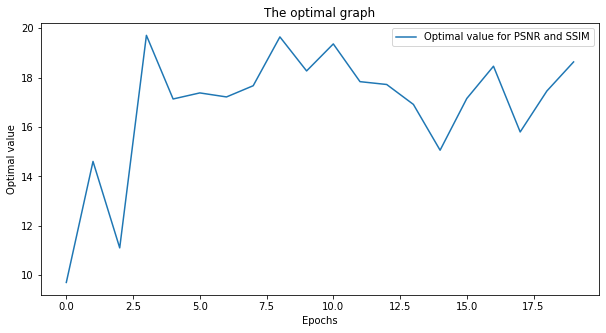

In [9]:
plt.figure(figsize=(10, 5))
plt.plot( Opt_srgan, label='Optimal value for PSNR and SSIM')
plt.xlabel('Epochs')
plt.ylabel('Optimal value')
plt.title('The optimal graph')
plt.legend()
plt.show()

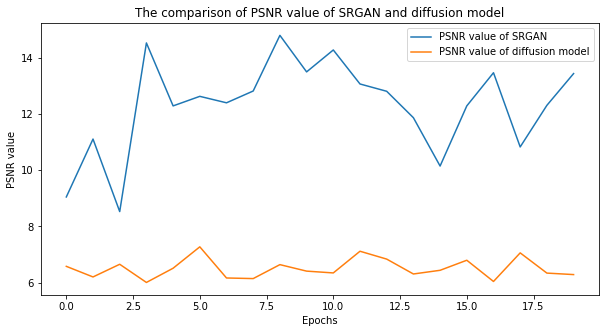

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(PSNR_srgan, label='PSNR value of SRGAN')
plt.plot(PSNR_diff,label='PSNR value of diffusion model')
plt.plot
plt.xlabel('Epochs')
plt.ylabel('PSNR value')
plt.title('The comparison of PSNR value of SRGAN and diffusion model')
plt.legend()
plt.show()

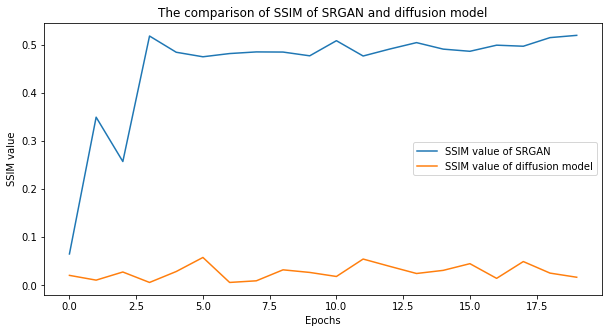

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(SSIM_srgan, label='SSIM value of SRGAN')
plt.plot(SSIM_diff,label='SSIM value of diffusion model')
plt.plot
plt.xlabel('Epochs')
plt.ylabel('SSIM value')
plt.title('The comparison of SSIM of SRGAN and diffusion model')
plt.legend()
plt.show()

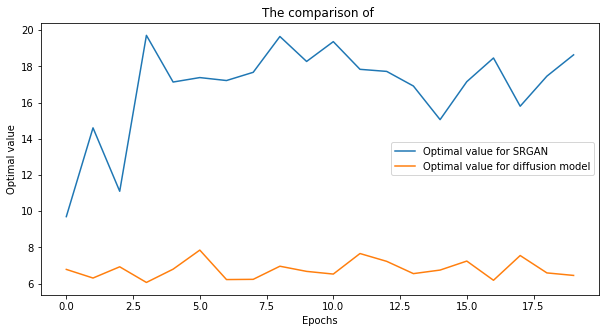

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(Opt_srgan, label='Optimal value for SRGAN')
plt.plot(Opt_diff,label='Optimal value for diffusion model')
plt.plot
plt.xlabel('Epochs')
plt.ylabel('Optimal value')
plt.title('The comparison of ')
plt.legend()
plt.show()

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
generator = Generator().to(device)
generator.load_state_dict(torch.load('saved_models/best_generator.pth'))
generator.eval()
discriminator = Discriminator().to(device)
discriminator.load_state_dict(torch.load("saved_models/best_discriminator.pth"))
discriminator.eval()

Using device: cuda:0


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13):

In [11]:
import torch
import os
from torchvision.utils import save_image

def save_sample_generated_images(generator, dataloader, high_res_dataloader, output_dir, device, num_samples=5):
    os.makedirs(output_dir, exist_ok=True)

    generator.eval()
    normal_count = 0
    pneumonia_count = 0
    
    with torch.no_grad():
        for i, ((low_res, labels), (high_res, _)) in enumerate(zip(dataloader, high_res_dataloader)):
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            gen_high_res = generator(low_res)

            # Clamp the generated image to [0, 1] and ensure correct channel order
            gen_high_res = gen_high_res.clamp(0, 1)
            low_res = low_res.clamp(0, 1)
            high_res = high_res.clamp(0, 1)

            for j in range(low_res.size(0)):
                label = labels[j].item()
                if label == 0 and normal_count < num_samples:
                    label_dir = 'NORMAL'
                    normal_count += 1
                elif label == 1 and pneumonia_count < num_samples:
                    label_dir = 'PNEUMONIA'
                    pneumonia_count += 1
                else:
                    continue

                count = normal_count if label == 0 else pneumonia_count

                # Save the generated high-resolution image
                save_path_gen = os.path.join(output_dir, f"{label_dir}_generated_{count}.png")
                save_image(gen_high_res[j], save_path_gen, normalize=True)

                # Save the original low-resolution image
                save_path_low = os.path.join(output_dir, f"{label_dir}_low_{count}.png")
                save_image(low_res[j], save_path_low, normalize=True)

                # Save the original high-resolution image
                save_path_high = os.path.join(output_dir, f"{label_dir}_high_{count}.png")
                save_image(high_res[j], save_path_high, normalize=True)

                print(f"Saved {label_dir} generated image to {save_path_gen}")
                print(f"Saved {label_dir} low-resolution image to {save_path_low}")
                print(f"Saved {label_dir} high-resolution image to {save_path_high}")

                if normal_count >= num_samples and pneumonia_count >= num_samples:
                    return

# Example usage
# Assuming `val_lowdataloader` is the low-resolution dataloader and `val_highdataloader` is the high-resolution dataloader
save_sample_generated_images(generator, val_lowdataloader, val_highdataloader, 'SRGAN_image/samples', device, num_samples=5)


Saved NORMAL generated image to SRGAN_image/samples/NORMAL_generated_1.png
Saved NORMAL low-resolution image to SRGAN_image/samples/NORMAL_low_1.png
Saved NORMAL high-resolution image to SRGAN_image/samples/NORMAL_high_1.png
Saved NORMAL generated image to SRGAN_image/samples/NORMAL_generated_2.png
Saved NORMAL low-resolution image to SRGAN_image/samples/NORMAL_low_2.png
Saved NORMAL high-resolution image to SRGAN_image/samples/NORMAL_high_2.png
Saved NORMAL generated image to SRGAN_image/samples/NORMAL_generated_3.png
Saved NORMAL low-resolution image to SRGAN_image/samples/NORMAL_low_3.png
Saved NORMAL high-resolution image to SRGAN_image/samples/NORMAL_high_3.png
Saved PNEUMONIA generated image to SRGAN_image/samples/PNEUMONIA_generated_1.png
Saved PNEUMONIA low-resolution image to SRGAN_image/samples/PNEUMONIA_low_1.png
Saved PNEUMONIA high-resolution image to SRGAN_image/samples/PNEUMONIA_high_1.png
Saved PNEUMONIA generated image to SRGAN_image/samples/PNEUMONIA_generated_2.png
S

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [53]:
def save_generated_images(generator, dataloader, output_dir, device):
    os.makedirs(os.path.join(output_dir, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'PNEUMONIA'), exist_ok=True)

    generator.eval()
    
    with torch.no_grad():
        for i, (low_res, labels) in enumerate(dataloader):
            low_res = low_res.to(device)
            gen_high_res = generator(low_res)

            for j in range(low_res.size(0)):
                label = labels[j].item()
                if label == 0:
                    label_dir = 'NORMAL'
                else:
                    label_dir = 'PNEUMONIA'

                save_path = os.path.join(output_dir, label_dir, f"generated_{i*low_res.size(0)+j}.png")
                save_image(gen_high_res[j], save_path, normalize=True)
                print(f"Saved image to {save_path}")


In [54]:
save_generated_images(generator, train_lowdataloader, 'SRGAN image/train', device)
save_generated_images(generator, test_lowdataloader, 'SRGAN image/test', device)
save_generated_images(generator, val_lowdataloader, 'SRGAN image/val', device)


Saved image to SRGAN image/train/PNEUMONIA/generated_0.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4.png
Saved image to SRGAN image/train/NORMAL/generated_5.png
Saved image to SRGAN image/train/PNEUMONIA/generated_6.png
Saved image to SRGAN image/train/PNEUMONIA/generated_7.png
Saved image to SRGAN image/train/PNEUMONIA/generated_8.png
Saved image to SRGAN image/train/PNEUMONIA/generated_9.png
Saved image to SRGAN image/train/PNEUMONIA/generated_10.png
Saved image to SRGAN image/train/PNEUMONIA/generated_11.png
Saved image to SRGAN image/train/PNEUMONIA/generated_12.png
Saved image to SRGAN image/train/PNEUMONIA/generated_13.png
Saved image to SRGAN image/train/PNEUMONIA/generated_14.png
Saved image to SRGAN image/train/NORMAL/generated_15.png
Saved image to SRGAN image/train/PNEUMONIA/generated_16.

Saved image to SRGAN image/train/NORMAL/generated_139.png
Saved image to SRGAN image/train/NORMAL/generated_140.png
Saved image to SRGAN image/train/PNEUMONIA/generated_141.png
Saved image to SRGAN image/train/PNEUMONIA/generated_142.png
Saved image to SRGAN image/train/NORMAL/generated_143.png
Saved image to SRGAN image/train/NORMAL/generated_144.png
Saved image to SRGAN image/train/NORMAL/generated_145.png
Saved image to SRGAN image/train/NORMAL/generated_146.png
Saved image to SRGAN image/train/PNEUMONIA/generated_147.png
Saved image to SRGAN image/train/NORMAL/generated_148.png
Saved image to SRGAN image/train/PNEUMONIA/generated_149.png
Saved image to SRGAN image/train/PNEUMONIA/generated_150.png
Saved image to SRGAN image/train/NORMAL/generated_151.png
Saved image to SRGAN image/train/PNEUMONIA/generated_152.png
Saved image to SRGAN image/train/PNEUMONIA/generated_153.png
Saved image to SRGAN image/train/PNEUMONIA/generated_154.png
Saved image to SRGAN image/train/NORMAL/generate

Saved image to SRGAN image/train/PNEUMONIA/generated_278.png
Saved image to SRGAN image/train/PNEUMONIA/generated_279.png
Saved image to SRGAN image/train/NORMAL/generated_280.png
Saved image to SRGAN image/train/PNEUMONIA/generated_281.png
Saved image to SRGAN image/train/PNEUMONIA/generated_282.png
Saved image to SRGAN image/train/PNEUMONIA/generated_283.png
Saved image to SRGAN image/train/NORMAL/generated_284.png
Saved image to SRGAN image/train/NORMAL/generated_285.png
Saved image to SRGAN image/train/PNEUMONIA/generated_286.png
Saved image to SRGAN image/train/PNEUMONIA/generated_287.png
Saved image to SRGAN image/train/PNEUMONIA/generated_288.png
Saved image to SRGAN image/train/PNEUMONIA/generated_289.png
Saved image to SRGAN image/train/NORMAL/generated_290.png
Saved image to SRGAN image/train/PNEUMONIA/generated_291.png
Saved image to SRGAN image/train/NORMAL/generated_292.png
Saved image to SRGAN image/train/NORMAL/generated_293.png
Saved image to SRGAN image/train/NORMAL/ge

Saved image to SRGAN image/train/PNEUMONIA/generated_414.png
Saved image to SRGAN image/train/PNEUMONIA/generated_415.png
Saved image to SRGAN image/train/NORMAL/generated_416.png
Saved image to SRGAN image/train/NORMAL/generated_417.png
Saved image to SRGAN image/train/PNEUMONIA/generated_418.png
Saved image to SRGAN image/train/NORMAL/generated_419.png
Saved image to SRGAN image/train/PNEUMONIA/generated_420.png
Saved image to SRGAN image/train/PNEUMONIA/generated_421.png
Saved image to SRGAN image/train/PNEUMONIA/generated_422.png
Saved image to SRGAN image/train/NORMAL/generated_423.png
Saved image to SRGAN image/train/PNEUMONIA/generated_424.png
Saved image to SRGAN image/train/PNEUMONIA/generated_425.png
Saved image to SRGAN image/train/NORMAL/generated_426.png
Saved image to SRGAN image/train/NORMAL/generated_427.png
Saved image to SRGAN image/train/PNEUMONIA/generated_428.png
Saved image to SRGAN image/train/PNEUMONIA/generated_429.png
Saved image to SRGAN image/train/NORMAL/ge

Saved image to SRGAN image/train/PNEUMONIA/generated_550.png
Saved image to SRGAN image/train/PNEUMONIA/generated_551.png
Saved image to SRGAN image/train/PNEUMONIA/generated_552.png
Saved image to SRGAN image/train/PNEUMONIA/generated_553.png
Saved image to SRGAN image/train/PNEUMONIA/generated_554.png
Saved image to SRGAN image/train/PNEUMONIA/generated_555.png
Saved image to SRGAN image/train/PNEUMONIA/generated_556.png
Saved image to SRGAN image/train/PNEUMONIA/generated_557.png
Saved image to SRGAN image/train/PNEUMONIA/generated_558.png
Saved image to SRGAN image/train/NORMAL/generated_559.png
Saved image to SRGAN image/train/PNEUMONIA/generated_560.png
Saved image to SRGAN image/train/NORMAL/generated_561.png
Saved image to SRGAN image/train/PNEUMONIA/generated_562.png
Saved image to SRGAN image/train/PNEUMONIA/generated_563.png
Saved image to SRGAN image/train/NORMAL/generated_564.png
Saved image to SRGAN image/train/PNEUMONIA/generated_565.png
Saved image to SRGAN image/train/

Saved image to SRGAN image/train/PNEUMONIA/generated_687.png
Saved image to SRGAN image/train/PNEUMONIA/generated_688.png
Saved image to SRGAN image/train/NORMAL/generated_689.png
Saved image to SRGAN image/train/PNEUMONIA/generated_690.png
Saved image to SRGAN image/train/PNEUMONIA/generated_691.png
Saved image to SRGAN image/train/PNEUMONIA/generated_692.png
Saved image to SRGAN image/train/PNEUMONIA/generated_693.png
Saved image to SRGAN image/train/PNEUMONIA/generated_694.png
Saved image to SRGAN image/train/PNEUMONIA/generated_695.png
Saved image to SRGAN image/train/PNEUMONIA/generated_696.png
Saved image to SRGAN image/train/NORMAL/generated_697.png
Saved image to SRGAN image/train/PNEUMONIA/generated_698.png
Saved image to SRGAN image/train/PNEUMONIA/generated_699.png
Saved image to SRGAN image/train/PNEUMONIA/generated_700.png
Saved image to SRGAN image/train/NORMAL/generated_701.png
Saved image to SRGAN image/train/NORMAL/generated_702.png
Saved image to SRGAN image/train/NOR

Saved image to SRGAN image/train/PNEUMONIA/generated_825.png
Saved image to SRGAN image/train/NORMAL/generated_826.png
Saved image to SRGAN image/train/NORMAL/generated_827.png
Saved image to SRGAN image/train/PNEUMONIA/generated_828.png
Saved image to SRGAN image/train/PNEUMONIA/generated_829.png
Saved image to SRGAN image/train/PNEUMONIA/generated_830.png
Saved image to SRGAN image/train/PNEUMONIA/generated_831.png
Saved image to SRGAN image/train/PNEUMONIA/generated_832.png
Saved image to SRGAN image/train/PNEUMONIA/generated_833.png
Saved image to SRGAN image/train/PNEUMONIA/generated_834.png
Saved image to SRGAN image/train/PNEUMONIA/generated_835.png
Saved image to SRGAN image/train/PNEUMONIA/generated_836.png
Saved image to SRGAN image/train/PNEUMONIA/generated_837.png
Saved image to SRGAN image/train/PNEUMONIA/generated_838.png
Saved image to SRGAN image/train/PNEUMONIA/generated_839.png
Saved image to SRGAN image/train/NORMAL/generated_840.png
Saved image to SRGAN image/train/

Saved image to SRGAN image/train/NORMAL/generated_963.png
Saved image to SRGAN image/train/PNEUMONIA/generated_964.png
Saved image to SRGAN image/train/PNEUMONIA/generated_965.png
Saved image to SRGAN image/train/NORMAL/generated_966.png
Saved image to SRGAN image/train/PNEUMONIA/generated_967.png
Saved image to SRGAN image/train/PNEUMONIA/generated_968.png
Saved image to SRGAN image/train/NORMAL/generated_969.png
Saved image to SRGAN image/train/PNEUMONIA/generated_970.png
Saved image to SRGAN image/train/PNEUMONIA/generated_971.png
Saved image to SRGAN image/train/NORMAL/generated_972.png
Saved image to SRGAN image/train/PNEUMONIA/generated_973.png
Saved image to SRGAN image/train/PNEUMONIA/generated_974.png
Saved image to SRGAN image/train/PNEUMONIA/generated_975.png
Saved image to SRGAN image/train/PNEUMONIA/generated_976.png
Saved image to SRGAN image/train/PNEUMONIA/generated_977.png
Saved image to SRGAN image/train/NORMAL/generated_978.png
Saved image to SRGAN image/train/PNEUMO

Saved image to SRGAN image/train/PNEUMONIA/generated_1099.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1100.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1101.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1102.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1103.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1104.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1105.png
Saved image to SRGAN image/train/NORMAL/generated_1106.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1107.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1108.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1109.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1110.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1111.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1112.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1113.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1114.png
Saved image

Saved image to SRGAN image/train/PNEUMONIA/generated_1236.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1237.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1238.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1239.png
Saved image to SRGAN image/train/NORMAL/generated_1240.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1241.png
Saved image to SRGAN image/train/NORMAL/generated_1242.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1243.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1244.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1245.png
Saved image to SRGAN image/train/NORMAL/generated_1246.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1247.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1248.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1249.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1250.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1251.png
Saved image to SR

Saved image to SRGAN image/train/PNEUMONIA/generated_1371.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1372.png
Saved image to SRGAN image/train/NORMAL/generated_1373.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1374.png
Saved image to SRGAN image/train/NORMAL/generated_1375.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1376.png
Saved image to SRGAN image/train/NORMAL/generated_1377.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1378.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1379.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1380.png
Saved image to SRGAN image/train/NORMAL/generated_1381.png
Saved image to SRGAN image/train/NORMAL/generated_1382.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1383.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1384.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1385.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1386.png
Saved image to SRGAN im

Saved image to SRGAN image/train/NORMAL/generated_1508.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1509.png
Saved image to SRGAN image/train/NORMAL/generated_1510.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1511.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1512.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1513.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1514.png
Saved image to SRGAN image/train/NORMAL/generated_1515.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1516.png
Saved image to SRGAN image/train/NORMAL/generated_1517.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1518.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1519.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1520.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1521.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1522.png
Saved image to SRGAN image/train/NORMAL/generated_1523.png
Saved image to SRGAN im

Saved image to SRGAN image/train/NORMAL/generated_1643.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1644.png
Saved image to SRGAN image/train/NORMAL/generated_1645.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1646.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1647.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1648.png
Saved image to SRGAN image/train/NORMAL/generated_1649.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1650.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1651.png
Saved image to SRGAN image/train/NORMAL/generated_1652.png
Saved image to SRGAN image/train/NORMAL/generated_1653.png
Saved image to SRGAN image/train/NORMAL/generated_1654.png
Saved image to SRGAN image/train/NORMAL/generated_1655.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1656.png
Saved image to SRGAN image/train/NORMAL/generated_1657.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1658.png
Saved image to SRGAN image/train

Saved image to SRGAN image/train/PNEUMONIA/generated_1778.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1779.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1780.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1781.png
Saved image to SRGAN image/train/NORMAL/generated_1782.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1783.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1784.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1785.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1786.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1787.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1788.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1789.png
Saved image to SRGAN image/train/NORMAL/generated_1790.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1791.png
Saved image to SRGAN image/train/NORMAL/generated_1792.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1793.png
Saved image to SR

Saved image to SRGAN image/train/PNEUMONIA/generated_1914.png
Saved image to SRGAN image/train/NORMAL/generated_1915.png
Saved image to SRGAN image/train/NORMAL/generated_1916.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1917.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1918.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1919.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1920.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1921.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1922.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1923.png
Saved image to SRGAN image/train/NORMAL/generated_1924.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1925.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1926.png
Saved image to SRGAN image/train/NORMAL/generated_1927.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1928.png
Saved image to SRGAN image/train/PNEUMONIA/generated_1929.png
Saved image to SRGAN

Saved image to SRGAN image/train/PNEUMONIA/generated_2048.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2049.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2050.png
Saved image to SRGAN image/train/NORMAL/generated_2051.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2052.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2053.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2054.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2055.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2056.png
Saved image to SRGAN image/train/NORMAL/generated_2057.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2058.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2059.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2060.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2061.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2062.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2063.png
Saved image to

Saved image to SRGAN image/train/NORMAL/generated_2182.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2183.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2184.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2185.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2186.png
Saved image to SRGAN image/train/NORMAL/generated_2187.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2188.png
Saved image to SRGAN image/train/NORMAL/generated_2189.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2190.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2191.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2192.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2193.png
Saved image to SRGAN image/train/NORMAL/generated_2194.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2195.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2196.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2197.png
Saved image to SRGAN

Saved image to SRGAN image/train/PNEUMONIA/generated_2317.png
Saved image to SRGAN image/train/NORMAL/generated_2318.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2319.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2320.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2321.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2322.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2323.png
Saved image to SRGAN image/train/NORMAL/generated_2324.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2325.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2326.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2327.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2328.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2329.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2330.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2331.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2332.png
Saved image to

Saved image to SRGAN image/train/PNEUMONIA/generated_2452.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2453.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2454.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2455.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2456.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2457.png
Saved image to SRGAN image/train/NORMAL/generated_2458.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2459.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2460.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2461.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2462.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2463.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2464.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2465.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2466.png
Saved image to SRGAN image/train/NORMAL/generated_2467.png
Saved image to

Saved image to SRGAN image/train/NORMAL/generated_2586.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2587.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2588.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2589.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2590.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2591.png
Saved image to SRGAN image/train/NORMAL/generated_2592.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2593.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2594.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2595.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2596.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2597.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2598.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2599.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2600.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2601.png
Saved image to

Saved image to SRGAN image/train/PNEUMONIA/generated_2720.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2721.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2722.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2723.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2724.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2725.png
Saved image to SRGAN image/train/NORMAL/generated_2726.png
Saved image to SRGAN image/train/NORMAL/generated_2727.png
Saved image to SRGAN image/train/NORMAL/generated_2728.png
Saved image to SRGAN image/train/NORMAL/generated_2729.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2730.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2731.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2732.png
Saved image to SRGAN image/train/NORMAL/generated_2733.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2734.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2735.png
Saved image to SRGAN im

Saved image to SRGAN image/train/PNEUMONIA/generated_2854.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2855.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2856.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2857.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2858.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2859.png
Saved image to SRGAN image/train/NORMAL/generated_2860.png
Saved image to SRGAN image/train/NORMAL/generated_2861.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2862.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2863.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2864.png
Saved image to SRGAN image/train/NORMAL/generated_2865.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2866.png
Saved image to SRGAN image/train/NORMAL/generated_2867.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2868.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2869.png
Saved image to SRGAN

Saved image to SRGAN image/train/PNEUMONIA/generated_2989.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2990.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2991.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2992.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2993.png
Saved image to SRGAN image/train/NORMAL/generated_2994.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2995.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2996.png
Saved image to SRGAN image/train/NORMAL/generated_2997.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2998.png
Saved image to SRGAN image/train/PNEUMONIA/generated_2999.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3000.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3001.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3002.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3003.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3004.png
Saved image to

Saved image to SRGAN image/train/PNEUMONIA/generated_3123.png
Saved image to SRGAN image/train/NORMAL/generated_3124.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3125.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3126.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3127.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3128.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3129.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3130.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3131.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3132.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3133.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3134.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3135.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3136.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3137.png
Saved image to SRGAN image/train/NORMAL/generated_3138.png
Saved image to

Saved image to SRGAN image/train/PNEUMONIA/generated_3259.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3260.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3261.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3262.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3263.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3264.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3265.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3266.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3267.png
Saved image to SRGAN image/train/NORMAL/generated_3268.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3269.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3270.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3271.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3272.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3273.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3274.png
Saved image

Saved image to SRGAN image/train/PNEUMONIA/generated_3393.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3394.png
Saved image to SRGAN image/train/NORMAL/generated_3395.png
Saved image to SRGAN image/train/NORMAL/generated_3396.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3397.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3398.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3399.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3400.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3401.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3402.png
Saved image to SRGAN image/train/NORMAL/generated_3403.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3404.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3405.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3406.png
Saved image to SRGAN image/train/NORMAL/generated_3407.png
Saved image to SRGAN image/train/NORMAL/generated_3408.png
Saved image to SRGAN im

Saved image to SRGAN image/train/PNEUMONIA/generated_3530.png
Saved image to SRGAN image/train/NORMAL/generated_3531.png
Saved image to SRGAN image/train/NORMAL/generated_3532.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3533.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3534.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3535.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3536.png
Saved image to SRGAN image/train/NORMAL/generated_3537.png
Saved image to SRGAN image/train/NORMAL/generated_3538.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3539.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3540.png
Saved image to SRGAN image/train/NORMAL/generated_3541.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3542.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3543.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3544.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3545.png
Saved image to SRGAN im

Saved image to SRGAN image/train/PNEUMONIA/generated_3665.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3666.png
Saved image to SRGAN image/train/NORMAL/generated_3667.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3668.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3669.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3670.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3671.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3672.png
Saved image to SRGAN image/train/NORMAL/generated_3673.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3674.png
Saved image to SRGAN image/train/NORMAL/generated_3675.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3676.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3677.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3678.png
Saved image to SRGAN image/train/NORMAL/generated_3679.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3680.png
Saved image to SRGAN

Saved image to SRGAN image/train/PNEUMONIA/generated_3800.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3801.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3802.png
Saved image to SRGAN image/train/NORMAL/generated_3803.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3804.png
Saved image to SRGAN image/train/NORMAL/generated_3805.png
Saved image to SRGAN image/train/NORMAL/generated_3806.png
Saved image to SRGAN image/train/NORMAL/generated_3807.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3808.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3809.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3810.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3811.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3812.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3813.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3814.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3815.png
Saved image to SRGAN

Saved image to SRGAN image/train/PNEUMONIA/generated_3934.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3935.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3936.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3937.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3938.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3939.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3940.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3941.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3942.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3943.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3944.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3945.png
Saved image to SRGAN image/train/NORMAL/generated_3946.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3947.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3948.png
Saved image to SRGAN image/train/PNEUMONIA/generated_3949.png
Saved image

Saved image to SRGAN image/train/PNEUMONIA/generated_4070.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4071.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4072.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4073.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4074.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4075.png
Saved image to SRGAN image/train/NORMAL/generated_4076.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4077.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4078.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4079.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4080.png
Saved image to SRGAN image/train/NORMAL/generated_4081.png
Saved image to SRGAN image/train/NORMAL/generated_4082.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4083.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4084.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4085.png
Saved image to SR

Saved image to SRGAN image/train/NORMAL/generated_4205.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4206.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4207.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4208.png
Saved image to SRGAN image/train/NORMAL/generated_4209.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4210.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4211.png
Saved image to SRGAN image/train/NORMAL/generated_4212.png
Saved image to SRGAN image/train/NORMAL/generated_4213.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4214.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4215.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4216.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4217.png
Saved image to SRGAN image/train/NORMAL/generated_4218.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4219.png
Saved image to SRGAN image/train/NORMAL/generated_4220.png
Saved image to SRGAN image

Saved image to SRGAN image/train/PNEUMONIA/generated_4340.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4341.png
Saved image to SRGAN image/train/NORMAL/generated_4342.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4343.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4344.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4345.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4346.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4347.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4348.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4349.png
Saved image to SRGAN image/train/NORMAL/generated_4350.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4351.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4352.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4353.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4354.png
Saved image to SRGAN image/train/NORMAL/generated_4355.png
Saved image to SR

Saved image to SRGAN image/train/PNEUMONIA/generated_4475.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4476.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4477.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4478.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4479.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4480.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4481.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4482.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4483.png
Saved image to SRGAN image/train/NORMAL/generated_4484.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4485.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4486.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4487.png
Saved image to SRGAN image/train/NORMAL/generated_4488.png
Saved image to SRGAN image/train/NORMAL/generated_4489.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4490.png
Saved image to SR

Saved image to SRGAN image/train/PNEUMONIA/generated_4611.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4612.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4613.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4614.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4615.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4616.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4617.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4618.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4619.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4620.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4621.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4622.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4623.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4624.png
Saved image to SRGAN image/train/NORMAL/generated_4625.png
Saved image to SRGAN image/train/NORMAL/generated_4626.png
Saved image to

Saved image to SRGAN image/train/PNEUMONIA/generated_4745.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4746.png
Saved image to SRGAN image/train/NORMAL/generated_4747.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4748.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4749.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4750.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4751.png
Saved image to SRGAN image/train/NORMAL/generated_4752.png
Saved image to SRGAN image/train/NORMAL/generated_4753.png
Saved image to SRGAN image/train/NORMAL/generated_4754.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4755.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4756.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4757.png
Saved image to SRGAN image/train/NORMAL/generated_4758.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4759.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4760.png
Saved image to SRGAN im

Saved image to SRGAN image/train/PNEUMONIA/generated_4881.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4882.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4883.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4884.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4885.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4886.png
Saved image to SRGAN image/train/NORMAL/generated_4887.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4888.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4889.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4890.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4891.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4892.png
Saved image to SRGAN image/train/NORMAL/generated_4893.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4894.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4895.png
Saved image to SRGAN image/train/PNEUMONIA/generated_4896.png
Saved image to

Saved image to SRGAN image/train/PNEUMONIA/generated_5016.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5017.png
Saved image to SRGAN image/train/NORMAL/generated_5018.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5019.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5020.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5021.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5022.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5023.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5024.png
Saved image to SRGAN image/train/NORMAL/generated_5025.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5026.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5027.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5028.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5029.png
Saved image to SRGAN image/train/NORMAL/generated_5030.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5031.png
Saved image to SR

Saved image to SRGAN image/train/PNEUMONIA/generated_5150.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5151.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5152.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5153.png
Saved image to SRGAN image/train/NORMAL/generated_5154.png
Saved image to SRGAN image/train/NORMAL/generated_5155.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5156.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5157.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5158.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5159.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5160.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5161.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5162.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5163.png
Saved image to SRGAN image/train/NORMAL/generated_5164.png
Saved image to SRGAN image/train/PNEUMONIA/generated_5165.png
Saved image to SR

Saved image to SRGAN image/test/PNEUMONIA/generated_73.png
Saved image to SRGAN image/test/NORMAL/generated_74.png
Saved image to SRGAN image/test/PNEUMONIA/generated_75.png
Saved image to SRGAN image/test/PNEUMONIA/generated_76.png
Saved image to SRGAN image/test/NORMAL/generated_77.png
Saved image to SRGAN image/test/PNEUMONIA/generated_78.png
Saved image to SRGAN image/test/NORMAL/generated_79.png
Saved image to SRGAN image/test/NORMAL/generated_80.png
Saved image to SRGAN image/test/NORMAL/generated_81.png
Saved image to SRGAN image/test/PNEUMONIA/generated_82.png
Saved image to SRGAN image/test/PNEUMONIA/generated_83.png
Saved image to SRGAN image/test/PNEUMONIA/generated_84.png
Saved image to SRGAN image/test/NORMAL/generated_85.png
Saved image to SRGAN image/test/NORMAL/generated_86.png
Saved image to SRGAN image/test/NORMAL/generated_87.png
Saved image to SRGAN image/test/PNEUMONIA/generated_88.png
Saved image to SRGAN image/test/PNEUMONIA/generated_89.png
Saved image to SRGAN 

Saved image to SRGAN image/test/PNEUMONIA/generated_213.png
Saved image to SRGAN image/test/PNEUMONIA/generated_214.png
Saved image to SRGAN image/test/PNEUMONIA/generated_215.png
Saved image to SRGAN image/test/PNEUMONIA/generated_216.png
Saved image to SRGAN image/test/PNEUMONIA/generated_217.png
Saved image to SRGAN image/test/PNEUMONIA/generated_218.png
Saved image to SRGAN image/test/PNEUMONIA/generated_219.png
Saved image to SRGAN image/test/NORMAL/generated_220.png
Saved image to SRGAN image/test/NORMAL/generated_221.png
Saved image to SRGAN image/test/PNEUMONIA/generated_222.png
Saved image to SRGAN image/test/PNEUMONIA/generated_223.png
Saved image to SRGAN image/test/PNEUMONIA/generated_224.png
Saved image to SRGAN image/test/NORMAL/generated_225.png
Saved image to SRGAN image/test/PNEUMONIA/generated_226.png
Saved image to SRGAN image/test/NORMAL/generated_227.png
Saved image to SRGAN image/test/PNEUMONIA/generated_228.png
Saved image to SRGAN image/test/NORMAL/generated_229

Saved image to SRGAN image/test/NORMAL/generated_355.png
Saved image to SRGAN image/test/NORMAL/generated_356.png
Saved image to SRGAN image/test/PNEUMONIA/generated_357.png
Saved image to SRGAN image/test/NORMAL/generated_358.png
Saved image to SRGAN image/test/PNEUMONIA/generated_359.png
Saved image to SRGAN image/test/NORMAL/generated_360.png
Saved image to SRGAN image/test/NORMAL/generated_361.png
Saved image to SRGAN image/test/PNEUMONIA/generated_362.png
Saved image to SRGAN image/test/NORMAL/generated_363.png
Saved image to SRGAN image/test/PNEUMONIA/generated_364.png
Saved image to SRGAN image/test/PNEUMONIA/generated_365.png
Saved image to SRGAN image/test/PNEUMONIA/generated_366.png
Saved image to SRGAN image/test/PNEUMONIA/generated_367.png
Saved image to SRGAN image/test/PNEUMONIA/generated_368.png
Saved image to SRGAN image/test/NORMAL/generated_369.png
Saved image to SRGAN image/test/PNEUMONIA/generated_370.png
Saved image to SRGAN image/test/PNEUMONIA/generated_371.png
S

Saved image to SRGAN image/test/NORMAL/generated_495.png
Saved image to SRGAN image/test/NORMAL/generated_496.png
Saved image to SRGAN image/test/PNEUMONIA/generated_497.png
Saved image to SRGAN image/test/PNEUMONIA/generated_498.png
Saved image to SRGAN image/test/NORMAL/generated_499.png
Saved image to SRGAN image/test/PNEUMONIA/generated_500.png
Saved image to SRGAN image/test/PNEUMONIA/generated_501.png
Saved image to SRGAN image/test/PNEUMONIA/generated_502.png
Saved image to SRGAN image/test/PNEUMONIA/generated_503.png
Saved image to SRGAN image/test/PNEUMONIA/generated_504.png
Saved image to SRGAN image/test/NORMAL/generated_505.png
Saved image to SRGAN image/test/PNEUMONIA/generated_506.png
Saved image to SRGAN image/test/NORMAL/generated_507.png
Saved image to SRGAN image/test/PNEUMONIA/generated_508.png
Saved image to SRGAN image/test/NORMAL/generated_509.png
Saved image to SRGAN image/test/NORMAL/generated_510.png
Saved image to SRGAN image/test/PNEUMONIA/generated_511.png
S

Saved image to SRGAN image/val/PNEUMONIA/generated_11.png
Saved image to SRGAN image/val/PNEUMONIA/generated_12.png
Saved image to SRGAN image/val/NORMAL/generated_13.png
Saved image to SRGAN image/val/NORMAL/generated_14.png
Saved image to SRGAN image/val/PNEUMONIA/generated_15.png


In [ ]:
                sr_image = transforms.ToPILImage()(sr_image)
    for i in enumerate(dataloader):
        Generator(dataloader)
        save_image(, f"samples/sample_epoch_{epoch}.png", normalize=True)

In [ ]:
from torch.utils.data import Dataset

class HighLowResDataset(Dataset):
    def __init__(self, high_res_dataset, low_res_dataset):
        assert len(high_res_dataset) == len(low_res_dataset), "Datasets must be of equal length"
        self.high_res_dataset = high_res_dataset
        self.low_res_dataset = low_res_dataset

    def __len__(self):
        return len(self.high_res_dataset)

    def __getitem__(self, idx):
        high_res_image, _ = self.high_res_dataset[idx]
        low_res_image, _ = self.low_res_dataset[idx]
        return low_res_image, high_res_image

# Initialize your datasets
train_high_low_dataset = HighLowResDataset(train_highdata, train_lowdata)

# Create a DataLoader for the combined dataset
train_high_low_dataloader = DataLoader(train_high_low_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


In [ ]:
def display_images(low_res_images, gen_images, high_res_images, num_images=5, image_size=(8, 8)):
    plt.figure(figsize=(20,10))
    for i in range(num_images):
        # Low-resolution image
        plt.subplot(3, num_images, i + 1)
        plt.imshow(np.transpose(low_res_images[i], (1, 2, 0)))
        plt.title('Low Res')
        plt.axis('off')

        # Generated high-resolution image
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(np.transpose(gen_images[i], (1, 2, 0)))
        plt.title('Generated High Res')
        plt.axis('off')

        # Original high-resolution image
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(np.transpose(high_res_images[i], (1, 2, 0)))
        plt.title('Original High Res')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Function to save generated images
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def generate_and_save_images(generator, dataloader, device, save_path):
    generator.eval()  # Set the generator to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation
        for batch_idx, (low_res, labels) in enumerate(dataloader):
            # Move input to the same device as the model
            low_res = low_res.to(device)
            
            # Generate high-res images
            gen_high_res = generator(low_res)
            
            # Move generated images back to CPU for saving
            gen_high_res = gen_high_res.cpu()
            
            # Save each image in the batch
            for i, img in enumerate(gen_high_res):
                # Determine the label (assuming binary classification)
                label = 'NORMAL' if labels[i].item() == 0 else 'PNEUMONIA'
                
                # Create directory if it doesn't exist
                os.makedirs(os.path.join(save_path, label), exist_ok=True)
                
                # Save the image
                save_image(img, os.path.join(save_path, label, f"generated_{batch_idx}_{i}.png"), normalize=True)
            
            if batch_idx % 10 == 0:  # Print progress every 10 batches
                print(f"Processed batch {batch_idx}/{len(dataloader)}")

    print(f"All images generated and saved to {save_path}")

# Train the SRGAN
def train(generator, discriminator, low_loader, high_loader, epochs, device, save_path):
    for epoch in range(epochs):
        start_time = time.time()
        running_loss_G = 0.0
        running_loss_D = 0.0
        total_batches = 0

        for low_res, high_res in zip(low_loader, high_loader):
            low_res, high_res = low_res[0].to(device), high_res[0].to(device)
            labels = high_res[1]

            valid = torch.ones((high_res.size(0), 1), device=device, requires_grad=False)
            fake = torch.zeros((high_res.size(0), 1), device=device, requires_grad=False)

            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()

            gen_high_res = generator(low_res)
            pred_fake = discriminator(gen_high_res)
            loss_GAN = criterion_GAN(pred_fake, valid)
            loss_content = criterion_content(gen_high_res, high_res)
            loss_G = loss_content + loss_GAN
            loss_G.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()

            pred_real = discriminator(high_res)
            loss_real = criterion_GAN(pred_real, valid)
            pred_fake = discriminator(gen_high_res.detach())
            loss_fake = criterion_GAN(pred_fake, fake)
            loss_D = (loss_real + loss_fake) / 2
            loss_D.backward()
            optimizer_D.step()

            # Accumulate losses
            running_loss_G += loss_G.item()
            running_loss_D += loss_D.item()
            total_batches += 1

        # Average the losses over all batches
        running_loss_G /= total_batches
        running_loss_D /= total_batches

        # Calculate PSNR and SSIM on the validation set
        val_psnr, val_ssim = 0, 0
        n_batches = 0
        for low_res, high_res in zip(low_loader, high_loader):
            low_res, high_res = low_res[0].to(device), high_res[0].to(device)
            sr = generator(low_res)
            sr = sr.mul(255).clamp(0, 255).byte()
            high_res = high_res.mul(255).clamp(0, 255).byte()
            for i in range(sr.size(0)):
                val_psnr += psnr(high_res[i].cpu().numpy(), sr[i].cpu().numpy(), data_range=255)
                val_ssim += ssim(high_res[i].cpu().numpy(), sr[i].cpu().numpy(), data_range=255, channel_axis=2, win_size=3)
            n_batches += 1
        val_psnr /= n_batches
        val_ssim /= n_batches
        end_time = time.time()
        epoch_time = end_time - start_time
        print(f'Epoch {epoch + 1}/{epochs}: G_Loss={running_loss_G:.4f}, D_Loss={running_loss_D:.4f}, PSNR={val_psnr:.2f}, SSIM={val_ssim:.4f}, Time={epoch_time:.2f}s')

        # Save generated images
        gen_images = generator(low_res).detach().cpu().numpy()
        high_res_images = high_res.detach().cpu().numpy()
        low_res_images = low_res.detach().cpu().numpy()
        display_images(low_res_images, gen_images, high_res_images, num_images=5)
        save_generated_images(gen_high_res, save_path, labels.cpu().numpy())

## Diffusion Model

## This part of code is from the https://medium.com/@adityanutakki6250/sr3-explained-and-implemented-in-pytorch-from-scratch-b43b9742c232 


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import log
class UNet(nn.Module):
    def __init__(self, input_channels = 1, output_channels = 1, time_steps = 512):
        super().__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.time_steps = time_steps
        self.time_steps = time_steps
        
        self.e1 = encoder_block(self.input_channels, 64, time_steps=self.time_steps)
        self.e2 = encoder_block(64, 128, time_steps=self.time_steps)
        self.da2 = AttnBlock(128)
        self.e3 = encoder_block(128, 256, time_steps=self.time_steps)
        self.da3 = AttnBlock(256)
        self.e4 = encoder_block(256, 512, time_steps=self.time_steps)
        self.da4 = AttnBlock(512)
        
        self.b = conv_block(512, 1024, time_steps=self.time_steps) 
        self.ba1 = AttnBlock(1024)
        self.d1 = decoder_block(1024, 512, time_steps=self.time_steps)
        self.ua1 = AttnBlock(512)
        self.d2 = decoder_block(512, 256, time_steps=self.time_steps)
        self.ua2 = AttnBlock(256)
        self.d3 = decoder_block(256, 128, time_steps=self.time_steps)
        #self.ua3 = AttnBlock(128)
        self.d4 = decoder_block(128, 64, time_steps=self.time_steps)
        self.outputs = nn.Conv2d(64, self.output_channels, kernel_size=1, padding=0)

    def forward(self, inputs, t = None):
        # downsampling
        s1, p1 = self.e1(inputs, t)
        s2, p2 = self.e2(p1, t)
        s3, p3 = self.e3(p2, t)
        p3 = self.da3(p3)
        s4, p4 = self.e4(p3, t)
        p4 = self.da4(p4)
        # bottleneck
        b = self.b(p4, t)
        b = self.ba1(b)
        # upsampling
        d1 = self.d1(b, s4, t)
        d1 = self.ua1(d1)
        d2 = self.d2(d1, s3, t)
        d2 = self.ua2(d2)
        d3 = self.d3(d2, s2, t)
        d4 = self.d4(d3, s1, t)
        outputs = self.outputs(d4)
        return outputs

In [29]:
class AttnBlock(nn.Module):
    def __init__(self, embedding_dims, num_heads = 4) -> None:
        super().__init__()
        
        self.embedding_dims = embedding_dims
        self.ln = nn.LayerNorm(embedding_dims)
        self.mhsa = MultiHeadSelfAttention(embedding_dims = embedding_dims, num_heads = num_heads)
        self.ff = nn.Sequential(
            nn.LayerNorm(self.embedding_dims),
            nn.Linear(self.embedding_dims, self.embedding_dims),
            nn.GELU(),
            nn.Linear(self.embedding_dims, self.embedding_dims),
        )
    def forward(self, x):
        bs, c, sz, _ = x.shape
        x = x.view(-1, self.embedding_dims, sz * sz).swapaxes(1, 2) # is of the shape (bs, sz**2, self.embedding_dims)
        x_ln = self.ln(x)
        _, attention_value = self.mhsa(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, c, sz, sz)

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dims, num_heads = 4) -> None:
        super().__init__()
        self.embedding_dims = embedding_dims
        self.num_heads = num_heads
        assert self.embedding_dims % self.num_heads == 0, f"{self.embedding_dims} not divisible by {self.num_heads}"
        self.head_dim = self.embedding_dims // self.num_heads
        self.wq = nn.Linear(self.head_dim, self.head_dim)
        self.wk = nn.Linear(self.head_dim, self.head_dim)
        self.wv = nn.Linear(self.head_dim, self.head_dim)
        self.wo = nn.Linear(self.embedding_dims, self.embedding_dims)

    def attention(self, q, k, v):
        # no need for a mask
        attn_weights = F.softmax((q @ k.transpose(-1, -2))/self.head_dim**0.5, dim = -1)
        return attn_weights, attn_weights @ v        

    def forward(self, q, k, v):
        bs, img_sz, c = q.shape
        q = q.view(bs, img_sz, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(bs, img_sz, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(bs, img_sz, self.num_heads, self.head_dim).transpose(1, 2)
        # q, k, v of the shape (bs, self.num_heads, img_sz**2, self.head_dim)
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        attn_weights, o = self.attention(q, k, v) # of shape (bs, num_heads, img_sz**2, c)
        
        o = o.transpose(1, 2).contiguous().view(bs, img_sz, self.embedding_dims)
        o = self.wo(o)
        return attn_weights, o

In [33]:
# Encoder Block for downsampling
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c, time_steps, activation = "relu"):
        super().__init__()
        self.conv = conv_block(in_c, out_c, time_steps = time_steps, activation = activation, embedding_dims = out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs, time = None):
        x = self.conv(inputs, time)
        p = self.pool(x)
        return x, p

# Decoder Block for upsampling
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c, time_steps, activation = "relu"):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c, time_steps = time_steps, activation = activation, embedding_dims = out_c)
    def forward(self, inputs, skip, time = None):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x, time)
        return x
class GammaEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.linear = nn.Linear(dim, dim)
        self.act = nn.LeakyReLU()
    def forward(self, noise_level):
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype, device=noise_level.device) / count
        encoding = noise_level.unsqueeze(1) * torch.exp(log(1e4) * step.unsqueeze(0))
        encoding = torch.cat([torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return self.act(self.linear(encoding))
class conv_block(nn.Module):
    def __init__(self, in_c, out_c, time_steps = 1000, activation = "relu", embedding_dims = None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.embedding_dims = embedding_dims if embedding_dims else out_c
        
        # self.embedding = nn.Embedding(time_steps, embedding_dim = self.embedding_dims)
        self.embedding = GammaEncoding(self.embedding_dims)
        # switch to nn.Embedding if you want to pass in timestep instead; but note that it should be of dtype torch.long
        self.act = nn.ReLU() if activation == "relu" else nn.SiLU()
        
    def forward(self, inputs, time = None):
        time_embedding = self.embedding(time).view(-1, self.embedding_dims, 1, 1)
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = x + time_embedding
        return x

In [31]:
class DiffusionModel(nn.Module):
    def __init__(self, time_steps, 
                 beta_start = 10e-4, 
                 beta_end = 0.02,
                 image_dims = (3, 256, 256)):
        
        super().__init__()
        self.time_steps = time_steps
        self.image_dims = image_dims
        c, h, w = self.image_dims
        self.img_size, self.input_channels = h, c
        self.betas = torch.linspace(beta_start, beta_end, self.time_steps)
        self.alphas = 1 - self.betas
        self.alpha_hats = torch.cumprod(self.alphas, dim = -1)
        self.model = UNet(input_channels = 2*c, output_channels = c, time_steps = self.time_steps)
        
    def add_noise(self, x, ts):
        noise = torch.randn_like(x).to(x.device)
        noised_examples = []
        for i, t in enumerate(ts):
            alpha_hat_t = self.alpha_hats[t]
            noised_example = torch.sqrt(alpha_hat_t) * x[i] + torch.sqrt(1 - alpha_hat_t) * noise[i]
            noised_examples.append(noised_example)
        return torch.stack(noised_examples), noise

#     def add_noise(self, x, ts):
        
#         # 'x' and 'ts' are expected to be batched
#         noise = torch.randn_like(x)
#         # print(x.shape, noise.shape)
#         noised_examples = []
#         for i, t in enumerate(ts):
#             alpha_hat_t = self.alpha_hats[t]
#             noised_examples.append(torch.sqrt(alpha_hat_t)*x[i] + torch.sqrt(1 - alpha_hat_t)*noise[i])
#         return torch.stack(noised_examples), noise

    def forward(self, x, t):
        return self.model(x, t)

In [14]:
# def get_combined_score(psnr,ssim):
#     # Normalize PSNR and SSIM to [0, 1] range
#     norm_psnr = (psnr - 20) / 20  # Assuming PSNR range of [20, 40]
#     norm_ssim = (ssim + 1) / 2    # SSIM range is [-1, 1]

#     # Combined score (you can adjust the weights if needed)
#     combined_score = 0.5 * norm_psnr + 0.5 * norm_ssim
#     return combined_score

In [16]:
import os
import torch
from torchvision.utils import save_image

def save_sample_images(model, val_low_loader, val_high_loader, device, epoch, high_res_size=(256, 256)):
    model.eval()
    os.makedirs('sample_images1', exist_ok=True)
    
    with torch.no_grad():
        saved_images = 0
        max_images_to_save = 25  # Adjust this number as needed
        
        for i, ((low_res, _), (high_res, _)) in enumerate(zip(val_low_loader, val_high_loader)):
            low_res, high_res = low_res.to(device), high_res.to(device)

            # Upsample low-res to match high-res dimensions
            low_res_upsampled = nn.functional.interpolate(low_res, size=high_res_size, mode='bicubic', align_corners=False)

            # Generate noisy high-res images as input to the model
            bs = high_res.shape[0]
            ts = torch.randint(low=1, high=model.time_steps, size=(bs,)).to(device)
            gamma = model.alpha_hats[ts].to(device)

            noisy_high_res, _ = model.add_noise(high_res, ts)

            # Concatenate low-res and noisy high-res
            x = torch.cat([low_res_upsampled, noisy_high_res], dim=1)

            # Forward pass through the model
            output = model(x, gamma)
            output = output.clamp(0, 1)  # Ensure output is in the range [0, 1]

            # Save each image in the batch individually
            for j in range(output.size(0)):
                save_image(output[j], f'sample_images1/epoch_{epoch+1}_batch_{i+1}_img_{j+1}.png', normalize=True)
                saved_images += 1
                if saved_images >= max_images_to_save:
                    break
            
            if saved_images >= max_images_to_save:
                break


In [11]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def train_ddpm(time_steps=2000, epochs=20, batch_size=8, device="cuda:0", high_res_size=(256, 256), low_res_size=(64, 64)):
    # Define transforms
    transform_high_res = transforms.Compose([transforms.Resize(high_res_size), transforms.ToTensor()])
    transform_low_res = transforms.Compose([transforms.Resize(low_res_size), transforms.ToTensor()])
    
    # Define dataset paths
    train_dir = 'chest_xray/train'

    # Create datasets
    train_highdata = datasets.ImageFolder(train_dir, transform=transform_high_res)
    train_lowdata = datasets.ImageFolder(train_dir, transform=transform_low_res)

    # Create dataloaders
    train_highdataloader = DataLoader(train_highdata, batch_size=batch_size, shuffle=True, num_workers=4)
    train_lowdataloader = DataLoader(train_lowdata, batch_size=batch_size, shuffle=True, num_workers=4)

    # Initialize the DiffusionModel
    ddpm = DiffusionModel(time_steps=time_steps, image_dims=(3, *high_res_size)).to(device)

    opt = torch.optim.Adam(ddpm.model.parameters(), lr=1e-3)
    criterion = nn.MSELoss(reduction="mean")
    best_PSNR = float('-inf')
    os.makedirs("saved_models", exist_ok=True)
    print()
    for epoch in range(epochs):
        ddpm.model.train()
        print(f"Epoch {epoch+1}:")
        losses = []
        stime = time.time()

        for (high_res, _), (low_res, _) in tqdm(zip(train_highdataloader, train_lowdataloader), total=len(train_highdataloader)):
            high_res = high_res.to(device)
            low_res = low_res.to(device)

            bs = high_res.shape[0]
            ts = torch.randint(low=1, high=ddpm.time_steps, size=(bs,))
            gamma = ddpm.alpha_hats[ts].to(device)
            ts = ts.to(device)

            # Add noise to high-res images
            noisy_high_res, target_noise = ddpm.add_noise(high_res, ts)

            # Upsample low-res to match high-res dimensions
            low_res_upsampled = nn.functional.interpolate(low_res, size=high_res_size, mode='bicubic', align_corners=False)

            # Concatenate low-res and noisy high-res
            x = torch.cat([low_res_upsampled, noisy_high_res], dim=1)

            predicted_noise = ddpm.model(x, gamma)
            loss = criterion(target_noise, predicted_noise)

            opt.zero_grad()
            loss.backward()
            opt.step()

            losses.append(loss.item())

        ftime = time.time()
        avg_loss = sum(losses) / len(losses)
        print(f"Epoch {epoch+1} trained in {ftime - stime:.2f}s; Avg loss => {avg_loss:.4f}")

        # Validation phase: Calculate PSNR and SSIM
        ddpm.model.eval()
        psnr_values = []
        ssim_values = []

        with torch.no_grad():
            for (high_res, _), (low_res, _) in zip(train_highdataloader, train_lowdataloader):
                high_res = high_res.to(device)
                low_res = low_res.to(device)

                bs = high_res.shape[0]
                ts = torch.randint(low=1, high=ddpm.time_steps, size=(bs,))
                gamma = ddpm.alpha_hats[ts].to(device)
                ts = ts.to(device)

                # Add noise to high-res images
                noisy_high_res, _ = ddpm.add_noise(high_res, ts)

                # Upsample low-res to match high-res dimensions
                low_res_upsampled = nn.functional.interpolate(low_res, size=high_res_size, mode='bicubic', align_corners=False)

                # Concatenate low-res and noisy high-res
                x = torch.cat([low_res_upsampled, noisy_high_res], dim=1)

                # Predict noise and generate the high-resolution image
                predicted_noise = ddpm.model(x, gamma)
                generated_high_res = noisy_high_res - predicted_noise

                generated_high_res = generated_high_res.cpu().numpy().transpose(0, 2, 3, 1)
                high_res = high_res.cpu().numpy().transpose(0, 2, 3, 1)

                for i in range(generated_high_res.shape[0]):
                    psnr = peak_signal_noise_ratio(high_res[i], generated_high_res[i], data_range=1.0)
                    ssim = structural_similarity(high_res[i], generated_high_res[i], channel_axis=-1, data_range=1.0)
                    psnr_values.append(psnr)
                    ssim_values.append(ssim)

        avg_psnr = sum(psnr_values) / len(psnr_values)
        avg_ssim = sum(ssim_values) / len(ssim_values)
        print(f"Validation PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}")
        
        
#         # Save and display sample images
        if (epoch + 1) % save_interval == 0:
            save_sample_images(ddpm, val_lowdataloader, val_highdataloader, device, epoch)
        current_PSNR = avg_psnr
        if current_PSNR > best_PSNR:
            best_PSNR=current_PSNR
            torch.save(ddpm.state_dict(), f"saved_models/ddpm_super_resolution.pth")

        #torch.save(ddpm.state_dict(), f"./sr_ep_{ep}.pt")
        #print()

    return ddpm, avg_loss

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define image sizes and hyperparameters
    high_res_size = (256, 256)
    low_res_size = (64, 64)
    time_steps = 2000
    epochs = 20
    batch_size = 8

    # Train the DDPM model
    best_model, final_loss = train_ddpm(time_steps=time_steps, 
                                        epochs=epochs, 
                                        batch_size=batch_size, 
                                        device=device, 
                                        high_res_size=high_res_size, 
                                        low_res_size=low_res_size)
 
    print(f"Training completed! Final average loss: {final_loss:.4f}")


Using device: cuda:0

Epoch 1:


100%|██████████| 652/652 [02:26<00:00,  4.44it/s]

Epoch 1 trained in 147.64s; Avg loss => 0.0325


Validation PSNR: 6.6305, SSIM: 0.0234
Epoch 2:


100%|██████████| 652/652 [02:20<00:00,  4.63it/s]

Epoch 2 trained in 141.45s; Avg loss => 0.0097


Validation PSNR: 6.8684, SSIM: 0.0271
Epoch 3:


100%|██████████| 652/652 [02:21<00:00,  4.62it/s]

Epoch 3 trained in 141.73s; Avg loss => 0.0076


Validation PSNR: 6.5250, SSIM: 0.0262
Epoch 4:


100%|██████████| 652/652 [02:21<00:00,  4.62it/s]

Epoch 4 trained in 141.77s; Avg loss => 0.0065


Validation PSNR: 5.6142, SSIM: -0.0151
Epoch 5:


100%|██████████| 652/652 [02:21<00:00,  4.62it/s]

Epoch 5 trained in 141.88s; Avg loss => 0.0056



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f913dcb03a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f913dcb03a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pyth

Validation PSNR: 5.9391, SSIM: 0.0002
Epoch 6:


100%|██████████| 652/652 [02:21<00:00,  4.61it/s]

Epoch 6 trained in 142.01s; Avg loss => 0.0053



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f913dcb03a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f913dcb03a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pyth

Validation PSNR: 6.1753, SSIM: 0.0086
Epoch 7:


100%|██████████| 652/652 [02:21<00:00,  4.61it/s]

Epoch 7 trained in 142.23s; Avg loss => 0.0048


Validation PSNR: 6.5553, SSIM: 0.0288
Epoch 8:


100%|██████████| 652/652 [02:21<00:00,  4.62it/s]

Epoch 8 trained in 141.87s; Avg loss => 0.0041


Validation PSNR: 6.1438, SSIM: 0.0154
Epoch 9:


100%|██████████| 652/652 [02:21<00:00,  4.60it/s]

Epoch 9 trained in 142.29s; Avg loss => 0.0040



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f913dcb03a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f913dcb03a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pyth

Validation PSNR: 6.6691, SSIM: 0.0450
Epoch 10:


100%|██████████| 652/652 [02:21<00:00,  4.61it/s]

Epoch 10 trained in 142.16s; Avg loss => 0.0041


Validation PSNR: 6.2132, SSIM: 0.0086
Epoch 11:


100%|██████████| 652/652 [02:20<00:00,  4.64it/s]

Epoch 11 trained in 141.26s; Avg loss => 0.0037



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f913dcb03a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f913dcb03a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pyth

Validation PSNR: 5.2922, SSIM: -0.0095
Epoch 12:


100%|██████████| 652/652 [02:21<00:00,  4.62it/s]

Epoch 12 trained in 141.93s; Avg loss => 0.0033


Validation PSNR: 6.6768, SSIM: 0.0466
Epoch 13:


100%|██████████| 652/652 [02:21<00:00,  4.61it/s]

Epoch 13 trained in 142.03s; Avg loss => 0.0041


Validation PSNR: 6.2737, SSIM: 0.0125
Epoch 14:


100%|██████████| 652/652 [02:21<00:00,  4.61it/s]

Epoch 14 trained in 142.12s; Avg loss => 0.0033


Validation PSNR: 6.2965, SSIM: 0.0153
Epoch 15:


100%|██████████| 652/652 [02:21<00:00,  4.62it/s]

Epoch 15 trained in 141.72s; Avg loss => 0.0030



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f913dcb03a0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f913dcb03a0>  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():AssertionError
:   File "/usr/lib/python3.8/multiprocessing/process.

Validation PSNR: 6.5246, SSIM: 0.0567
Epoch 16:


100%|██████████| 652/652 [02:21<00:00,  4.62it/s]

Epoch 16 trained in 141.90s; Avg loss => 0.0028


Validation PSNR: 6.5003, SSIM: 0.0318
Epoch 17:


100%|██████████| 652/652 [02:21<00:00,  4.61it/s]

Epoch 17 trained in 142.07s; Avg loss => 0.0033


Validation PSNR: 6.4406, SSIM: 0.0348
Epoch 18:


100%|██████████| 652/652 [02:22<00:00,  4.57it/s]

Epoch 18 trained in 143.54s; Avg loss => 0.0032


Validation PSNR: 6.9203, SSIM: 0.0805
Epoch 19:


100%|██████████| 652/652 [02:21<00:00,  4.61it/s]

Epoch 19 trained in 142.18s; Avg loss => 0.0032


Validation PSNR: 6.4803, SSIM: 0.0307
Epoch 20:


100%|██████████| 652/652 [02:21<00:00,  4.61it/s]

Epoch 20 trained in 142.21s; Avg loss => 0.0028


Validation PSNR: 6.0861, SSIM: 0.0053
Training completed! Final average loss: 0.0028


In [10]:
PSNR_diff=[6.5812,6.2040,6.6550,6.0084,6.5144,7.2755,6.1671,6.1459,6.6421,6.4112,6.3470,7.1186,6.8391,6.3096,6.4406,6.7984,6.0432,7.0604,6.3411,6.2882]
SSIM_diff=[0.0209,0.0110,0.0279,0.0062,0.0289,0.0581,0.0062,0.0096,0.0324,0.0270,0.0186,0.0548,0.0396,0.0248,0.0313,0.0452,0.0147,0.0496,0.0256,0.0170]

In [12]:
Opt_diff = [x + 10 * y for x, y in zip(PSNR_diff, SSIM_diff)]

In [13]:
Opt_diff

[6.7902,
 6.314,
 6.934,
 6.0704,
 6.8034,
 7.8565000000000005,
 6.2291,
 6.2419,
 6.9661,
 6.6812000000000005,
 6.533,
 7.6666,
 7.2351,
 6.5576,
 6.7536,
 7.2504,
 6.1902,
 7.5564,
 6.5971,
 6.4582]

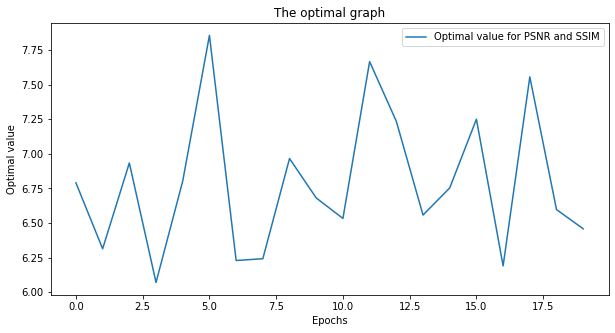

In [14]:
plt.figure(figsize=(10, 5))
plt.plot( Opt_diff, label='Optimal value for PSNR and SSIM')
plt.xlabel('Epochs')
plt.ylabel('Optimal value')
plt.title('The optimal graph of SR3')
plt.legend()
plt.show()

In [34]:
time_steps = 2000  # Use the same value you used during training
image_dims = (3, 256, 256)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
generator1 = DiffusionModel(time_steps=time_steps, image_dims=image_dims).to(device)
generator1.load_state_dict(torch.load('saved_models/ddpm_super_resolution.pth'))
generator1.eval()

Using device: cuda:0


DiffusionModel(
  (model): UNet(
    (e1): encoder_block(
      (conv): conv_block(
        (conv1): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (embedding): GammaEncoding(
          (linear): Linear(in_features=64, out_features=64, bias=True)
          (act): LeakyReLU(negative_slope=0.01)
        )
        (act): ReLU()
      )
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (e2): encoder_block(
      (conv): conv_block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 1

In [11]:
import torch
import os
from torchvision.utils import save_image

def save_sample_generated_images(generator, dataloader, high_res_dataloader, output_dir, device, num_samples=5, time_steps=2000):
    os.makedirs(output_dir, exist_ok=True)

    generator.eval()
    normal_count = 0
    pneumonia_count = 0
    
    with torch.no_grad():
        for i, ((low_res, labels), (high_res, _)) in enumerate(zip(dataloader, high_res_dataloader)):
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            
            # Generate the time step (t) for each image in the batch
            bs = low_res.size(0)
            ts = torch.randint(low=1, high=time_steps, size=(bs,)).to(device)
            gamma = generator.alpha_hats[ts].to(device)

            # Add noise to high-res images
            noisy_high_res, _ = generator.add_noise(high_res, ts)

            # Upsample low-res to match high-res dimensions
            low_res_upsampled = nn.functional.interpolate(low_res, size=(generator.img_size, generator.img_size), mode='bicubic', align_corners=False)

            # Concatenate low-res and noisy high-res
            x = torch.cat([low_res_upsampled, noisy_high_res], dim=1)

            # Generate high-resolution images
            gen_high_res = generator(x, gamma)

            # Clamp the generated image to [0, 1]
            gen_high_res = gen_high_res.clamp(0, 1)
            low_res = low_res.clamp(0, 1)
            high_res = high_res.clamp(0, 1)

            for j in range(low_res.size(0)):
                label = labels[j].item()
                if label == 0 and normal_count < num_samples:
                    label_dir = 'NORMAL'
                    normal_count += 1
                elif label == 1 and pneumonia_count < num_samples:
                    label_dir = 'PNEUMONIA'
                    pneumonia_count += 1
                else:
                    continue

                # Save the generated high-resolution image
                save_path_gen = os.path.join(output_dir, f"{label_dir}_generated_{normal_count if label == 0 else pneumonia_count}.png")
                save_image(gen_high_res[j], save_path_gen, normalize=True)

                # Save the original low-resolution image
                save_path_orig = os.path.join(output_dir, f"{label_dir}_original_{normal_count if label == 0 else pneumonia_count}.png")
                save_image(low_res[j], save_path_orig, normalize=True)

                # Save the original high-resolution image
                save_path_high = os.path.join(output_dir, f"{label_dir}_highres_{normal_count if label == 0 else pneumonia_count}.png")
                save_image(high_res[j], save_path_high, normalize=True)

                print(f"Saved {label_dir} generated image to {save_path_gen}")
                print(f"Saved {label_dir} original image to {save_path_orig}")
                print(f"Saved {label_dir} high-resolution image to {save_path_high}")
                
                if normal_count >= num_samples and pneumonia_count >= num_samples:
                    return

# Example usage
save_sample_generated_images(generator1, test_lowdataloader, test_highdataloader, 'Diff_image/samples', device, num_samples=5, time_steps=2000)


Saved NORMAL generated image to Diff_image/samples/NORMAL_generated_1.png
Saved NORMAL original image to Diff_image/samples/NORMAL_original_1.png
Saved NORMAL high-resolution image to Diff_image/samples/NORMAL_highres_1.png
Saved PNEUMONIA generated image to Diff_image/samples/PNEUMONIA_generated_1.png
Saved PNEUMONIA original image to Diff_image/samples/PNEUMONIA_original_1.png
Saved PNEUMONIA high-resolution image to Diff_image/samples/PNEUMONIA_highres_1.png
Saved PNEUMONIA generated image to Diff_image/samples/PNEUMONIA_generated_2.png
Saved PNEUMONIA original image to Diff_image/samples/PNEUMONIA_original_2.png
Saved PNEUMONIA high-resolution image to Diff_image/samples/PNEUMONIA_highres_2.png
Saved PNEUMONIA generated image to Diff_image/samples/PNEUMONIA_generated_3.png
Saved PNEUMONIA original image to Diff_image/samples/PNEUMONIA_original_3.png
Saved PNEUMONIA high-resolution image to Diff_image/samples/PNEUMONIA_highres_3.png
Saved PNEUMONIA generated image to Diff_image/samp

In [24]:
import torch
import os
from torchvision.utils import save_image



def save_generated_images(generator, dataloader, output_dir, device, time_steps=2000):
    os.makedirs(os.path.join(output_dir, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'PNEUMONIA'), exist_ok=True)

    generator.eval()
    
    with torch.no_grad():
        for i, (low_res, labels) in enumerate(dataloader):
            low_res = low_res.to(device)

            # Generate the time step (t) for each image in the batch
            bs = low_res.size(0)
            ts = torch.randint(low=1, high=time_steps, size=(bs,)).to(device)
            gamma = generator.alpha_hats[ts].to(device)

            # Generate high-resolution images
            # You need to upsample the low-res images to match the input size expected by the model
            low_res_upsampled = nn.functional.interpolate(low_res, size=(generator.image_dims[1], generator.image_dims[2]), mode='bicubic', align_corners=False)
            gen_high_res = generator(torch.cat([low_res_upsampled, low_res_upsampled], dim=1), gamma)

            for j in range(low_res.size(0)):
                label = labels[j].item()
                if label == 0:
                    label_dir = 'NORMAL'
                else:
                    label_dir = 'PNEUMONIA'
                gen_high_res_bw = gen_high_res[j].mean(dim=0, keepdim=True)  
                save_path = os.path.join(output_dir, label_dir, f"generated_{i*low_res.size(0)+j}.png")
                save_image(gen_high_res_bw, save_path, normalize=True)
                print(f"Saved image to {save_path}")

# Example usage
save_generated_images(generator1, train_lowdataloader, 'Diff image/train', device)
save_generated_images(generator1, test_lowdataloader, 'Diff image/test', device)
save_generated_images(generator1, val_lowdataloader, 'Diff image/val', device)


Saved image to Diff image/train/PNEUMONIA/generated_0.png
Saved image to Diff image/train/NORMAL/generated_1.png
Saved image to Diff image/train/NORMAL/generated_2.png
Saved image to Diff image/train/PNEUMONIA/generated_3.png
Saved image to Diff image/train/PNEUMONIA/generated_4.png
Saved image to Diff image/train/NORMAL/generated_5.png
Saved image to Diff image/train/PNEUMONIA/generated_6.png
Saved image to Diff image/train/PNEUMONIA/generated_7.png
Saved image to Diff image/train/PNEUMONIA/generated_8.png
Saved image to Diff image/train/PNEUMONIA/generated_9.png
Saved image to Diff image/train/NORMAL/generated_10.png
Saved image to Diff image/train/PNEUMONIA/generated_11.png
Saved image to Diff image/train/PNEUMONIA/generated_12.png
Saved image to Diff image/train/PNEUMONIA/generated_13.png
Saved image to Diff image/train/PNEUMONIA/generated_14.png
Saved image to Diff image/train/PNEUMONIA/generated_15.png
Saved image to Diff image/train/PNEUMONIA/generated_16.png
Saved image to Diff

Saved image to Diff image/train/PNEUMONIA/generated_140.png
Saved image to Diff image/train/NORMAL/generated_141.png
Saved image to Diff image/train/PNEUMONIA/generated_142.png
Saved image to Diff image/train/PNEUMONIA/generated_143.png
Saved image to Diff image/train/PNEUMONIA/generated_144.png
Saved image to Diff image/train/NORMAL/generated_145.png
Saved image to Diff image/train/PNEUMONIA/generated_146.png
Saved image to Diff image/train/PNEUMONIA/generated_147.png
Saved image to Diff image/train/PNEUMONIA/generated_148.png
Saved image to Diff image/train/PNEUMONIA/generated_149.png
Saved image to Diff image/train/PNEUMONIA/generated_150.png
Saved image to Diff image/train/PNEUMONIA/generated_151.png
Saved image to Diff image/train/NORMAL/generated_152.png
Saved image to Diff image/train/PNEUMONIA/generated_153.png
Saved image to Diff image/train/PNEUMONIA/generated_154.png
Saved image to Diff image/train/PNEUMONIA/generated_155.png
Saved image to Diff image/train/PNEUMONIA/generat

Saved image to Diff image/train/PNEUMONIA/generated_280.png
Saved image to Diff image/train/NORMAL/generated_281.png
Saved image to Diff image/train/NORMAL/generated_282.png
Saved image to Diff image/train/PNEUMONIA/generated_283.png
Saved image to Diff image/train/NORMAL/generated_284.png
Saved image to Diff image/train/PNEUMONIA/generated_285.png
Saved image to Diff image/train/PNEUMONIA/generated_286.png
Saved image to Diff image/train/PNEUMONIA/generated_287.png
Saved image to Diff image/train/PNEUMONIA/generated_288.png
Saved image to Diff image/train/PNEUMONIA/generated_289.png
Saved image to Diff image/train/PNEUMONIA/generated_290.png
Saved image to Diff image/train/NORMAL/generated_291.png
Saved image to Diff image/train/NORMAL/generated_292.png
Saved image to Diff image/train/PNEUMONIA/generated_293.png
Saved image to Diff image/train/NORMAL/generated_294.png
Saved image to Diff image/train/PNEUMONIA/generated_295.png
Saved image to Diff image/train/PNEUMONIA/generated_296.pn

Saved image to Diff image/train/PNEUMONIA/generated_419.png
Saved image to Diff image/train/PNEUMONIA/generated_420.png
Saved image to Diff image/train/PNEUMONIA/generated_421.png
Saved image to Diff image/train/NORMAL/generated_422.png
Saved image to Diff image/train/PNEUMONIA/generated_423.png
Saved image to Diff image/train/PNEUMONIA/generated_424.png
Saved image to Diff image/train/PNEUMONIA/generated_425.png
Saved image to Diff image/train/PNEUMONIA/generated_426.png
Saved image to Diff image/train/PNEUMONIA/generated_427.png
Saved image to Diff image/train/PNEUMONIA/generated_428.png
Saved image to Diff image/train/PNEUMONIA/generated_429.png
Saved image to Diff image/train/NORMAL/generated_430.png
Saved image to Diff image/train/PNEUMONIA/generated_431.png
Saved image to Diff image/train/PNEUMONIA/generated_432.png
Saved image to Diff image/train/PNEUMONIA/generated_433.png
Saved image to Diff image/train/PNEUMONIA/generated_434.png
Saved image to Diff image/train/PNEUMONIA/gene

Saved image to Diff image/train/PNEUMONIA/generated_559.png
Saved image to Diff image/train/PNEUMONIA/generated_560.png
Saved image to Diff image/train/NORMAL/generated_561.png
Saved image to Diff image/train/NORMAL/generated_562.png
Saved image to Diff image/train/PNEUMONIA/generated_563.png
Saved image to Diff image/train/PNEUMONIA/generated_564.png
Saved image to Diff image/train/PNEUMONIA/generated_565.png
Saved image to Diff image/train/PNEUMONIA/generated_566.png
Saved image to Diff image/train/NORMAL/generated_567.png
Saved image to Diff image/train/PNEUMONIA/generated_568.png
Saved image to Diff image/train/PNEUMONIA/generated_569.png
Saved image to Diff image/train/PNEUMONIA/generated_570.png
Saved image to Diff image/train/PNEUMONIA/generated_571.png
Saved image to Diff image/train/PNEUMONIA/generated_572.png
Saved image to Diff image/train/NORMAL/generated_573.png
Saved image to Diff image/train/PNEUMONIA/generated_574.png
Saved image to Diff image/train/NORMAL/generated_575

Saved image to Diff image/train/PNEUMONIA/generated_698.png
Saved image to Diff image/train/PNEUMONIA/generated_699.png
Saved image to Diff image/train/PNEUMONIA/generated_700.png
Saved image to Diff image/train/PNEUMONIA/generated_701.png
Saved image to Diff image/train/PNEUMONIA/generated_702.png
Saved image to Diff image/train/PNEUMONIA/generated_703.png
Saved image to Diff image/train/PNEUMONIA/generated_704.png
Saved image to Diff image/train/PNEUMONIA/generated_705.png
Saved image to Diff image/train/PNEUMONIA/generated_706.png
Saved image to Diff image/train/PNEUMONIA/generated_707.png
Saved image to Diff image/train/PNEUMONIA/generated_708.png
Saved image to Diff image/train/NORMAL/generated_709.png
Saved image to Diff image/train/PNEUMONIA/generated_710.png
Saved image to Diff image/train/PNEUMONIA/generated_711.png
Saved image to Diff image/train/PNEUMONIA/generated_712.png
Saved image to Diff image/train/PNEUMONIA/generated_713.png
Saved image to Diff image/train/PNEUMONIA/g

Saved image to Diff image/train/NORMAL/generated_838.png
Saved image to Diff image/train/PNEUMONIA/generated_839.png
Saved image to Diff image/train/PNEUMONIA/generated_840.png
Saved image to Diff image/train/PNEUMONIA/generated_841.png
Saved image to Diff image/train/PNEUMONIA/generated_842.png
Saved image to Diff image/train/NORMAL/generated_843.png
Saved image to Diff image/train/PNEUMONIA/generated_844.png
Saved image to Diff image/train/PNEUMONIA/generated_845.png
Saved image to Diff image/train/PNEUMONIA/generated_846.png
Saved image to Diff image/train/NORMAL/generated_847.png
Saved image to Diff image/train/NORMAL/generated_848.png
Saved image to Diff image/train/PNEUMONIA/generated_849.png
Saved image to Diff image/train/PNEUMONIA/generated_850.png
Saved image to Diff image/train/NORMAL/generated_851.png
Saved image to Diff image/train/NORMAL/generated_852.png
Saved image to Diff image/train/NORMAL/generated_853.png
Saved image to Diff image/train/NORMAL/generated_854.png
Save

Saved image to Diff image/train/PNEUMONIA/generated_977.png
Saved image to Diff image/train/PNEUMONIA/generated_978.png
Saved image to Diff image/train/PNEUMONIA/generated_979.png
Saved image to Diff image/train/PNEUMONIA/generated_980.png
Saved image to Diff image/train/PNEUMONIA/generated_981.png
Saved image to Diff image/train/PNEUMONIA/generated_982.png
Saved image to Diff image/train/PNEUMONIA/generated_983.png
Saved image to Diff image/train/PNEUMONIA/generated_984.png
Saved image to Diff image/train/PNEUMONIA/generated_985.png
Saved image to Diff image/train/PNEUMONIA/generated_986.png
Saved image to Diff image/train/NORMAL/generated_987.png
Saved image to Diff image/train/PNEUMONIA/generated_988.png
Saved image to Diff image/train/PNEUMONIA/generated_989.png
Saved image to Diff image/train/NORMAL/generated_990.png
Saved image to Diff image/train/PNEUMONIA/generated_991.png
Saved image to Diff image/train/NORMAL/generated_992.png
Saved image to Diff image/train/PNEUMONIA/generat

Saved image to Diff image/train/NORMAL/generated_1114.png
Saved image to Diff image/train/PNEUMONIA/generated_1115.png
Saved image to Diff image/train/PNEUMONIA/generated_1116.png
Saved image to Diff image/train/NORMAL/generated_1117.png
Saved image to Diff image/train/PNEUMONIA/generated_1118.png
Saved image to Diff image/train/PNEUMONIA/generated_1119.png
Saved image to Diff image/train/NORMAL/generated_1120.png
Saved image to Diff image/train/NORMAL/generated_1121.png
Saved image to Diff image/train/PNEUMONIA/generated_1122.png
Saved image to Diff image/train/NORMAL/generated_1123.png
Saved image to Diff image/train/PNEUMONIA/generated_1124.png
Saved image to Diff image/train/PNEUMONIA/generated_1125.png
Saved image to Diff image/train/PNEUMONIA/generated_1126.png
Saved image to Diff image/train/NORMAL/generated_1127.png
Saved image to Diff image/train/PNEUMONIA/generated_1128.png
Saved image to Diff image/train/PNEUMONIA/generated_1129.png
Saved image to Diff image/train/PNEUMONIA/

Saved image to Diff image/train/PNEUMONIA/generated_1251.png
Saved image to Diff image/train/PNEUMONIA/generated_1252.png
Saved image to Diff image/train/NORMAL/generated_1253.png
Saved image to Diff image/train/PNEUMONIA/generated_1254.png
Saved image to Diff image/train/NORMAL/generated_1255.png
Saved image to Diff image/train/PNEUMONIA/generated_1256.png
Saved image to Diff image/train/NORMAL/generated_1257.png
Saved image to Diff image/train/PNEUMONIA/generated_1258.png
Saved image to Diff image/train/PNEUMONIA/generated_1259.png
Saved image to Diff image/train/PNEUMONIA/generated_1260.png
Saved image to Diff image/train/PNEUMONIA/generated_1261.png
Saved image to Diff image/train/PNEUMONIA/generated_1262.png
Saved image to Diff image/train/PNEUMONIA/generated_1263.png
Saved image to Diff image/train/PNEUMONIA/generated_1264.png
Saved image to Diff image/train/PNEUMONIA/generated_1265.png
Saved image to Diff image/train/NORMAL/generated_1266.png
Saved image to Diff image/train/PNEU

Saved image to Diff image/train/NORMAL/generated_1389.png
Saved image to Diff image/train/PNEUMONIA/generated_1390.png
Saved image to Diff image/train/PNEUMONIA/generated_1391.png
Saved image to Diff image/train/PNEUMONIA/generated_1392.png
Saved image to Diff image/train/PNEUMONIA/generated_1393.png
Saved image to Diff image/train/PNEUMONIA/generated_1394.png
Saved image to Diff image/train/PNEUMONIA/generated_1395.png
Saved image to Diff image/train/PNEUMONIA/generated_1396.png
Saved image to Diff image/train/NORMAL/generated_1397.png
Saved image to Diff image/train/PNEUMONIA/generated_1398.png
Saved image to Diff image/train/PNEUMONIA/generated_1399.png
Saved image to Diff image/train/PNEUMONIA/generated_1400.png
Saved image to Diff image/train/PNEUMONIA/generated_1401.png
Saved image to Diff image/train/PNEUMONIA/generated_1402.png
Saved image to Diff image/train/PNEUMONIA/generated_1403.png
Saved image to Diff image/train/PNEUMONIA/generated_1404.png
Saved image to Diff image/trai

Saved image to Diff image/train/PNEUMONIA/generated_1528.png
Saved image to Diff image/train/PNEUMONIA/generated_1529.png
Saved image to Diff image/train/NORMAL/generated_1530.png
Saved image to Diff image/train/PNEUMONIA/generated_1531.png
Saved image to Diff image/train/PNEUMONIA/generated_1532.png
Saved image to Diff image/train/PNEUMONIA/generated_1533.png
Saved image to Diff image/train/PNEUMONIA/generated_1534.png
Saved image to Diff image/train/PNEUMONIA/generated_1535.png
Saved image to Diff image/train/PNEUMONIA/generated_1536.png
Saved image to Diff image/train/PNEUMONIA/generated_1537.png
Saved image to Diff image/train/PNEUMONIA/generated_1538.png
Saved image to Diff image/train/NORMAL/generated_1539.png
Saved image to Diff image/train/PNEUMONIA/generated_1540.png
Saved image to Diff image/train/PNEUMONIA/generated_1541.png
Saved image to Diff image/train/PNEUMONIA/generated_1542.png
Saved image to Diff image/train/NORMAL/generated_1543.png
Saved image to Diff image/train/P

Saved image to Diff image/train/PNEUMONIA/generated_1665.png
Saved image to Diff image/train/PNEUMONIA/generated_1666.png
Saved image to Diff image/train/PNEUMONIA/generated_1667.png
Saved image to Diff image/train/PNEUMONIA/generated_1668.png
Saved image to Diff image/train/PNEUMONIA/generated_1669.png
Saved image to Diff image/train/PNEUMONIA/generated_1670.png
Saved image to Diff image/train/PNEUMONIA/generated_1671.png
Saved image to Diff image/train/PNEUMONIA/generated_1672.png
Saved image to Diff image/train/NORMAL/generated_1673.png
Saved image to Diff image/train/NORMAL/generated_1674.png
Saved image to Diff image/train/PNEUMONIA/generated_1675.png
Saved image to Diff image/train/PNEUMONIA/generated_1676.png
Saved image to Diff image/train/PNEUMONIA/generated_1677.png
Saved image to Diff image/train/PNEUMONIA/generated_1678.png
Saved image to Diff image/train/NORMAL/generated_1679.png
Saved image to Diff image/train/NORMAL/generated_1680.png
Saved image to Diff image/train/PNEU

Saved image to Diff image/train/PNEUMONIA/generated_1803.png
Saved image to Diff image/train/PNEUMONIA/generated_1804.png
Saved image to Diff image/train/PNEUMONIA/generated_1805.png
Saved image to Diff image/train/NORMAL/generated_1806.png
Saved image to Diff image/train/NORMAL/generated_1807.png
Saved image to Diff image/train/PNEUMONIA/generated_1808.png
Saved image to Diff image/train/PNEUMONIA/generated_1809.png
Saved image to Diff image/train/NORMAL/generated_1810.png
Saved image to Diff image/train/PNEUMONIA/generated_1811.png
Saved image to Diff image/train/PNEUMONIA/generated_1812.png
Saved image to Diff image/train/NORMAL/generated_1813.png
Saved image to Diff image/train/PNEUMONIA/generated_1814.png
Saved image to Diff image/train/PNEUMONIA/generated_1815.png
Saved image to Diff image/train/PNEUMONIA/generated_1816.png
Saved image to Diff image/train/PNEUMONIA/generated_1817.png
Saved image to Diff image/train/PNEUMONIA/generated_1818.png
Saved image to Diff image/train/PNEU

Saved image to Diff image/train/PNEUMONIA/generated_1942.png
Saved image to Diff image/train/PNEUMONIA/generated_1943.png
Saved image to Diff image/train/PNEUMONIA/generated_1944.png
Saved image to Diff image/train/NORMAL/generated_1945.png
Saved image to Diff image/train/NORMAL/generated_1946.png
Saved image to Diff image/train/PNEUMONIA/generated_1947.png
Saved image to Diff image/train/PNEUMONIA/generated_1948.png
Saved image to Diff image/train/PNEUMONIA/generated_1949.png
Saved image to Diff image/train/PNEUMONIA/generated_1950.png
Saved image to Diff image/train/NORMAL/generated_1951.png
Saved image to Diff image/train/PNEUMONIA/generated_1952.png
Saved image to Diff image/train/PNEUMONIA/generated_1953.png
Saved image to Diff image/train/PNEUMONIA/generated_1954.png
Saved image to Diff image/train/PNEUMONIA/generated_1955.png
Saved image to Diff image/train/PNEUMONIA/generated_1956.png
Saved image to Diff image/train/PNEUMONIA/generated_1957.png
Saved image to Diff image/train/P

Saved image to Diff image/train/PNEUMONIA/generated_2080.png
Saved image to Diff image/train/PNEUMONIA/generated_2081.png
Saved image to Diff image/train/PNEUMONIA/generated_2082.png
Saved image to Diff image/train/PNEUMONIA/generated_2083.png
Saved image to Diff image/train/PNEUMONIA/generated_2084.png
Saved image to Diff image/train/NORMAL/generated_2085.png
Saved image to Diff image/train/PNEUMONIA/generated_2086.png
Saved image to Diff image/train/PNEUMONIA/generated_2087.png
Saved image to Diff image/train/PNEUMONIA/generated_2088.png
Saved image to Diff image/train/PNEUMONIA/generated_2089.png
Saved image to Diff image/train/PNEUMONIA/generated_2090.png
Saved image to Diff image/train/PNEUMONIA/generated_2091.png
Saved image to Diff image/train/NORMAL/generated_2092.png
Saved image to Diff image/train/NORMAL/generated_2093.png
Saved image to Diff image/train/NORMAL/generated_2094.png
Saved image to Diff image/train/PNEUMONIA/generated_2095.png
Saved image to Diff image/train/PNEU

Saved image to Diff image/train/NORMAL/generated_2217.png
Saved image to Diff image/train/PNEUMONIA/generated_2218.png
Saved image to Diff image/train/PNEUMONIA/generated_2219.png
Saved image to Diff image/train/PNEUMONIA/generated_2220.png
Saved image to Diff image/train/PNEUMONIA/generated_2221.png
Saved image to Diff image/train/NORMAL/generated_2222.png
Saved image to Diff image/train/PNEUMONIA/generated_2223.png
Saved image to Diff image/train/PNEUMONIA/generated_2224.png
Saved image to Diff image/train/PNEUMONIA/generated_2225.png
Saved image to Diff image/train/PNEUMONIA/generated_2226.png
Saved image to Diff image/train/PNEUMONIA/generated_2227.png
Saved image to Diff image/train/NORMAL/generated_2228.png
Saved image to Diff image/train/PNEUMONIA/generated_2229.png
Saved image to Diff image/train/PNEUMONIA/generated_2230.png
Saved image to Diff image/train/PNEUMONIA/generated_2231.png
Saved image to Diff image/train/PNEUMONIA/generated_2232.png
Saved image to Diff image/train/P

Saved image to Diff image/train/PNEUMONIA/generated_2354.png
Saved image to Diff image/train/PNEUMONIA/generated_2355.png
Saved image to Diff image/train/NORMAL/generated_2356.png
Saved image to Diff image/train/PNEUMONIA/generated_2357.png
Saved image to Diff image/train/NORMAL/generated_2358.png
Saved image to Diff image/train/NORMAL/generated_2359.png
Saved image to Diff image/train/PNEUMONIA/generated_2360.png
Saved image to Diff image/train/PNEUMONIA/generated_2361.png
Saved image to Diff image/train/PNEUMONIA/generated_2362.png
Saved image to Diff image/train/PNEUMONIA/generated_2363.png
Saved image to Diff image/train/PNEUMONIA/generated_2364.png
Saved image to Diff image/train/PNEUMONIA/generated_2365.png
Saved image to Diff image/train/PNEUMONIA/generated_2366.png
Saved image to Diff image/train/PNEUMONIA/generated_2367.png
Saved image to Diff image/train/NORMAL/generated_2368.png
Saved image to Diff image/train/PNEUMONIA/generated_2369.png
Saved image to Diff image/train/NORM

Saved image to Diff image/train/PNEUMONIA/generated_2493.png
Saved image to Diff image/train/NORMAL/generated_2494.png
Saved image to Diff image/train/PNEUMONIA/generated_2495.png
Saved image to Diff image/train/PNEUMONIA/generated_2496.png
Saved image to Diff image/train/PNEUMONIA/generated_2497.png
Saved image to Diff image/train/PNEUMONIA/generated_2498.png
Saved image to Diff image/train/NORMAL/generated_2499.png
Saved image to Diff image/train/PNEUMONIA/generated_2500.png
Saved image to Diff image/train/PNEUMONIA/generated_2501.png
Saved image to Diff image/train/PNEUMONIA/generated_2502.png
Saved image to Diff image/train/PNEUMONIA/generated_2503.png
Saved image to Diff image/train/PNEUMONIA/generated_2504.png
Saved image to Diff image/train/PNEUMONIA/generated_2505.png
Saved image to Diff image/train/PNEUMONIA/generated_2506.png
Saved image to Diff image/train/PNEUMONIA/generated_2507.png
Saved image to Diff image/train/NORMAL/generated_2508.png
Saved image to Diff image/train/N

Saved image to Diff image/train/PNEUMONIA/generated_2631.png
Saved image to Diff image/train/PNEUMONIA/generated_2632.png
Saved image to Diff image/train/PNEUMONIA/generated_2633.png
Saved image to Diff image/train/NORMAL/generated_2634.png
Saved image to Diff image/train/PNEUMONIA/generated_2635.png
Saved image to Diff image/train/PNEUMONIA/generated_2636.png
Saved image to Diff image/train/PNEUMONIA/generated_2637.png
Saved image to Diff image/train/PNEUMONIA/generated_2638.png
Saved image to Diff image/train/NORMAL/generated_2639.png
Saved image to Diff image/train/NORMAL/generated_2640.png
Saved image to Diff image/train/PNEUMONIA/generated_2641.png
Saved image to Diff image/train/PNEUMONIA/generated_2642.png
Saved image to Diff image/train/PNEUMONIA/generated_2643.png
Saved image to Diff image/train/NORMAL/generated_2644.png
Saved image to Diff image/train/PNEUMONIA/generated_2645.png
Saved image to Diff image/train/NORMAL/generated_2646.png
Saved image to Diff image/train/NORMAL/

Saved image to Diff image/train/PNEUMONIA/generated_2768.png
Saved image to Diff image/train/PNEUMONIA/generated_2769.png
Saved image to Diff image/train/PNEUMONIA/generated_2770.png
Saved image to Diff image/train/NORMAL/generated_2771.png
Saved image to Diff image/train/PNEUMONIA/generated_2772.png
Saved image to Diff image/train/PNEUMONIA/generated_2773.png
Saved image to Diff image/train/PNEUMONIA/generated_2774.png
Saved image to Diff image/train/NORMAL/generated_2775.png
Saved image to Diff image/train/NORMAL/generated_2776.png
Saved image to Diff image/train/PNEUMONIA/generated_2777.png
Saved image to Diff image/train/NORMAL/generated_2778.png
Saved image to Diff image/train/NORMAL/generated_2779.png
Saved image to Diff image/train/PNEUMONIA/generated_2780.png
Saved image to Diff image/train/PNEUMONIA/generated_2781.png
Saved image to Diff image/train/PNEUMONIA/generated_2782.png
Saved image to Diff image/train/NORMAL/generated_2783.png
Saved image to Diff image/train/PNEUMONIA/

Saved image to Diff image/train/PNEUMONIA/generated_2905.png
Saved image to Diff image/train/NORMAL/generated_2906.png
Saved image to Diff image/train/NORMAL/generated_2907.png
Saved image to Diff image/train/NORMAL/generated_2908.png
Saved image to Diff image/train/PNEUMONIA/generated_2909.png
Saved image to Diff image/train/PNEUMONIA/generated_2910.png
Saved image to Diff image/train/PNEUMONIA/generated_2911.png
Saved image to Diff image/train/PNEUMONIA/generated_2912.png
Saved image to Diff image/train/PNEUMONIA/generated_2913.png
Saved image to Diff image/train/PNEUMONIA/generated_2914.png
Saved image to Diff image/train/PNEUMONIA/generated_2915.png
Saved image to Diff image/train/PNEUMONIA/generated_2916.png
Saved image to Diff image/train/NORMAL/generated_2917.png
Saved image to Diff image/train/PNEUMONIA/generated_2918.png
Saved image to Diff image/train/PNEUMONIA/generated_2919.png
Saved image to Diff image/train/PNEUMONIA/generated_2920.png
Saved image to Diff image/train/PNEU

Saved image to Diff image/train/PNEUMONIA/generated_3043.png
Saved image to Diff image/train/PNEUMONIA/generated_3044.png
Saved image to Diff image/train/PNEUMONIA/generated_3045.png
Saved image to Diff image/train/PNEUMONIA/generated_3046.png
Saved image to Diff image/train/PNEUMONIA/generated_3047.png
Saved image to Diff image/train/PNEUMONIA/generated_3048.png
Saved image to Diff image/train/PNEUMONIA/generated_3049.png
Saved image to Diff image/train/PNEUMONIA/generated_3050.png
Saved image to Diff image/train/PNEUMONIA/generated_3051.png
Saved image to Diff image/train/NORMAL/generated_3052.png
Saved image to Diff image/train/PNEUMONIA/generated_3053.png
Saved image to Diff image/train/PNEUMONIA/generated_3054.png
Saved image to Diff image/train/PNEUMONIA/generated_3055.png
Saved image to Diff image/train/PNEUMONIA/generated_3056.png
Saved image to Diff image/train/PNEUMONIA/generated_3057.png
Saved image to Diff image/train/NORMAL/generated_3058.png
Saved image to Diff image/trai

Saved image to Diff image/train/PNEUMONIA/generated_3180.png
Saved image to Diff image/train/PNEUMONIA/generated_3181.png
Saved image to Diff image/train/PNEUMONIA/generated_3182.png
Saved image to Diff image/train/NORMAL/generated_3183.png
Saved image to Diff image/train/NORMAL/generated_3184.png
Saved image to Diff image/train/NORMAL/generated_3185.png
Saved image to Diff image/train/PNEUMONIA/generated_3186.png
Saved image to Diff image/train/PNEUMONIA/generated_3187.png
Saved image to Diff image/train/PNEUMONIA/generated_3188.png
Saved image to Diff image/train/PNEUMONIA/generated_3189.png
Saved image to Diff image/train/PNEUMONIA/generated_3190.png
Saved image to Diff image/train/NORMAL/generated_3191.png
Saved image to Diff image/train/NORMAL/generated_3192.png
Saved image to Diff image/train/PNEUMONIA/generated_3193.png
Saved image to Diff image/train/PNEUMONIA/generated_3194.png
Saved image to Diff image/train/NORMAL/generated_3195.png
Saved image to Diff image/train/PNEUMONIA/

Saved image to Diff image/train/PNEUMONIA/generated_3316.png
Saved image to Diff image/train/NORMAL/generated_3317.png
Saved image to Diff image/train/NORMAL/generated_3318.png
Saved image to Diff image/train/PNEUMONIA/generated_3319.png
Saved image to Diff image/train/PNEUMONIA/generated_3320.png
Saved image to Diff image/train/NORMAL/generated_3321.png
Saved image to Diff image/train/NORMAL/generated_3322.png
Saved image to Diff image/train/PNEUMONIA/generated_3323.png
Saved image to Diff image/train/PNEUMONIA/generated_3324.png
Saved image to Diff image/train/NORMAL/generated_3325.png
Saved image to Diff image/train/PNEUMONIA/generated_3326.png
Saved image to Diff image/train/NORMAL/generated_3327.png
Saved image to Diff image/train/NORMAL/generated_3328.png
Saved image to Diff image/train/PNEUMONIA/generated_3329.png
Saved image to Diff image/train/PNEUMONIA/generated_3330.png
Saved image to Diff image/train/NORMAL/generated_3331.png
Saved image to Diff image/train/PNEUMONIA/genera

Saved image to Diff image/train/NORMAL/generated_3455.png
Saved image to Diff image/train/PNEUMONIA/generated_3456.png
Saved image to Diff image/train/PNEUMONIA/generated_3457.png
Saved image to Diff image/train/PNEUMONIA/generated_3458.png
Saved image to Diff image/train/NORMAL/generated_3459.png
Saved image to Diff image/train/NORMAL/generated_3460.png
Saved image to Diff image/train/NORMAL/generated_3461.png
Saved image to Diff image/train/NORMAL/generated_3462.png
Saved image to Diff image/train/PNEUMONIA/generated_3463.png
Saved image to Diff image/train/PNEUMONIA/generated_3464.png
Saved image to Diff image/train/NORMAL/generated_3465.png
Saved image to Diff image/train/NORMAL/generated_3466.png
Saved image to Diff image/train/PNEUMONIA/generated_3467.png
Saved image to Diff image/train/NORMAL/generated_3468.png
Saved image to Diff image/train/PNEUMONIA/generated_3469.png
Saved image to Diff image/train/NORMAL/generated_3470.png
Saved image to Diff image/train/PNEUMONIA/generated

Saved image to Diff image/train/PNEUMONIA/generated_3593.png
Saved image to Diff image/train/PNEUMONIA/generated_3594.png
Saved image to Diff image/train/PNEUMONIA/generated_3595.png
Saved image to Diff image/train/PNEUMONIA/generated_3596.png
Saved image to Diff image/train/NORMAL/generated_3597.png
Saved image to Diff image/train/PNEUMONIA/generated_3598.png
Saved image to Diff image/train/NORMAL/generated_3599.png
Saved image to Diff image/train/PNEUMONIA/generated_3600.png
Saved image to Diff image/train/PNEUMONIA/generated_3601.png
Saved image to Diff image/train/PNEUMONIA/generated_3602.png
Saved image to Diff image/train/PNEUMONIA/generated_3603.png
Saved image to Diff image/train/PNEUMONIA/generated_3604.png
Saved image to Diff image/train/PNEUMONIA/generated_3605.png
Saved image to Diff image/train/PNEUMONIA/generated_3606.png
Saved image to Diff image/train/PNEUMONIA/generated_3607.png
Saved image to Diff image/train/PNEUMONIA/generated_3608.png
Saved image to Diff image/trai

Saved image to Diff image/train/PNEUMONIA/generated_3731.png
Saved image to Diff image/train/PNEUMONIA/generated_3732.png
Saved image to Diff image/train/PNEUMONIA/generated_3733.png
Saved image to Diff image/train/PNEUMONIA/generated_3734.png
Saved image to Diff image/train/PNEUMONIA/generated_3735.png
Saved image to Diff image/train/PNEUMONIA/generated_3736.png
Saved image to Diff image/train/PNEUMONIA/generated_3737.png
Saved image to Diff image/train/PNEUMONIA/generated_3738.png
Saved image to Diff image/train/PNEUMONIA/generated_3739.png
Saved image to Diff image/train/PNEUMONIA/generated_3740.png
Saved image to Diff image/train/PNEUMONIA/generated_3741.png
Saved image to Diff image/train/PNEUMONIA/generated_3742.png
Saved image to Diff image/train/NORMAL/generated_3743.png
Saved image to Diff image/train/PNEUMONIA/generated_3744.png
Saved image to Diff image/train/PNEUMONIA/generated_3745.png
Saved image to Diff image/train/PNEUMONIA/generated_3746.png
Saved image to Diff image/t

Saved image to Diff image/train/PNEUMONIA/generated_3870.png
Saved image to Diff image/train/PNEUMONIA/generated_3871.png
Saved image to Diff image/train/NORMAL/generated_3872.png
Saved image to Diff image/train/PNEUMONIA/generated_3873.png
Saved image to Diff image/train/NORMAL/generated_3874.png
Saved image to Diff image/train/PNEUMONIA/generated_3875.png
Saved image to Diff image/train/PNEUMONIA/generated_3876.png
Saved image to Diff image/train/PNEUMONIA/generated_3877.png
Saved image to Diff image/train/PNEUMONIA/generated_3878.png
Saved image to Diff image/train/PNEUMONIA/generated_3879.png
Saved image to Diff image/train/PNEUMONIA/generated_3880.png
Saved image to Diff image/train/PNEUMONIA/generated_3881.png
Saved image to Diff image/train/PNEUMONIA/generated_3882.png
Saved image to Diff image/train/PNEUMONIA/generated_3883.png
Saved image to Diff image/train/PNEUMONIA/generated_3884.png
Saved image to Diff image/train/PNEUMONIA/generated_3885.png
Saved image to Diff image/trai

Saved image to Diff image/train/NORMAL/generated_4007.png
Saved image to Diff image/train/PNEUMONIA/generated_4008.png
Saved image to Diff image/train/PNEUMONIA/generated_4009.png
Saved image to Diff image/train/PNEUMONIA/generated_4010.png
Saved image to Diff image/train/PNEUMONIA/generated_4011.png
Saved image to Diff image/train/NORMAL/generated_4012.png
Saved image to Diff image/train/NORMAL/generated_4013.png
Saved image to Diff image/train/PNEUMONIA/generated_4014.png
Saved image to Diff image/train/NORMAL/generated_4015.png
Saved image to Diff image/train/PNEUMONIA/generated_4016.png
Saved image to Diff image/train/NORMAL/generated_4017.png
Saved image to Diff image/train/PNEUMONIA/generated_4018.png
Saved image to Diff image/train/PNEUMONIA/generated_4019.png
Saved image to Diff image/train/PNEUMONIA/generated_4020.png
Saved image to Diff image/train/PNEUMONIA/generated_4021.png
Saved image to Diff image/train/NORMAL/generated_4022.png
Saved image to Diff image/train/PNEUMONIA/

Saved image to Diff image/train/PNEUMONIA/generated_4143.png
Saved image to Diff image/train/PNEUMONIA/generated_4144.png
Saved image to Diff image/train/PNEUMONIA/generated_4145.png
Saved image to Diff image/train/PNEUMONIA/generated_4146.png
Saved image to Diff image/train/PNEUMONIA/generated_4147.png
Saved image to Diff image/train/NORMAL/generated_4148.png
Saved image to Diff image/train/PNEUMONIA/generated_4149.png
Saved image to Diff image/train/PNEUMONIA/generated_4150.png
Saved image to Diff image/train/PNEUMONIA/generated_4151.png
Saved image to Diff image/train/PNEUMONIA/generated_4152.png
Saved image to Diff image/train/PNEUMONIA/generated_4153.png
Saved image to Diff image/train/PNEUMONIA/generated_4154.png
Saved image to Diff image/train/PNEUMONIA/generated_4155.png
Saved image to Diff image/train/PNEUMONIA/generated_4156.png
Saved image to Diff image/train/PNEUMONIA/generated_4157.png
Saved image to Diff image/train/PNEUMONIA/generated_4158.png
Saved image to Diff image/t

Saved image to Diff image/train/NORMAL/generated_4280.png
Saved image to Diff image/train/PNEUMONIA/generated_4281.png
Saved image to Diff image/train/PNEUMONIA/generated_4282.png
Saved image to Diff image/train/PNEUMONIA/generated_4283.png
Saved image to Diff image/train/PNEUMONIA/generated_4284.png
Saved image to Diff image/train/PNEUMONIA/generated_4285.png
Saved image to Diff image/train/PNEUMONIA/generated_4286.png
Saved image to Diff image/train/PNEUMONIA/generated_4287.png
Saved image to Diff image/train/PNEUMONIA/generated_4288.png
Saved image to Diff image/train/PNEUMONIA/generated_4289.png
Saved image to Diff image/train/NORMAL/generated_4290.png
Saved image to Diff image/train/PNEUMONIA/generated_4291.png
Saved image to Diff image/train/PNEUMONIA/generated_4292.png
Saved image to Diff image/train/PNEUMONIA/generated_4293.png
Saved image to Diff image/train/PNEUMONIA/generated_4294.png
Saved image to Diff image/train/PNEUMONIA/generated_4295.png
Saved image to Diff image/trai

Saved image to Diff image/train/PNEUMONIA/generated_4417.png
Saved image to Diff image/train/PNEUMONIA/generated_4418.png
Saved image to Diff image/train/PNEUMONIA/generated_4419.png
Saved image to Diff image/train/PNEUMONIA/generated_4420.png
Saved image to Diff image/train/NORMAL/generated_4421.png
Saved image to Diff image/train/NORMAL/generated_4422.png
Saved image to Diff image/train/NORMAL/generated_4423.png
Saved image to Diff image/train/PNEUMONIA/generated_4424.png
Saved image to Diff image/train/PNEUMONIA/generated_4425.png
Saved image to Diff image/train/PNEUMONIA/generated_4426.png
Saved image to Diff image/train/PNEUMONIA/generated_4427.png
Saved image to Diff image/train/PNEUMONIA/generated_4428.png
Saved image to Diff image/train/NORMAL/generated_4429.png
Saved image to Diff image/train/PNEUMONIA/generated_4430.png
Saved image to Diff image/train/PNEUMONIA/generated_4431.png
Saved image to Diff image/train/PNEUMONIA/generated_4432.png
Saved image to Diff image/train/PNEU

Saved image to Diff image/train/PNEUMONIA/generated_4555.png
Saved image to Diff image/train/PNEUMONIA/generated_4556.png
Saved image to Diff image/train/PNEUMONIA/generated_4557.png
Saved image to Diff image/train/PNEUMONIA/generated_4558.png
Saved image to Diff image/train/PNEUMONIA/generated_4559.png
Saved image to Diff image/train/PNEUMONIA/generated_4560.png
Saved image to Diff image/train/PNEUMONIA/generated_4561.png
Saved image to Diff image/train/PNEUMONIA/generated_4562.png
Saved image to Diff image/train/PNEUMONIA/generated_4563.png
Saved image to Diff image/train/NORMAL/generated_4564.png
Saved image to Diff image/train/PNEUMONIA/generated_4565.png
Saved image to Diff image/train/PNEUMONIA/generated_4566.png
Saved image to Diff image/train/PNEUMONIA/generated_4567.png
Saved image to Diff image/train/PNEUMONIA/generated_4568.png
Saved image to Diff image/train/PNEUMONIA/generated_4569.png
Saved image to Diff image/train/PNEUMONIA/generated_4570.png
Saved image to Diff image/t

Saved image to Diff image/train/PNEUMONIA/generated_4692.png
Saved image to Diff image/train/PNEUMONIA/generated_4693.png
Saved image to Diff image/train/NORMAL/generated_4694.png
Saved image to Diff image/train/PNEUMONIA/generated_4695.png
Saved image to Diff image/train/PNEUMONIA/generated_4696.png
Saved image to Diff image/train/NORMAL/generated_4697.png
Saved image to Diff image/train/NORMAL/generated_4698.png
Saved image to Diff image/train/PNEUMONIA/generated_4699.png
Saved image to Diff image/train/PNEUMONIA/generated_4700.png
Saved image to Diff image/train/PNEUMONIA/generated_4701.png
Saved image to Diff image/train/PNEUMONIA/generated_4702.png
Saved image to Diff image/train/PNEUMONIA/generated_4703.png
Saved image to Diff image/train/NORMAL/generated_4704.png
Saved image to Diff image/train/PNEUMONIA/generated_4705.png
Saved image to Diff image/train/PNEUMONIA/generated_4706.png
Saved image to Diff image/train/NORMAL/generated_4707.png
Saved image to Diff image/train/PNEUMON

Saved image to Diff image/train/NORMAL/generated_4829.png
Saved image to Diff image/train/NORMAL/generated_4830.png
Saved image to Diff image/train/NORMAL/generated_4831.png
Saved image to Diff image/train/PNEUMONIA/generated_4832.png
Saved image to Diff image/train/PNEUMONIA/generated_4833.png
Saved image to Diff image/train/PNEUMONIA/generated_4834.png
Saved image to Diff image/train/PNEUMONIA/generated_4835.png
Saved image to Diff image/train/PNEUMONIA/generated_4836.png
Saved image to Diff image/train/PNEUMONIA/generated_4837.png
Saved image to Diff image/train/PNEUMONIA/generated_4838.png
Saved image to Diff image/train/PNEUMONIA/generated_4839.png
Saved image to Diff image/train/PNEUMONIA/generated_4840.png
Saved image to Diff image/train/PNEUMONIA/generated_4841.png
Saved image to Diff image/train/PNEUMONIA/generated_4842.png
Saved image to Diff image/train/PNEUMONIA/generated_4843.png
Saved image to Diff image/train/PNEUMONIA/generated_4844.png
Saved image to Diff image/train/P

Saved image to Diff image/train/NORMAL/generated_4967.png
Saved image to Diff image/train/PNEUMONIA/generated_4968.png
Saved image to Diff image/train/PNEUMONIA/generated_4969.png
Saved image to Diff image/train/PNEUMONIA/generated_4970.png
Saved image to Diff image/train/NORMAL/generated_4971.png
Saved image to Diff image/train/PNEUMONIA/generated_4972.png
Saved image to Diff image/train/PNEUMONIA/generated_4973.png
Saved image to Diff image/train/PNEUMONIA/generated_4974.png
Saved image to Diff image/train/PNEUMONIA/generated_4975.png
Saved image to Diff image/train/PNEUMONIA/generated_4976.png
Saved image to Diff image/train/PNEUMONIA/generated_4977.png
Saved image to Diff image/train/NORMAL/generated_4978.png
Saved image to Diff image/train/NORMAL/generated_4979.png
Saved image to Diff image/train/NORMAL/generated_4980.png
Saved image to Diff image/train/PNEUMONIA/generated_4981.png
Saved image to Diff image/train/NORMAL/generated_4982.png
Saved image to Diff image/train/PNEUMONIA/

Saved image to Diff image/train/NORMAL/generated_5103.png
Saved image to Diff image/train/PNEUMONIA/generated_5104.png
Saved image to Diff image/train/PNEUMONIA/generated_5105.png
Saved image to Diff image/train/PNEUMONIA/generated_5106.png
Saved image to Diff image/train/NORMAL/generated_5107.png
Saved image to Diff image/train/NORMAL/generated_5108.png
Saved image to Diff image/train/PNEUMONIA/generated_5109.png
Saved image to Diff image/train/NORMAL/generated_5110.png
Saved image to Diff image/train/PNEUMONIA/generated_5111.png
Saved image to Diff image/train/PNEUMONIA/generated_5112.png
Saved image to Diff image/train/PNEUMONIA/generated_5113.png
Saved image to Diff image/train/PNEUMONIA/generated_5114.png
Saved image to Diff image/train/PNEUMONIA/generated_5115.png
Saved image to Diff image/train/PNEUMONIA/generated_5116.png
Saved image to Diff image/train/PNEUMONIA/generated_5117.png
Saved image to Diff image/train/PNEUMONIA/generated_5118.png
Saved image to Diff image/train/NORM

Saved image to Diff image/test/PNEUMONIA/generated_26.png
Saved image to Diff image/test/PNEUMONIA/generated_27.png
Saved image to Diff image/test/PNEUMONIA/generated_28.png
Saved image to Diff image/test/PNEUMONIA/generated_29.png
Saved image to Diff image/test/PNEUMONIA/generated_30.png
Saved image to Diff image/test/PNEUMONIA/generated_31.png
Saved image to Diff image/test/PNEUMONIA/generated_32.png
Saved image to Diff image/test/PNEUMONIA/generated_33.png
Saved image to Diff image/test/NORMAL/generated_34.png
Saved image to Diff image/test/PNEUMONIA/generated_35.png
Saved image to Diff image/test/NORMAL/generated_36.png
Saved image to Diff image/test/NORMAL/generated_37.png
Saved image to Diff image/test/PNEUMONIA/generated_38.png
Saved image to Diff image/test/NORMAL/generated_39.png
Saved image to Diff image/test/PNEUMONIA/generated_40.png
Saved image to Diff image/test/PNEUMONIA/generated_41.png
Saved image to Diff image/test/NORMAL/generated_42.png
Saved image to Diff image/tes

Saved image to Diff image/test/NORMAL/generated_170.png
Saved image to Diff image/test/NORMAL/generated_171.png
Saved image to Diff image/test/NORMAL/generated_172.png
Saved image to Diff image/test/NORMAL/generated_173.png
Saved image to Diff image/test/PNEUMONIA/generated_174.png
Saved image to Diff image/test/NORMAL/generated_175.png
Saved image to Diff image/test/PNEUMONIA/generated_176.png
Saved image to Diff image/test/NORMAL/generated_177.png
Saved image to Diff image/test/PNEUMONIA/generated_178.png
Saved image to Diff image/test/PNEUMONIA/generated_179.png
Saved image to Diff image/test/NORMAL/generated_180.png
Saved image to Diff image/test/PNEUMONIA/generated_181.png
Saved image to Diff image/test/PNEUMONIA/generated_182.png
Saved image to Diff image/test/PNEUMONIA/generated_183.png
Saved image to Diff image/test/NORMAL/generated_184.png
Saved image to Diff image/test/NORMAL/generated_185.png
Saved image to Diff image/test/PNEUMONIA/generated_186.png
Saved image to Diff imag

Saved image to Diff image/test/PNEUMONIA/generated_312.png
Saved image to Diff image/test/NORMAL/generated_313.png
Saved image to Diff image/test/PNEUMONIA/generated_314.png
Saved image to Diff image/test/NORMAL/generated_315.png
Saved image to Diff image/test/PNEUMONIA/generated_316.png
Saved image to Diff image/test/NORMAL/generated_317.png
Saved image to Diff image/test/PNEUMONIA/generated_318.png
Saved image to Diff image/test/PNEUMONIA/generated_319.png
Saved image to Diff image/test/PNEUMONIA/generated_320.png
Saved image to Diff image/test/NORMAL/generated_321.png
Saved image to Diff image/test/NORMAL/generated_322.png
Saved image to Diff image/test/PNEUMONIA/generated_323.png
Saved image to Diff image/test/NORMAL/generated_324.png
Saved image to Diff image/test/PNEUMONIA/generated_325.png
Saved image to Diff image/test/PNEUMONIA/generated_326.png
Saved image to Diff image/test/PNEUMONIA/generated_327.png
Saved image to Diff image/test/PNEUMONIA/generated_328.png
Saved image to 

Saved image to Diff image/test/NORMAL/generated_454.png
Saved image to Diff image/test/PNEUMONIA/generated_455.png
Saved image to Diff image/test/PNEUMONIA/generated_456.png
Saved image to Diff image/test/PNEUMONIA/generated_457.png
Saved image to Diff image/test/PNEUMONIA/generated_458.png
Saved image to Diff image/test/PNEUMONIA/generated_459.png
Saved image to Diff image/test/NORMAL/generated_460.png
Saved image to Diff image/test/PNEUMONIA/generated_461.png
Saved image to Diff image/test/NORMAL/generated_462.png
Saved image to Diff image/test/NORMAL/generated_463.png
Saved image to Diff image/test/NORMAL/generated_464.png
Saved image to Diff image/test/PNEUMONIA/generated_465.png
Saved image to Diff image/test/PNEUMONIA/generated_466.png
Saved image to Diff image/test/PNEUMONIA/generated_467.png
Saved image to Diff image/test/PNEUMONIA/generated_468.png
Saved image to Diff image/test/NORMAL/generated_469.png
Saved image to Diff image/test/NORMAL/generated_470.png
Saved image to Dif

Saved image to Diff image/test/PNEUMONIA/generated_598.png
Saved image to Diff image/test/NORMAL/generated_599.png
Saved image to Diff image/test/PNEUMONIA/generated_600.png
Saved image to Diff image/test/PNEUMONIA/generated_601.png
Saved image to Diff image/test/PNEUMONIA/generated_602.png
Saved image to Diff image/test/PNEUMONIA/generated_603.png
Saved image to Diff image/test/PNEUMONIA/generated_604.png
Saved image to Diff image/test/PNEUMONIA/generated_605.png
Saved image to Diff image/test/PNEUMONIA/generated_606.png
Saved image to Diff image/test/PNEUMONIA/generated_607.png
Saved image to Diff image/test/PNEUMONIA/generated_608.png
Saved image to Diff image/test/PNEUMONIA/generated_609.png
Saved image to Diff image/test/NORMAL/generated_610.png
Saved image to Diff image/test/PNEUMONIA/generated_611.png
Saved image to Diff image/test/PNEUMONIA/generated_612.png
Saved image to Diff image/test/PNEUMONIA/generated_613.png
Saved image to Diff image/test/NORMAL/generated_614.png
Saved 

## Saved sample image for SRGAN and SR3

In [ ]:
import torch
import os
from torchvision.utils import save_image

def save_sample_images(generator_sr3, generator_srgan, dataloader, high_res_dataloader, output_dir, device, time_steps=2000, num_images=15):
    os.makedirs(output_dir, exist_ok=True)
    
    normal_count = 0
    pneumonia_count = 0
    
    generator_sr3.eval()
    generator_srgan.eval()

    with torch.no_grad():
        for i, ((low_res, labels), (high_res, _)) in enumerate(zip(dataloader, high_res_dataloader)):
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            
            # For SR3
            bs = low_res.size(0)
            ts = torch.randint(low=1, high=time_steps, size=(bs,)).to(device)
            gamma = generator_sr3.alpha_hats[ts].to(device)
            #noisy_high_res, _ = generator_sr3.add_noise(high_res, ts)
            low_res_upsampled_sr3 = nn.functional.interpolate(low_res, size=(generator_sr3.image_dims[1], generator_sr3.image_dims[2]), mode='bicubic', align_corners=False)
            x_sr3 = torch.cat([low_res_upsampled_sr3, low_res_upsampled_sr3], dim=1)
            gen_high_res_sr3 = generator_sr3(x_sr3, gamma)

            # For SRGAN
            gen_high_res_srgan = generator_srgan(low_res)

            # Clamp images
            gen_high_res_sr3 = gen_high_res_sr3.clamp(0, 1)
            gen_high_res_srgan = gen_high_res_srgan.clamp(0, 1)
            low_res = low_res.clamp(0, 1)
            high_res = high_res.clamp(0, 1)

            for j in range(low_res.size(0)):
                label = labels[j].item()
                if label == 0 and normal_count < num_images:
                    label_dir = 'NORMAL'
                    normal_count += 1
                elif label == 1 and pneumonia_count < num_images:
                    label_dir = 'PNEUMONIA'
                    pneumonia_count += 1
                else:
                    continue
                    
                # Convert SR3 generated image to grayscale by averaging the RGB channels
                sr3_image = gen_high_res_sr3[j]
                sr3_image_gray = sr3_image.mean(dim=0, keepdim=True)  

                # Save SR3 generated image
                save_path_gen_sr3 = os.path.join(output_dir, f"{label_dir}_generated_sr3_{normal_count if label == 0 else pneumonia_count}.png")
                save_image( sr3_image_gray, save_path_gen_sr3, normalize=True)

                # Save SRGAN generated image
                save_path_gen_srgan = os.path.join(output_dir, f"{label_dir}_generated_srgan_{normal_count if label == 0 else pneumonia_count}.png")
                save_image(gen_high_res_srgan[j], save_path_gen_srgan, normalize=True)

                # Save original low-resolution image
                save_path_orig = os.path.join(output_dir, f"{label_dir}_original_{normal_count if label == 0 else pneumonia_count}.png")
                save_image(low_res[j], save_path_orig, normalize=True)

                # Save original high-resolution image
                save_path_high = os.path.join(output_dir, f"{label_dir}_highres_{normal_count if label == 0 else pneumonia_count}.png")
                save_image(high_res[j], save_path_high, normalize=True)

                print(f"Saved {label_dir} SR3 generated image to {save_path_gen_sr3}")
                print(f"Saved {label_dir} SRGAN generated image to {save_path_gen_srgan}")
                print(f"Saved {label_dir} original image to {save_path_orig}")
                print(f"Saved {label_dir} high-resolution image to {save_path_high}")
                
                if normal_count >= num_images and pneumonia_count >= num_images:
                    return

# Example usage
save_sample_images(generator1, generator, test_lowdataloader, test_highdataloader, 'Image for compare/samples', device, time_steps=2000, num_images=15)


In [35]:
import torch
import os
from torchvision.utils import save_image

def save_sample_images(generator_sr3, generator_srgan, dataloader, high_res_dataloader, output_dir, device, time_steps=2000, num_images=15):
    os.makedirs(output_dir, exist_ok=True)
    
    normal_count = 0
    pneumonia_count = 0
    
    generator_sr3.eval()
    generator_srgan.eval()

    with torch.no_grad():
        for i, ((low_res, labels), (high_res, _)) in enumerate(zip(dataloader, high_res_dataloader)):
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            
            # For SR3
            bs = low_res.size(0)
            ts = torch.randint(low=1, high=time_steps, size=(bs,)).to(device)
            gamma = generator_sr3.alpha_hats[ts].to(device)
            #noisy_high_res, _ = generator_sr3.add_noise(high_res, ts)
            low_res_upsampled_sr3 = nn.functional.interpolate(low_res, size=(generator_sr3.image_dims[1], generator_sr3.image_dims[2]), mode='bicubic', align_corners=False)
            x_sr3 = torch.cat([low_res_upsampled_sr3, low_res_upsampled_sr3], dim=1)
            gen_high_res_sr3 = generator_sr3(x_sr3, gamma)

            # For SRGAN
            gen_high_res_srgan = generator_srgan(low_res)

            # Clamp images
            gen_high_res_sr3 = gen_high_res_sr3.clamp(0, 1)
            gen_high_res_srgan = gen_high_res_srgan.clamp(0, 1)
            low_res = low_res.clamp(0, 1)
            high_res = high_res.clamp(0, 1)

            for j in range(low_res.size(0)):
                label = labels[j].item()
                if label == 0 and normal_count < num_images:
                    label_dir = 'NORMAL'
                    normal_count += 1
                elif label == 1 and pneumonia_count < num_images:
                    label_dir = 'PNEUMONIA'
                    pneumonia_count += 1
                else:
                    continue
                    
                # Convert SR3 generated image to grayscale by averaging the RGB channels
                sr3_image = gen_high_res_sr3[j]
                sr3_image_gray = sr3_image.mean(dim=0, keepdim=True)  

                # Save SR3 generated image
                save_path_gen_sr3 = os.path.join(output_dir, f"{label_dir}_generated_sr3_{normal_count if label == 0 else pneumonia_count}.png")
                save_image( sr3_image_gray, save_path_gen_sr3, normalize=True)

                # Save SRGAN generated image
                save_path_gen_srgan = os.path.join(output_dir, f"{label_dir}_generated_srgan_{normal_count if label == 0 else pneumonia_count}.png")
                save_image(gen_high_res_srgan[j], save_path_gen_srgan, normalize=True)

                # Save original low-resolution image
                save_path_orig = os.path.join(output_dir, f"{label_dir}_original_{normal_count if label == 0 else pneumonia_count}.png")
                save_image(low_res[j], save_path_orig, normalize=True)

                # Save original high-resolution image
                save_path_high = os.path.join(output_dir, f"{label_dir}_highres_{normal_count if label == 0 else pneumonia_count}.png")
                save_image(high_res[j], save_path_high, normalize=True)

                print(f"Saved {label_dir} SR3 generated image to {save_path_gen_sr3}")
                print(f"Saved {label_dir} SRGAN generated image to {save_path_gen_srgan}")
                print(f"Saved {label_dir} original image to {save_path_orig}")
                print(f"Saved {label_dir} high-resolution image to {save_path_high}")
                
                if normal_count >= num_images and pneumonia_count >= num_images:
                    return

# Example usage
save_sample_images(generator1, generator, test_lowdataloader, test_highdataloader, 'Image for compare/samples', device, time_steps=2000, num_images=20)

Saved NORMAL SR3 generated image to Image for compare/samples/NORMAL_generated_sr3_1.png
Saved NORMAL SRGAN generated image to Image for compare/samples/NORMAL_generated_srgan_1.png
Saved NORMAL original image to Image for compare/samples/NORMAL_original_1.png
Saved NORMAL high-resolution image to Image for compare/samples/NORMAL_highres_1.png
Saved PNEUMONIA SR3 generated image to Image for compare/samples/PNEUMONIA_generated_sr3_1.png
Saved PNEUMONIA SRGAN generated image to Image for compare/samples/PNEUMONIA_generated_srgan_1.png
Saved PNEUMONIA original image to Image for compare/samples/PNEUMONIA_original_1.png
Saved PNEUMONIA high-resolution image to Image for compare/samples/PNEUMONIA_highres_1.png
Saved NORMAL SR3 generated image to Image for compare/samples/NORMAL_generated_sr3_2.png
Saved NORMAL SRGAN generated image to Image for compare/samples/NORMAL_generated_srgan_2.png
Saved NORMAL original image to Image for compare/samples/NORMAL_original_2.png
Saved NORMAL high-resol

Saved PNEUMONIA SR3 generated image to Image for compare/samples/PNEUMONIA_generated_sr3_15.png
Saved PNEUMONIA SRGAN generated image to Image for compare/samples/PNEUMONIA_generated_srgan_15.png
Saved PNEUMONIA original image to Image for compare/samples/PNEUMONIA_original_15.png
Saved PNEUMONIA high-resolution image to Image for compare/samples/PNEUMONIA_highres_15.png
Saved NORMAL SR3 generated image to Image for compare/samples/NORMAL_generated_sr3_10.png
Saved NORMAL SRGAN generated image to Image for compare/samples/NORMAL_generated_srgan_10.png
Saved NORMAL original image to Image for compare/samples/NORMAL_original_10.png
Saved NORMAL high-resolution image to Image for compare/samples/NORMAL_highres_10.png
Saved NORMAL SR3 generated image to Image for compare/samples/NORMAL_generated_sr3_11.png
Saved NORMAL SRGAN generated image to Image for compare/samples/NORMAL_generated_srgan_11.png
Saved NORMAL original image to Image for compare/samples/NORMAL_original_11.png
Saved NORMAL

## Classification Part

##Create SR dataloaders

In [4]:
# Check if GPU is available and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the same size as high resolution images
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

train_dir = 'SRGAN image/train'
test_dir = 'SRGAN image/test'
val_dir = 'SRGAN image/val'

# Load the datasets
train_srdataset = datasets.ImageFolder(train_dir, transform=transform)
val_srdataset = datasets.ImageFolder(val_dir, transform=transform)
test_srdataset = datasets.ImageFolder(test_dir, transform=transform)

# Create DataLoaders
train_srdataloader = DataLoader(train_srdataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_srdataloader = DataLoader(val_srdataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_srdataloader = DataLoader(test_srdataset, batch_size=batch_size, shuffle=True, num_workers=4)


In [6]:
# Make the DDPM dataloader
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the same size as high resolution images
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

train_dir = 'Diff image/train'
test_dir = 'Diff image/test'
val_dir = 'Diff image/val'

# Load the datasets
train_ddpmdataset = datasets.ImageFolder(train_dir, transform=transform)
val_ddpmdataset = datasets.ImageFolder(val_dir, transform=transform)
test_ddpmdataset = datasets.ImageFolder(test_dir, transform=transform)

# Create DataLoaders
train_ddpmdataloader = DataLoader(train_ddpmdataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_ddpmdataloader = DataLoader(val_ddpmdataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_ddpmdataloader = DataLoader(test_ddpmdataset, batch_size=batch_size, shuffle=True, num_workers=4)


In [7]:
highdataloaders_dict = {"train": train_highdataloader, "val": val_highdataloader, "test":test_highdataloader}
lowdataloaders_dict = {"train": train_lowdataloader, "val": val_lowdataloader, "test":test_lowdataloader}
srdataloaders_dict = {"train": train_srdataloader, "val": val_srdataloader, "test":test_srdataloader}

In [8]:
ddpmdataloaders_dict= {"train": train_ddpmdataloader, "val": val_ddpmdataloader, "test":test_ddpmdataloader}

In [9]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs, save_path):
    train_accuracy_list = []
    val_accuracy_list = []
    train_loss_list = []
    val_loss_list = []
    best_val_acc = 0.0
    best_model_wts = None

    # Precondition : Accelerator GPU -> 'On'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using device：", device)

    # Put network into GPU
    net.to(device)
    torch.backends.cudnn.benchmark = True

    # Epoch loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # Set network to 'train' mode
            else:
                net.eval()   # Set network to 'val' mode

            epoch_loss = 0.0
            epoch_corrects = 0

            # Batch loop
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                # Send data to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Initialize optimizer
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # Calculate loss
                    _, preds = torch.max(outputs, 1)  # Predict

                    # Back propagation
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # Update loss summation
                    epoch_loss += loss.item() * inputs.size(0)
                    # Update correct prediction summation
                    epoch_corrects += torch.sum(preds == labels.data)

            # Loss and accuracy for each epoch loop
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Store the metrics
            if phase == 'train':
                train_accuracy_list.append(epoch_acc.item())
                train_loss_list.append(epoch_loss)
            if phase == 'val':
                val_accuracy_list.append(epoch_acc.item())
                val_loss_list.append(epoch_loss)

                # Save the best model based on validation accuracy
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = net.state_dict()
                    print("Saving best model with val accuracy: {:.4f}".format(best_val_acc))
                    torch.save(best_model_wts, save_path)

    print("Best validation accuracy: {:.4f}".format(best_val_acc))

    return train_accuracy_list, val_accuracy_list, train_loss_list, val_loss_list, best_model_wts


In [10]:
def test_model(net, dataloader, criterion, device):
    net.eval()  # Set the model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    final_loss = running_loss / total_samples
    final_acc = running_corrects.double() / total_samples

    print(f'Loss: {final_loss:.4f}, Accuracy: {final_acc:.4f}')
    return final_loss, final_acc


## VGG16

# load pre-trained model (VGG16) from Pytorch

In [11]:
# load pretrained vgg16 from PyTorch as an instance
# need to make setting 'internet' to 'On'.
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)


net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

net.train()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:

criterion = nn.CrossEntropyLoss()


params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []


update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# store parameters in list
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
       

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
      

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        
    else:
        param.requires_grad = False
       

# Learning Rates
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 2e-5},
    {'params': params_to_update_3, 'lr': 3e-6}
], momentum=0.9)


In [25]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)



# Start training

In [13]:
# start training
num_epochs=30
train_acc_hv,val_acc_hv ,train_loss_hv,val_loss_hv,model1 = train_model(net, highdataloaders_dict, criterion, optimizer, num_epochs=num_epochs,save_path=f"saved_models/high_vgg.pth")

using device： cuda:0


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 1/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1614 Acc: 0.9419


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


val Loss: 0.3326 Acc: 0.8750
Saving best model with val accuracy: 0.8750


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 2/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0623 Acc: 0.9751


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1408 Acc: 0.8750
Epoch 3/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0403 Acc: 0.9850


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


val Loss: 0.1163 Acc: 0.9375
Saving best model with val accuracy: 0.9375


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 4/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0281 Acc: 0.9898


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


val Loss: 0.0079 Acc: 1.0000
Saving best model with val accuracy: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 5/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0174 Acc: 0.9939


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2669 Acc: 0.8750
Epoch 6/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0121 Acc: 0.9964


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0644 Acc: 1.0000
Epoch 7/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0093 Acc: 0.9977


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0367 Acc: 1.0000
Epoch 8/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0055 Acc: 0.9977


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1611 Acc: 0.8750
Epoch 9/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0017 Acc: 0.9998


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1766 Acc: 0.9375
Epoch 10/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0038 Acc: 0.9990


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2248 Acc: 0.8750
Epoch 11/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0014 Acc: 0.9996


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.6103 Acc: 0.8125
Epoch 12/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0012 Acc: 0.9998


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1861 Acc: 0.8750
Epoch 13/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0006 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0766 Acc: 0.9375
Epoch 14/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0011 Acc: 0.9996


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0191 Acc: 1.0000
Epoch 15/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0003 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0125 Acc: 1.0000
Epoch 16/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0002 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0602 Acc: 0.9375
Epoch 17/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0014 Acc: 0.9994


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0928 Acc: 0.9375
Epoch 18/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0002 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0591 Acc: 0.9375
Epoch 19/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0394 Acc: 1.0000
Epoch 20/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0387 Acc: 1.0000
Epoch 21/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0445 Acc: 1.0000
Epoch 22/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0003 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1387 Acc: 0.9375
Epoch 23/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0680 Acc: 0.9375
Epoch 24/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0000 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0765 Acc: 0.9375
Epoch 25/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0000 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0589 Acc: 0.9375
Epoch 26/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0918 Acc: 0.9375
Epoch 27/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0544 Acc: 0.9375
Epoch 28/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0000 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1235 Acc: 0.9375
Epoch 29/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0000 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0682 Acc: 0.9375
Epoch 30/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

val Loss: 0.0862 Acc: 0.9375
Best validation accuracy: 1.0000


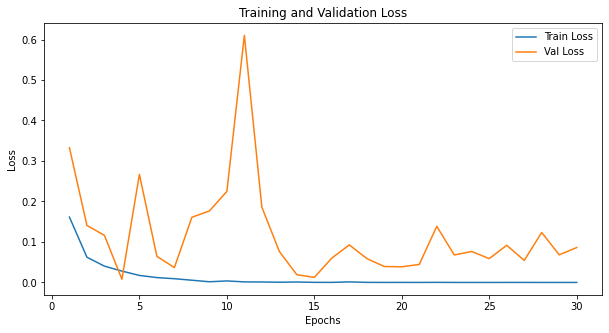

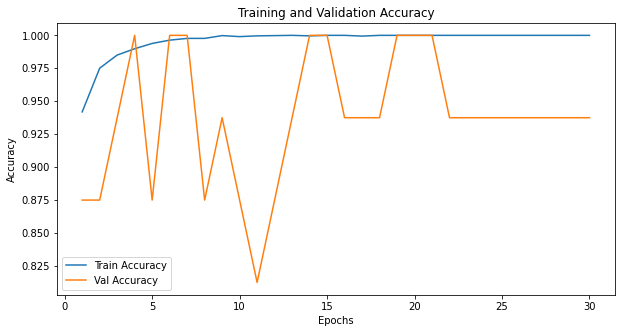

In [14]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_hv, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_hv, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_acc_hv, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_hv, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [15]:
import json
with open('train_acc_hv.json', 'w') as f:
    json.dump(train_acc_hv, f)
    
with open('train_loss_hv.json', 'w') as f:
    json.dump(train_loss_hv, f)

with open('val_acc_hv.json', 'w') as f:
    json.dump(val_acc_hv, f)
    
with open('val_loss_hv.json', 'w') as f:
    json.dump(val_loss_hv, f)

In [73]:
best_model = net  # Assuming 'net' is your model
best_model.load_state_dict(torch.load('saved_models/high_vgg.pth'))
best_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
high_loss, high_acc = test_model(best_model, test_highdataloader, criterion, device)

Loss: 0.3738, Accuracy: 0.9103


In [18]:
# start training
num_epochs=30
train_acc_lv,val_acc_lv ,train_loss_lv,val_loss_lv,model2 = train_model(net, lowdataloaders_dict, criterion, optimizer, num_epochs=num_epochs,save_path=f"saved_models/low_vgg.pth")

  0%|          | 0/326 [00:00<?, ?it/s]

using device： cuda:0
Epoch 1/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1720 Acc: 0.9463


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


val Loss: 0.7944 Acc: 0.6875
Saving best model with val accuracy: 0.6875


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 2/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0694 Acc: 0.9734


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


val Loss: 0.1526 Acc: 1.0000
Saving best model with val accuracy: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 3/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0401 Acc: 0.9841


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2591 Acc: 0.8750
Epoch 4/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0287 Acc: 0.9906


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1347 Acc: 0.9375
Epoch 5/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0194 Acc: 0.9933


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2569 Acc: 0.8125
Epoch 6/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0121 Acc: 0.9962


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4329 Acc: 0.8125
Epoch 7/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0127 Acc: 0.9956


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3151 Acc: 0.8125
Epoch 8/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0082 Acc: 0.9965


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0733 Acc: 1.0000
Epoch 9/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0040 Acc: 0.9987


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.4018 Acc: 0.6875
Epoch 10/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0109 Acc: 0.9958


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3938 Acc: 0.7500
Epoch 11/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0015 Acc: 0.9998


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0454 Acc: 1.0000
Epoch 12/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0035 Acc: 0.9987


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.8843 Acc: 0.7500
Epoch 13/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0006 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5342 Acc: 0.8125
Epoch 14/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0004 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4694 Acc: 0.8125
Epoch 15/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0003 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5741 Acc: 0.8125
Epoch 16/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0002 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5509 Acc: 0.8125
Epoch 17/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0002 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3968 Acc: 0.8125
Epoch 18/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4300 Acc: 0.8125
Epoch 19/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5385 Acc: 0.8125
Epoch 20/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3671 Acc: 0.8125
Epoch 21/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5946 Acc: 0.8125
Epoch 22/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.6669 Acc: 0.8125
Epoch 23/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4161 Acc: 0.8125
Epoch 24/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4379 Acc: 0.8125
Epoch 25/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0000 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4205 Acc: 0.8125
Epoch 26/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.6140 Acc: 0.8125
Epoch 27/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0000 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4822 Acc: 0.8125
Epoch 28/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0000 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4460 Acc: 0.8125
Epoch 29/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0000 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4330 Acc: 0.8125
Epoch 30/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

val Loss: 0.5674 Acc: 0.8125
Best validation accuracy: 1.0000


In [19]:
import json
with open('train_acc_lv.json', 'w') as f:
    json.dump(train_acc_lv, f)
    
with open('train_loss_lv.json', 'w') as f:
    json.dump(train_loss_lv, f)

with open('val_acc_lv.json', 'w') as f:
    json.dump(val_acc_lv, f)
    
with open('val_loss_lv.json', 'w') as f:
    json.dump(val_loss_lv, f)

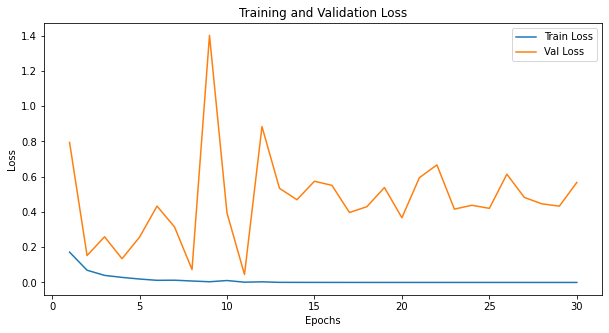

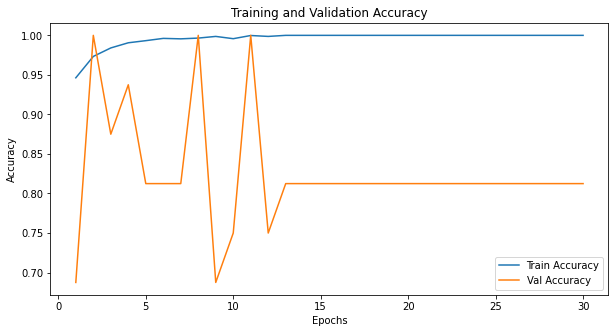

In [20]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_lv, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_lv, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_acc_lv, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_lv, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [14]:
best_model = net  # Assuming 'net' is your model
best_model.load_state_dict(torch.load('saved_models/low_vgg.pth'))
best_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
low_loss, low_acc = test_model(best_model, test_lowdataloader, criterion, device)


Loss: 0.5748, Accuracy: 0.8285


In [19]:
# start training
num_epochs=30
train_acc_srv,val_acc_srv ,train_loss_srv,val_loss_srv,model3 = train_model(net, srdataloaders_dict, criterion, optimizer, num_epochs=num_epochs,save_path=f"saved_models/sr_vgg.pth")

  0%|          | 0/452 [00:00<?, ?it/s]

using device： cuda:0
Epoch 1/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.5089 Acc: 0.7387


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


val Loss: 0.9580 Acc: 0.5000
Saving best model with val accuracy: 0.5000


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 2/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.3040 Acc: 0.8734


100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


val Loss: 0.8402 Acc: 0.5769
Saving best model with val accuracy: 0.5769


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 3/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.2285 Acc: 0.9102


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.8487 Acc: 0.5385
Epoch 4/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1905 Acc: 0.9291


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 1.0635 Acc: 0.5769
Epoch 5/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1738 Acc: 0.9343


100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


val Loss: 0.9073 Acc: 0.6154
Saving best model with val accuracy: 0.6154


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 6/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1487 Acc: 0.9461


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 1.0193 Acc: 0.5769
Epoch 7/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1353 Acc: 0.9503


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 1.1218 Acc: 0.5769
Epoch 8/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1302 Acc: 0.9518


100%|██████████| 2/2 [00:00<00:00,  2.50it/s]


val Loss: 0.7101 Acc: 0.6923
Saving best model with val accuracy: 0.6923


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 9/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1128 Acc: 0.9600


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.9840 Acc: 0.6538
Epoch 10/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1051 Acc: 0.9644


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.8735 Acc: 0.6538
Epoch 11/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1014 Acc: 0.9643


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


val Loss: 0.4848 Acc: 0.8462
Saving best model with val accuracy: 0.8462


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 12/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0856 Acc: 0.9708


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.7550 Acc: 0.7308
Epoch 13/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0875 Acc: 0.9679


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


val Loss: 0.3680 Acc: 0.8846
Saving best model with val accuracy: 0.8846


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 14/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0778 Acc: 0.9715


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.3195 Acc: 0.8846
Epoch 15/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0776 Acc: 0.9713


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.4367 Acc: 0.8462
Epoch 16/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0676 Acc: 0.9759


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.5719 Acc: 0.7308
Epoch 17/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0614 Acc: 0.9788


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.4251 Acc: 0.8077
Epoch 18/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0765 Acc: 0.9728


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.4625 Acc: 0.8077
Epoch 19/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0578 Acc: 0.9802


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.6147 Acc: 0.7692
Epoch 20/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0529 Acc: 0.9807


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.4362 Acc: 0.8077
Epoch 21/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0568 Acc: 0.9785


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.4993 Acc: 0.8077
Epoch 22/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0465 Acc: 0.9835


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.5664 Acc: 0.7692
Epoch 23/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0388 Acc: 0.9878


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.7686 Acc: 0.6154
Epoch 24/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0417 Acc: 0.9859


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.2603 Acc: 0.8846
Epoch 25/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0371 Acc: 0.9868


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.2597 Acc: 0.8846
Epoch 26/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0351 Acc: 0.9867


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.3286 Acc: 0.8462
Epoch 27/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0327 Acc: 0.9885


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.2241 Acc: 0.8462
Epoch 28/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0268 Acc: 0.9915


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.8613 Acc: 0.6923
Epoch 29/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0541 Acc: 0.9798


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.2858 Acc: 0.8462
Epoch 30/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0275 Acc: 0.9907


100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

val Loss: 0.5326 Acc: 0.8077
Best validation accuracy: 0.8846


In [20]:
import json
with open('train_acc_srv.json', 'w') as f:
    json.dump(train_acc_srv, f)
    
with open('train_loss_srv.json', 'w') as f:
    json.dump(train_loss_srv, f)

with open('val_acc_srv.json', 'w') as f:
    json.dump(val_acc_srv, f)
    
with open('val_loss_srv.json', 'w') as f:
    json.dump(val_loss_srv, f)

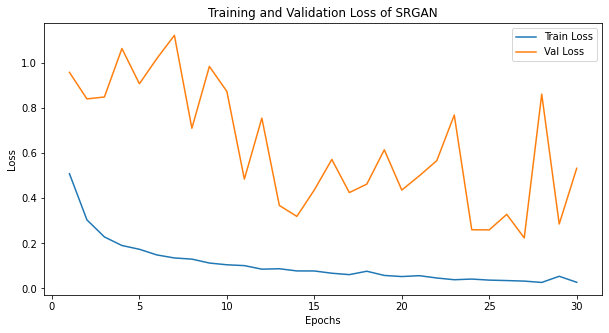

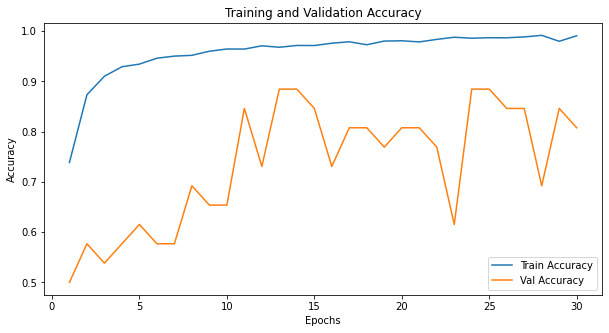

In [21]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_srv, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_srv, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of SRGAN')
plt.legend()
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_acc_srv, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_srv, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [22]:
best_model = net  # Assuming 'net' is your model
best_model.load_state_dict(torch.load('saved_models/sr_vgg.pth'))
best_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
sr_loss, sr_acc = test_model(best_model, test_srdataloader, criterion, device)

Loss: 0.5621, Accuracy: 0.8400


In [19]:
# start training
num_epochs=30
train_acc_dv,val_acc_dv ,train_loss_dv,val_loss_dv,model4 = train_model(net, ddpmdataloaders_dict, criterion, optimizer, num_epochs=num_epochs,save_path=f"saved_models/ddpm_vgg.pth")

  0%|          | 0/549 [00:00<?, ?it/s]

using device： cuda:0
Epoch 1/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0443 Acc: 0.9853


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


val Loss: 0.0377 Acc: 1.0000
Saving best model with val accuracy: 1.0000


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 2/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0423 Acc: 0.9858


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0367 Acc: 1.0000
Epoch 3/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0440 Acc: 0.9832


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1652 Acc: 0.9333
Epoch 4/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0408 Acc: 0.9850


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1876 Acc: 0.8667
Epoch 5/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0272 Acc: 0.9902


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0869 Acc: 0.9333
Epoch 6/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0261 Acc: 0.9907


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0615 Acc: 0.9667
Epoch 7/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0240 Acc: 0.9925


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.4394 Acc: 0.8333
Epoch 8/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0197 Acc: 0.9929


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1838 Acc: 0.8667
Epoch 9/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0238 Acc: 0.9910


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1576 Acc: 0.8667
Epoch 10/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0146 Acc: 0.9951


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.2921 Acc: 0.8667
Epoch 11/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0167 Acc: 0.9933


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0807 Acc: 0.9333
Epoch 12/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0111 Acc: 0.9965


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.2857 Acc: 0.8667
Epoch 13/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0081 Acc: 0.9975


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.3482 Acc: 0.8333
Epoch 14/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0089 Acc: 0.9974


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0164 Acc: 1.0000
Epoch 15/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0067 Acc: 0.9979


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0433 Acc: 0.9667
Epoch 16/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0119 Acc: 0.9959


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0664 Acc: 0.9667
Epoch 17/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0067 Acc: 0.9978


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1333 Acc: 0.9333
Epoch 18/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0062 Acc: 0.9982


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.6557 Acc: 0.8333
Epoch 19/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0032 Acc: 0.9993


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.2770 Acc: 0.8667
Epoch 20/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0030 Acc: 0.9992


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1684 Acc: 0.9000
Epoch 21/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0029 Acc: 0.9991


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.9701 Acc: 0.8333
Epoch 22/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0042 Acc: 0.9987


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.3501 Acc: 0.8667
Epoch 23/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0032 Acc: 0.9990


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.3513 Acc: 0.8667
Epoch 24/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0064 Acc: 0.9981


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.2964 Acc: 0.8667
Epoch 25/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0018 Acc: 0.9994


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.4006 Acc: 0.8667
Epoch 26/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0025 Acc: 0.9992


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.3149 Acc: 0.8667
Epoch 27/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0007 Acc: 1.0000


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.3609 Acc: 0.8667
Epoch 28/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0006 Acc: 1.0000


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.3062 Acc: 0.8667
Epoch 29/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0062 Acc: 0.9979


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.4233 Acc: 0.8667
Epoch 30/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0009 Acc: 1.0000


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

val Loss: 0.2690 Acc: 0.8667
Best validation accuracy: 1.0000


In [20]:
import json
with open('train_acc_dv.json', 'w') as f:
    json.dump(train_acc_dv, f)
    
with open('train_loss_dv.json', 'w') as f:
    json.dump(train_loss_dv, f)

with open('val_acc_dv.json', 'w') as f:
    json.dump(val_acc_dv, f)
    
with open('val_loss_dv.json', 'w') as f:
    json.dump(val_loss_dv, f)

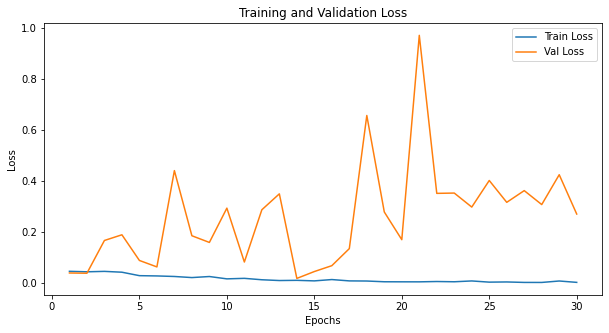

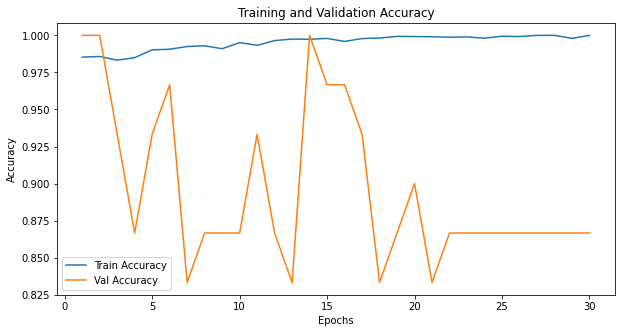

In [21]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_dv, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_dv, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_acc_dv, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_dv, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [22]:
best_model = net  # Assuming 'net' is your model
best_model.load_state_dict(torch.load('saved_models/ddpm_vgg.pth'))
best_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
low_loss, low_acc = test_model(best_model, test_ddpmdataloader, criterion, device)

Loss: 0.4694, Accuracy: 0.8625


# Pretrained resnet18

In [11]:
model_res= models.resnet18(pretrained=True)
num_ftrs = model_res.fc.in_features
model_res.fc = nn.Linear(num_ftrs, 2)
model_res = model_res.to(device)
model_res.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_res.parameters(), lr=1e-4, momentum=0.9)



In [46]:
# start training
num_epochs=30
train_acc_hr, val_acc_hr,train_loss_hr,val_loss_hr,model1 = train_model(model_res, highdataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs,save_path=f"saved_models/high_resnet.pth")

  0%|          | 0/326 [00:00<?, ?it/s]

using device： cuda:2
Epoch 1/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.2583 Acc: 0.8970


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val Loss: 0.6993 Acc: 0.6250
Saving best model with val accuracy: 0.6250


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 2/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1303 Acc: 0.9555


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


val Loss: 0.4792 Acc: 0.7500
Saving best model with val accuracy: 0.7500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 3/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1042 Acc: 0.9651


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val Loss: 0.4332 Acc: 0.8125
Saving best model with val accuracy: 0.8125


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 4/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0841 Acc: 0.9705


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val Loss: 0.3389 Acc: 0.8750
Saving best model with val accuracy: 0.8750


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 5/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0736 Acc: 0.9751


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5672 Acc: 0.5625
Epoch 6/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0621 Acc: 0.9799


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2686 Acc: 0.8750
Epoch 7/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0519 Acc: 0.9854


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2778 Acc: 0.8750
Epoch 8/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0478 Acc: 0.9862


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2028 Acc: 0.8750
Epoch 9/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0450 Acc: 0.9862


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


val Loss: 0.2202 Acc: 0.9375
Saving best model with val accuracy: 0.9375


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 10/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0356 Acc: 0.9904


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3593 Acc: 0.8125
Epoch 11/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0338 Acc: 0.9902


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2803 Acc: 0.8750
Epoch 12/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0304 Acc: 0.9914


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2111 Acc: 0.8750
Epoch 13/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0299 Acc: 0.9918


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4874 Acc: 0.7500
Epoch 14/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0222 Acc: 0.9956


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3272 Acc: 0.8750
Epoch 15/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0265 Acc: 0.9931


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1510 Acc: 0.8750
Epoch 16/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0199 Acc: 0.9964


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2214 Acc: 0.8750
Epoch 17/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0199 Acc: 0.9956


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1813 Acc: 0.8750
Epoch 18/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0157 Acc: 0.9962


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1949 Acc: 0.8750
Epoch 19/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0196 Acc: 0.9942


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1428 Acc: 0.8750
Epoch 20/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0146 Acc: 0.9967


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2088 Acc: 0.8750
Epoch 21/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0142 Acc: 0.9969


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1733 Acc: 0.8750
Epoch 22/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0117 Acc: 0.9985


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1647 Acc: 0.8750
Epoch 23/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0147 Acc: 0.9973


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2257 Acc: 0.8750
Epoch 24/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0104 Acc: 0.9979


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1569 Acc: 0.8750
Epoch 25/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0093 Acc: 0.9983


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2921 Acc: 0.8750
Epoch 26/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0096 Acc: 0.9979


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1424 Acc: 0.8750
Epoch 27/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0096 Acc: 0.9987


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2896 Acc: 0.8750
Epoch 28/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0093 Acc: 0.9988


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2313 Acc: 0.8750
Epoch 29/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0075 Acc: 0.9990


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1820 Acc: 0.8750
Epoch 30/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0060 Acc: 0.9998


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

val Loss: 0.1887 Acc: 0.8750
Best validation accuracy: 0.9375


In [47]:
import json
with open('train_acc_hr.json', 'w') as f:
    json.dump(train_acc_hr, f)
    
with open('train_loss_hr.json', 'w') as f:
    json.dump(train_loss_hr, f)

with open('val_acc_hr.json', 'w') as f:
    json.dump(val_acc_hr, f)
    
with open('val_loss_hr.json', 'w') as f:
    json.dump(val_loss_hr, f)

In [48]:
best_model = model_res  # Assuming 'net' is your model
best_model.load_state_dict(torch.load('saved_models/high_resnet.pth'))
best_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
high_loss, high_acc = test_model(best_model, test_highdataloader, criterion, device)

Loss: 0.4004, Accuracy: 0.8942


In [50]:
# start training
num_epochs=20
train_acc_lr,val_acc_lr ,train_loss_lr,val_loss_lr,model2 = train_model(model_res, lowdataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs,save_path=f"saved_models/low_resnet.pth")

  0%|          | 0/326 [00:00<?, ?it/s]

using device： cuda:2
Epoch 1/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.2131 Acc: 0.9210


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


val Loss: 1.1975 Acc: 0.6250
Saving best model with val accuracy: 0.6250


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 2/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1084 Acc: 0.9582


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7105 Acc: 0.6250
Epoch 3/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0710 Acc: 0.9753


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.6132 Acc: 0.6250
Epoch 4/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0651 Acc: 0.9774


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7111 Acc: 0.5625
Epoch 5/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0518 Acc: 0.9808


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.9207 Acc: 0.5625
Epoch 6/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0404 Acc: 0.9873


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.6115 Acc: 0.5625
Epoch 7/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0349 Acc: 0.9879


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.6221 Acc: 0.6250
Epoch 8/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0281 Acc: 0.9929


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7973 Acc: 0.5625
Epoch 9/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0246 Acc: 0.9927


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7405 Acc: 0.6250
Epoch 10/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0219 Acc: 0.9939


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.6813 Acc: 0.6250
Epoch 11/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0175 Acc: 0.9960


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


val Loss: 0.6348 Acc: 0.6875
Saving best model with val accuracy: 0.6875


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 12/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0151 Acc: 0.9960


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5770 Acc: 0.6250
Epoch 13/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0118 Acc: 0.9981


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5888 Acc: 0.6875
Epoch 14/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0124 Acc: 0.9965


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.6082 Acc: 0.6875
Epoch 15/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0137 Acc: 0.9969


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.9244 Acc: 0.5625
Epoch 16/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0114 Acc: 0.9969


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5749 Acc: 0.5625
Epoch 17/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0106 Acc: 0.9979


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7214 Acc: 0.5625
Epoch 18/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0096 Acc: 0.9973


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


val Loss: 0.3368 Acc: 0.7500
Saving best model with val accuracy: 0.7500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 19/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0096 Acc: 0.9975


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4311 Acc: 0.7500
Epoch 20/20
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0077 Acc: 0.9985


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

val Loss: 1.0205 Acc: 0.6250
Best validation accuracy: 0.7500


In [51]:
with open('train_acc_lr.json', 'w') as f:
    json.dump(train_acc_lr, f)
    
with open('train_loss_lr.json', 'w') as f:
    json.dump(train_loss_lr, f)

with open('val_acc_lr.json', 'w') as f:
    json.dump(val_acc_lr, f)
    
with open('val_loss_lr.json', 'w') as f:
    json.dump(val_loss_lr, f)

In [52]:
best_model = model_res  # Assuming 'net' is your model
best_model.load_state_dict(torch.load('saved_models/low_resnet.pth'))
best_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
low_loss, low_acc = test_model(best_model, test_lowdataloader, criterion, device)


Loss: 0.7357, Accuracy: 0.8397


In [54]:
# start training
num_epochs=30
train_acc_srr,val_acc_srr ,train_loss_srr,val_loss_srr,model3 = train_model(model_res, srdataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs,save_path=f"saved_models/sr_resnet.pth")

  0%|          | 0/326 [00:00<?, ?it/s]

using device： cuda:2
Epoch 1/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1965 Acc: 0.9275


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


val Loss: 1.3744 Acc: 0.5000
Saving best model with val accuracy: 0.5000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 2/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1086 Acc: 0.9595


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


val Loss: 0.9246 Acc: 0.6250
Saving best model with val accuracy: 0.6250


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 3/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0755 Acc: 0.9709


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.0400 Acc: 0.5625
Epoch 4/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0624 Acc: 0.9760


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7770 Acc: 0.6250
Epoch 5/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0525 Acc: 0.9827


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.9864 Acc: 0.6250
Epoch 6/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0421 Acc: 0.9873


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


val Loss: 0.7232 Acc: 0.6875
Saving best model with val accuracy: 0.6875


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 7/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0367 Acc: 0.9891


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.9110 Acc: 0.6250
Epoch 8/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0308 Acc: 0.9923


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.1334 Acc: 0.6250
Epoch 9/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0310 Acc: 0.9896


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.1478 Acc: 0.6250
Epoch 10/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0260 Acc: 0.9933


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.1386 Acc: 0.6250
Epoch 11/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0189 Acc: 0.9964


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.3769 Acc: 0.5625
Epoch 12/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0204 Acc: 0.9948


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.9658 Acc: 0.6250
Epoch 13/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0201 Acc: 0.9948


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.6054 Acc: 0.6250
Epoch 14/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0147 Acc: 0.9973


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.0496 Acc: 0.6250
Epoch 15/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0165 Acc: 0.9960


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.8937 Acc: 0.5625
Epoch 16/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0164 Acc: 0.9964


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.4239 Acc: 0.6250
Epoch 17/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0111 Acc: 0.9990


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.4601 Acc: 0.6250
Epoch 18/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0104 Acc: 0.9992


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.5492 Acc: 0.6250
Epoch 19/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0139 Acc: 0.9960


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.3854 Acc: 0.5625
Epoch 20/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0098 Acc: 0.9981


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.8499 Acc: 0.5625
Epoch 21/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0097 Acc: 0.9987


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.7000 Acc: 0.6875
Epoch 22/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0061 Acc: 0.9992


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.2677 Acc: 0.6250
Epoch 23/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0078 Acc: 0.9992


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.6144 Acc: 0.6250
Epoch 24/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0060 Acc: 0.9994


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 2.1556 Acc: 0.5625
Epoch 25/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0091 Acc: 0.9979


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.8410 Acc: 0.6250
Epoch 26/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0051 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.4929 Acc: 0.6250
Epoch 27/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0055 Acc: 0.9996


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.3164 Acc: 0.6875
Epoch 28/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0076 Acc: 0.9981


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.3032 Acc: 0.6875
Epoch 29/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0055 Acc: 0.9992


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.4661 Acc: 0.6250
Epoch 30/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0058 Acc: 0.9992


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

val Loss: 1.3633 Acc: 0.6875
Best validation accuracy: 0.6875


In [55]:
with open('train_acc_srr.json', 'w') as f:
    json.dump(train_acc_srr, f)
    
with open('train_loss_srr.json', 'w') as f:
    json.dump(train_loss_srr, f)

with open('val_acc_srr.json', 'w') as f:
    json.dump(val_acc_srr, f)
    
with open('val_loss_srr.json', 'w') as f:
    json.dump(val_loss_srr, f)

In [56]:
with open('train_acc_srr.json', 'r') as f:
    train_acc_srr = json.load(f)

# Load train loss data
with open('train_loss_srr.json', 'r') as f:
    train_loss_srr = json.load(f)

# Load validation accuracy data
with open('val_acc_srr.json', 'r') as f:
    val_acc_srr = json.load(f)

# Load validation loss data
with open('val_loss_srr.json', 'r') as f:
    val_loss_srr = json.load(f)

In [57]:
best_model = model_res  # Assuming 'net' is your model
best_model.load_state_dict(torch.load('saved_models/sr_resnet.pth'))
best_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [58]:
low_loss, low_acc = test_model(best_model, test_srdataloader, criterion, device)

Loss: 0.4679, Accuracy: 0.8590


In [45]:
# start training
num_epochs=30
train_acc_dr,val_acc_dr ,train_loss_dr,val_loss_dr,model4 = train_model(model_res, ddpmdataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs,save_path=f"saved_models/ddpm_resnet.pth")

  0%|          | 0/549 [00:00<?, ?it/s]

using device： cuda:0
Epoch 1/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0627 Acc: 0.9781


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


val Loss: 0.1112 Acc: 0.9667
Saving best model with val accuracy: 0.9667


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 2/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0550 Acc: 0.9801


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1721 Acc: 0.9667
Epoch 3/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0478 Acc: 0.9829


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1167 Acc: 0.9333
Epoch 4/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0431 Acc: 0.9852


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.2279 Acc: 0.9333
Epoch 5/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0390 Acc: 0.9869


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1119 Acc: 0.9667
Epoch 6/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0400 Acc: 0.9866


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1948 Acc: 0.9333
Epoch 7/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0291 Acc: 0.9910


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1894 Acc: 0.9333
Epoch 8/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0323 Acc: 0.9889


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1594 Acc: 0.9667
Epoch 9/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0259 Acc: 0.9921


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1538 Acc: 0.9333
Epoch 10/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0217 Acc: 0.9937


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0958 Acc: 0.9333
Epoch 11/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0256 Acc: 0.9927


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0840 Acc: 0.9333
Epoch 12/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0207 Acc: 0.9943


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1095 Acc: 0.9333
Epoch 13/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0189 Acc: 0.9954


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1157 Acc: 0.9667
Epoch 14/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0202 Acc: 0.9932


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.2215 Acc: 0.9333
Epoch 15/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0157 Acc: 0.9962


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1036 Acc: 0.9333
Epoch 16/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0133 Acc: 0.9965


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1470 Acc: 0.9667
Epoch 17/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0130 Acc: 0.9962


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1186 Acc: 0.9667
Epoch 18/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0122 Acc: 0.9974


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0910 Acc: 0.9667
Epoch 19/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0103 Acc: 0.9975


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0973 Acc: 0.9333
Epoch 20/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0106 Acc: 0.9979


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1635 Acc: 0.9333
Epoch 21/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0120 Acc: 0.9972


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1159 Acc: 0.9667
Epoch 22/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0100 Acc: 0.9976


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1286 Acc: 0.9333
Epoch 23/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0082 Acc: 0.9987


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1900 Acc: 0.9333
Epoch 24/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0103 Acc: 0.9974


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1437 Acc: 0.9333
Epoch 25/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0112 Acc: 0.9968


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1366 Acc: 0.9333
Epoch 26/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0088 Acc: 0.9974


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.2424 Acc: 0.9000
Epoch 27/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0075 Acc: 0.9985


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1487 Acc: 0.9333
Epoch 28/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0072 Acc: 0.9984


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1613 Acc: 0.9333
Epoch 29/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0098 Acc: 0.9975


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.1666 Acc: 0.9000
Epoch 30/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0082 Acc: 0.9982


100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

val Loss: 0.1343 Acc: 0.9333
Best validation accuracy: 0.9667


In [46]:
with open('train_acc_dr.json', 'w') as f:
    json.dump(train_acc_dr, f)
    
with open('train_loss_dr.json', 'w') as f:
    json.dump(train_loss_dr, f)

with open('val_acc_dr.json', 'w') as f:
    json.dump(val_acc_dr, f)
    
with open('val_loss_dr.json', 'w') as f:
    json.dump(val_loss_dr, f)

In [47]:
best_model = model_res  # Assuming 'net' is your model
best_model.load_state_dict(torch.load('saved_models/ddpm_resnet.pth'))
best_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
low_loss, low_acc = test_model(best_model, test_ddpmdataloader, criterion, device)

Loss: 0.5002, Accuracy: 0.8412


## Densenet 121

In [119]:
model_den= models.densenet121(pretrained=True)
num_ftrs = model_den.classifier.in_features
model_den.fc = nn.Linear(num_ftrs, 2)
model_den = model_den.to(device)
model_den.train()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [121]:
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer_den = optim.SGD(model_den.parameters(), lr=1e-4,momentum=0.9)

In [103]:
# start training
num_epochs=30
train_acc_hd,val_acc_hd ,train_loss_hd,val_loss_hd,model1 = train_model(model_den, highdataloaders_dict, criterion, optimizer_den, num_epochs=num_epochs,save_path=f"saved_models/high_densenet.pth")

  0%|          | 0/326 [00:00<?, ?it/s]

using device： cuda:2
Epoch 1/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.2328 Acc: 0.9488


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


val Loss: 0.0760 Acc: 1.0000
Saving best model with val accuracy: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 2/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0254 Acc: 0.9914


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4545 Acc: 0.8125
Epoch 3/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0129 Acc: 0.9971


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1931 Acc: 0.8750
Epoch 4/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0107 Acc: 0.9958


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0402 Acc: 1.0000
Epoch 5/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0063 Acc: 0.9985


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0804 Acc: 0.9375
Epoch 6/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0024 Acc: 0.9996


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0803 Acc: 0.9375
Epoch 7/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0017 Acc: 0.9998


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0698 Acc: 0.9375
Epoch 8/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0018 Acc: 0.9998


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0256 Acc: 1.0000
Epoch 9/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0016 Acc: 0.9998


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1489 Acc: 0.9375
Epoch 10/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0012 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1106 Acc: 0.9375
Epoch 11/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0005 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0585 Acc: 0.9375
Epoch 12/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0005 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0326 Acc: 1.0000
Epoch 13/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0006 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0340 Acc: 1.0000
Epoch 14/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0004 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0391 Acc: 1.0000
Epoch 15/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0002 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0205 Acc: 1.0000
Epoch 16/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0007 Acc: 0.9998


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0363 Acc: 1.0000
Epoch 17/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0016 Acc: 0.9996


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0187 Acc: 1.0000
Epoch 18/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0008 Acc: 0.9998


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0273 Acc: 1.0000
Epoch 19/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0004 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0359 Acc: 1.0000
Epoch 20/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0003 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0134 Acc: 1.0000
Epoch 21/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0005 Acc: 0.9998


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0072 Acc: 1.0000
Epoch 22/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0007 Acc: 0.9998


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0675 Acc: 0.9375
Epoch 23/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0004 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0640 Acc: 1.0000
Epoch 24/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0003 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0092 Acc: 1.0000
Epoch 25/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0003 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0300 Acc: 1.0000
Epoch 26/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0004 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0254 Acc: 1.0000
Epoch 27/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0004 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0214 Acc: 1.0000
Epoch 28/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0009 Acc: 0.9996


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0422 Acc: 1.0000
Epoch 29/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0003 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.0260 Acc: 1.0000
Epoch 30/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0003 Acc: 1.0000


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

val Loss: 0.0216 Acc: 1.0000
Best validation accuracy: 1.0000


In [104]:
import json
with open('train_acc_hd.json', 'w') as f:
    json.dump(train_acc_hd, f)
    
with open('train_loss_hd.json', 'w') as f:
    json.dump(train_loss_hd, f)

with open('val_acc_hd.json', 'w') as f:
    json.dump(val_acc_hd, f)
    
with open('val_loss_hd.json', 'w') as f:
    json.dump(val_loss_hd, f)

In [105]:
best_model = model_den  
best_model.load_state_dict(torch.load('saved_models/high_densenet.pth'))
best_model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [106]:
high_loss, high_acc = test_model(best_model, test_highdataloader, criterion, device)

Loss: 0.5684, Accuracy: 0.8606


In [122]:
# start training
num_epochs=30
train_acc_ld,val_acc_ld ,train_loss_ld,val_loss_ld,model2 = train_model(model_den, lowdataloaders_dict, criterion, optimizer_den, num_epochs=num_epochs,save_path=f"saved_models/low_densenet.pth")

  0%|          | 0/326 [00:00<?, ?it/s]

using device： cuda:2
Epoch 1/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.1696 Acc: 0.8275


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


val Loss: 0.6500 Acc: 0.8125
Saving best model with val accuracy: 0.8125


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 2/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0884 Acc: 0.9712


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5538 Acc: 0.8125
Epoch 3/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0589 Acc: 0.9797


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.6271 Acc: 0.7500
Epoch 4/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0406 Acc: 0.9877


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


val Loss: 0.2861 Acc: 0.8750
Saving best model with val accuracy: 0.8750


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 5/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0270 Acc: 0.9925


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3417 Acc: 0.8750
Epoch 6/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0269 Acc: 0.9921


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5215 Acc: 0.8125
Epoch 7/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0208 Acc: 0.9939


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4144 Acc: 0.8750
Epoch 8/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0185 Acc: 0.9964


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3423 Acc: 0.8750
Epoch 9/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0157 Acc: 0.9962


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.6434 Acc: 0.8125
Epoch 10/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0103 Acc: 0.9973


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5196 Acc: 0.8125
Epoch 11/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0097 Acc: 0.9987


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5167 Acc: 0.8125
Epoch 12/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0112 Acc: 0.9971


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3851 Acc: 0.8125
Epoch 13/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0063 Acc: 0.9990


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3898 Acc: 0.8125
Epoch 14/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0067 Acc: 0.9988


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5325 Acc: 0.8125
Epoch 15/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0071 Acc: 0.9988


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.8557 Acc: 0.8125
Epoch 16/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0048 Acc: 0.9994


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.6941 Acc: 0.8125
Epoch 17/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0073 Acc: 0.9988


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4153 Acc: 0.8125
Epoch 18/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0049 Acc: 0.9992


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5202 Acc: 0.8125
Epoch 19/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0062 Acc: 0.9990


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3775 Acc: 0.8125
Epoch 20/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0050 Acc: 0.9988


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5237 Acc: 0.8125
Epoch 21/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0046 Acc: 0.9988


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4897 Acc: 0.8125
Epoch 22/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0038 Acc: 0.9992


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5430 Acc: 0.8125
Epoch 23/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0061 Acc: 0.9988


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4466 Acc: 0.8125
Epoch 24/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0035 Acc: 0.9994


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3991 Acc: 0.8750
Epoch 25/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0035 Acc: 0.9996


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5954 Acc: 0.8125
Epoch 26/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0032 Acc: 0.9994


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5429 Acc: 0.8125
Epoch 27/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0045 Acc: 0.9990


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5689 Acc: 0.8125
Epoch 28/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0039 Acc: 0.9990


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5413 Acc: 0.8125
Epoch 29/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0039 Acc: 0.9992


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2733 Acc: 0.8750
Epoch 30/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0029 Acc: 0.9996


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

val Loss: 0.2806 Acc: 0.8125
Best validation accuracy: 0.8750


In [123]:
import json
with open('train_acc_ld.json', 'w') as f:
    json.dump(train_acc_ld, f)
    
with open('train_loss_ld.json', 'w') as f:
    json.dump(train_loss_ld, f)

with open('val_acc_ld.json', 'w') as f:
    json.dump(val_acc_ld, f)
    
with open('val_loss_ld.json', 'w') as f:
    json.dump(val_loss_ld, f)

In [124]:
best_model = model_den  # Assuming 'net' is your model
best_model.load_state_dict(torch.load('saved_models/low_densenet.pth'))
best_model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [125]:
low_loss, low_acc = test_model(best_model, test_lowdataloader, criterion, device)

Loss: 0.8450, Accuracy: 0.8189


In [111]:
# start training
num_epochs=30
train_acc_srd,val_acc_srd ,train_loss_srd,val_loss_srd,model3 = train_model(model_den, srdataloaders_dict, criterion, optimizer_den, num_epochs=num_epochs,save_path=f"saved_models/sr_densenet.pth")

  0%|          | 0/326 [00:00<?, ?it/s]

using device： cuda:2
Epoch 1/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1637 Acc: 0.9438


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


val Loss: 0.6077 Acc: 0.7500
Saving best model with val accuracy: 0.7500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 2/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0662 Acc: 0.9749


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.4922 Acc: 0.5625
Epoch 3/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0398 Acc: 0.9862


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


val Loss: 0.4857 Acc: 0.8125
Saving best model with val accuracy: 0.8125


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 4/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0316 Acc: 0.9893


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.1158 Acc: 0.8125
Epoch 5/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0265 Acc: 0.9919


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


val Loss: 0.6657 Acc: 0.8750
Saving best model with val accuracy: 0.8750


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 6/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0129 Acc: 0.9960


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5167 Acc: 0.8750
Epoch 7/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0090 Acc: 0.9969


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.9659 Acc: 0.8125
Epoch 8/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0058 Acc: 0.9987


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.0186 Acc: 0.8125
Epoch 9/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0087 Acc: 0.9967


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7873 Acc: 0.7500
Epoch 10/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0040 Acc: 0.9996


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7313 Acc: 0.8750
Epoch 11/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0023 Acc: 0.9994


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.6357 Acc: 0.8750
Epoch 12/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0021 Acc: 0.9994


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7791 Acc: 0.8750
Epoch 13/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0011 Acc: 0.9998


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.9725 Acc: 0.8125
Epoch 14/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0008 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7876 Acc: 0.8750
Epoch 15/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0007 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7224 Acc: 0.8750
Epoch 16/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0004 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7950 Acc: 0.8750
Epoch 17/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0005 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.9260 Acc: 0.8750
Epoch 18/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0005 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.9906 Acc: 0.8750
Epoch 19/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0004 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7935 Acc: 0.8750
Epoch 20/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0002 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.8081 Acc: 0.8750
Epoch 21/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0002 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.8338 Acc: 0.8750
Epoch 22/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0005 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 1.0892 Acc: 0.8750
Epoch 23/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0006 Acc: 0.9998


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7895 Acc: 0.8750
Epoch 24/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0002 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.8720 Acc: 0.8750
Epoch 25/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0023 Acc: 0.9994


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


val Loss: 0.3954 Acc: 0.9375
Saving best model with val accuracy: 0.9375


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 26/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0022 Acc: 0.9996


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5922 Acc: 0.8750
Epoch 27/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0005 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7422 Acc: 0.8750
Epoch 28/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0004 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.7664 Acc: 0.8125
Epoch 29/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0002 Acc: 1.0000


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.8146 Acc: 0.8750
Epoch 30/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0002 Acc: 1.0000


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

val Loss: 0.9297 Acc: 0.8750
Best validation accuracy: 0.9375


In [112]:
import json
with open('train_acc_srd.json', 'w') as f:
    json.dump(train_acc_srd, f)
    
with open('train_loss_srd.json', 'w') as f:
    json.dump(train_loss_srd, f)

with open('val_acc_srd.json', 'w') as f:
    json.dump(val_acc_srd, f)
    
with open('val_loss_srd.json', 'w') as f:
    json.dump(val_loss_srd, f)

In [113]:
best_model = model_den  # Assuming 'net' is your model
best_model.load_state_dict(torch.load('saved_models/sr_densenet.pth'))
best_model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [114]:
sr_loss, sr_acc = test_model(best_model, test_srdataloader, criterion, device)

Loss: 0.6646, Accuracy: 0.8413


In [115]:
# start training
num_epochs=30
train_acc_dd,val_acc_dd ,train_loss_dd,val_loss_dd,model4 = train_model(model_den, ddpmdataloaders_dict, criterion, optimizer_den, num_epochs=num_epochs,save_path=f"saved_models/ddpm_densenet.pth")

  0%|          | 0/452 [00:00<?, ?it/s]

using device： cuda:2
Epoch 1/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1065 Acc: 0.9656


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


val Loss: 0.1208 Acc: 0.9583
Saving best model with val accuracy: 0.9583


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 2/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0384 Acc: 0.9862


100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


val Loss: 0.0418 Acc: 1.0000
Saving best model with val accuracy: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 3/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0115 Acc: 0.9970


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.1065 Acc: 1.0000
Epoch 4/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0090 Acc: 0.9970


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.2357 Acc: 0.7917
Epoch 5/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0036 Acc: 0.9993


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0320 Acc: 1.0000
Epoch 6/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0020 Acc: 0.9997


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0279 Acc: 1.0000
Epoch 7/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0015 Acc: 0.9999


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0225 Acc: 1.0000
Epoch 8/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0014 Acc: 0.9999


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0579 Acc: 1.0000
Epoch 9/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0007 Acc: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.1859 Acc: 0.8750
Epoch 10/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0007 Acc: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0785 Acc: 1.0000
Epoch 11/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0005 Acc: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.1408 Acc: 0.8750
Epoch 12/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0004 Acc: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0995 Acc: 1.0000
Epoch 13/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0004 Acc: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.1045 Acc: 1.0000
Epoch 14/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0028 Acc: 0.9990


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0112 Acc: 1.0000
Epoch 15/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0009 Acc: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0119 Acc: 1.0000
Epoch 16/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0007 Acc: 0.9999


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0336 Acc: 1.0000
Epoch 17/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0028 Acc: 0.9993


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0237 Acc: 1.0000
Epoch 18/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0008 Acc: 0.9999


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0315 Acc: 1.0000
Epoch 19/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0006 Acc: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0140 Acc: 1.0000
Epoch 20/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0002 Acc: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0494 Acc: 1.0000
Epoch 21/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0005 Acc: 0.9997


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0376 Acc: 1.0000
Epoch 22/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0004 Acc: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0104 Acc: 1.0000
Epoch 23/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0005 Acc: 0.9997


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0470 Acc: 1.0000
Epoch 24/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0002 Acc: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0287 Acc: 1.0000
Epoch 25/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0351 Acc: 1.0000
Epoch 26/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0378 Acc: 1.0000
Epoch 27/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0240 Acc: 1.0000
Epoch 28/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0128 Acc: 1.0000
Epoch 29/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0003 Acc: 1.0000


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.0155 Acc: 1.0000
Epoch 30/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0001 Acc: 1.0000


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

val Loss: 0.0195 Acc: 1.0000
Best validation accuracy: 1.0000


In [116]:
import json
with open('train_acc_dd.json', 'w') as f:
    json.dump(train_acc_dd, f)
    
with open('train_loss_dd.json', 'w') as f:
    json.dump(train_loss_dd, f)

with open('val_acc_dd.json', 'w') as f:
    json.dump(val_acc_dd, f)
    
with open('val_loss_dd.json', 'w') as f:
    json.dump(val_loss_dd, f)

In [117]:
best_model = model_den  # Assuming 'net' is your model
best_model.load_state_dict(torch.load('saved_models/ddpm_densenet.pth'))
best_model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [118]:
ddpm_loss, ddpm_acc = test_model(best_model, test_ddpmdataloader, criterion, device)

Loss: 0.9247, Accuracy: 0.8323


## Efficientnet_b7

In [11]:
model_eff = models.efficientnet_b7(pretrained=True)

model_eff.classifier[1] = nn.Linear(in_features=model_eff.classifier[1].in_features, out_features=2)

In [15]:
criterion = nn.CrossEntropyLoss()

# Set different learning rates for different parts of the model
# optimizer_eff = torch.optim.Adam([
#     {'params': model_eff.features.parameters(), 'lr': 1e-3},  # Fine-tuning the pre-trained layers
#     {'params': model_eff.classifier.parameters(), 'lr': 1e-4}  # Training the new classification layer
# ])
optimizer_eff = optim.SGD(model_eff.parameters(), lr=1e-4,momentum=0.9)

In [103]:
# start training
num_epochs=30
train_acc_he,val_acc_he ,train_loss_he,val_loss_he,model1 = train_model(model_eff, highdataloaders_dict, criterion, optimizer_eff, num_epochs=num_epochs,save_path=f"saved_models/high_inc.pth")

  0%|          | 0/326 [00:00<?, ?it/s]

using device： cuda:0
Epoch 1/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.2624 Acc: 0.8940


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val Loss: 0.5056 Acc: 0.7500
Saving best model with val accuracy: 0.7500


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 2/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.2208 Acc: 0.9093


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5886 Acc: 0.6875
Epoch 3/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1958 Acc: 0.9185


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


val Loss: 0.3853 Acc: 0.8125
Saving best model with val accuracy: 0.8125


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 4/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1850 Acc: 0.9273


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5830 Acc: 0.6875
Epoch 5/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1666 Acc: 0.9339


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5852 Acc: 0.8125
Epoch 6/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1595 Acc: 0.9390


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5846 Acc: 0.8125
Epoch 7/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1453 Acc: 0.9469


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4684 Acc: 0.8125
Epoch 8/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1422 Acc: 0.9461


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5591 Acc: 0.8125
Epoch 9/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1399 Acc: 0.9452


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4904 Acc: 0.8125
Epoch 10/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1351 Acc: 0.9482


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4699 Acc: 0.8125
Epoch 11/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1280 Acc: 0.9511


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4703 Acc: 0.8125
Epoch 12/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1326 Acc: 0.9500


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4913 Acc: 0.8125
Epoch 13/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1312 Acc: 0.9528


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4694 Acc: 0.8125
Epoch 14/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1260 Acc: 0.9509


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4793 Acc: 0.8125
Epoch 15/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1264 Acc: 0.9511


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4495 Acc: 0.8125
Epoch 16/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1178 Acc: 0.9580


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5087 Acc: 0.8125
Epoch 17/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1144 Acc: 0.9599


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4750 Acc: 0.8125
Epoch 18/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1196 Acc: 0.9565


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4135 Acc: 0.8125
Epoch 19/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1103 Acc: 0.9597


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4580 Acc: 0.8125
Epoch 20/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1060 Acc: 0.9605


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4807 Acc: 0.8125
Epoch 21/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1071 Acc: 0.9624


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4537 Acc: 0.8125
Epoch 22/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1045 Acc: 0.9622


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4128 Acc: 0.8125
Epoch 23/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1078 Acc: 0.9611


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4807 Acc: 0.8125
Epoch 24/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1060 Acc: 0.9603


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4432 Acc: 0.8125
Epoch 25/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0985 Acc: 0.9661


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4450 Acc: 0.8125
Epoch 26/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0993 Acc: 0.9628


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4404 Acc: 0.8125
Epoch 27/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0899 Acc: 0.9701


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4361 Acc: 0.8125
Epoch 28/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1047 Acc: 0.9620


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4315 Acc: 0.8125
Epoch 29/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0909 Acc: 0.9711


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4386 Acc: 0.8125
Epoch 30/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0880 Acc: 0.9686


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

val Loss: 0.3914 Acc: 0.8125
Best validation accuracy: 0.8125


In [104]:
import json
with open('train_acc_he.json', 'w') as f:
    json.dump(train_acc_he, f)
    
with open('train_loss_he.json', 'w') as f:
    json.dump(train_loss_he, f)

with open('val_acc_he.json', 'w') as f:
    json.dump(val_acc_he, f)
    
with open('val_loss_he.json', 'w') as f:
    json.dump(val_loss_he, f)

In [105]:
best_model = model_eff  # Assuming 'net' is your model
best_model.load_state_dict(torch.load('saved_models/high_inc.pth'))
best_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

In [106]:
high_loss, high_acc = test_model(best_model, test_highdataloader, criterion, device)

Loss: 0.3603, Accuracy: 0.8638


In [55]:
# start training
num_epochs=30
train_acc_le,val_acc_le ,train_loss_le,val_loss_le,model2 = train_model(model_eff, lowdataloaders_dict, criterion, optimizer_eff, num_epochs=num_epochs,save_path=f"saved_models/low_inc.pth")

  0%|          | 0/326 [00:00<?, ?it/s]

using device： cuda:0
Epoch 1/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.2987 Acc: 0.8857


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


val Loss: 0.4601 Acc: 0.8750
Saving best model with val accuracy: 0.8750


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 2/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1329 Acc: 0.9519


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


val Loss: 0.1893 Acc: 0.9375
Saving best model with val accuracy: 0.9375


  0%|          | 0/326 [00:00<?, ?it/s]

Epoch 3/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1074 Acc: 0.9613


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2348 Acc: 0.8750
Epoch 4/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0774 Acc: 0.9730


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5293 Acc: 0.7500
Epoch 5/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0591 Acc: 0.9799


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4370 Acc: 0.8125
Epoch 6/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0503 Acc: 0.9829


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.5399 Acc: 0.7500
Epoch 7/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0457 Acc: 0.9852


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3913 Acc: 0.8750
Epoch 8/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0398 Acc: 0.9870


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3987 Acc: 0.8125
Epoch 9/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0264 Acc: 0.9925


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3036 Acc: 0.8125
Epoch 10/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0235 Acc: 0.9923


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2413 Acc: 0.9375
Epoch 11/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0246 Acc: 0.9927


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3303 Acc: 0.8750
Epoch 12/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0164 Acc: 0.9952


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3165 Acc: 0.8750
Epoch 13/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0150 Acc: 0.9944


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3436 Acc: 0.8125
Epoch 14/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0094 Acc: 0.9973


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4923 Acc: 0.8750
Epoch 15/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0071 Acc: 0.9987


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3784 Acc: 0.8750
Epoch 16/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0087 Acc: 0.9973


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3795 Acc: 0.8750
Epoch 17/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0077 Acc: 0.9981


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3726 Acc: 0.8750
Epoch 18/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0124 Acc: 0.9962


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3625 Acc: 0.9375
Epoch 19/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0085 Acc: 0.9973


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3430 Acc: 0.9375
Epoch 20/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0089 Acc: 0.9975


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3620 Acc: 0.9375
Epoch 21/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0062 Acc: 0.9985


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3122 Acc: 0.9375
Epoch 22/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0060 Acc: 0.9983


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3175 Acc: 0.9375
Epoch 23/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0045 Acc: 0.9992


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.2404 Acc: 0.9375
Epoch 24/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0058 Acc: 0.9979


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3213 Acc: 0.9375
Epoch 25/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0054 Acc: 0.9985


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.1915 Acc: 0.8750
Epoch 26/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0041 Acc: 0.9990


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3524 Acc: 0.9375
Epoch 27/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0071 Acc: 0.9979


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3098 Acc: 0.9375
Epoch 28/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0039 Acc: 0.9992


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.3942 Acc: 0.9375
Epoch 29/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0044 Acc: 0.9990


  0%|          | 0/326 [00:00<?, ?it/s]

val Loss: 0.4284 Acc: 0.9375
Epoch 30/30
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0017 Acc: 0.9998


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

val Loss: 0.4390 Acc: 0.9375
Best validation accuracy: 0.9375


In [56]:
import json
with open('train_acc_le.json', 'w') as f:
    json.dump(train_acc_le, f)
    
with open('train_loss_le.json', 'w') as f:
    json.dump(train_loss_le, f)

with open('val_acc_le.json', 'w') as f:
    json.dump(val_acc_le, f)
    
with open('val_loss_le.json', 'w') as f:
    json.dump(val_loss_le, f)

In [57]:
best_model = model_eff  
best_model.load_state_dict(torch.load('saved_models/low_inc.pth'))
best_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

In [58]:
low_loss, low_acc = test_model(best_model, test_lowdataloader, criterion, device)

Loss: 0.5970, Accuracy: 0.7901


In [16]:
# start training
num_epochs=30
train_acc_sre,val_acc_sre ,train_loss_sre,val_loss_sre,model3 = train_model(model_eff, srdataloaders_dict, criterion, optimizer_eff, num_epochs=num_epochs,save_path=f"saved_models/sr_inc.pth")

using device： cuda:0


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 1/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.6240 Acc: 0.6815


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


val Loss: 0.6646 Acc: 0.6154
Saving best model with val accuracy: 0.6154


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 2/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.5109 Acc: 0.8031


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.6571 Acc: 0.5769
Epoch 3/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.4213 Acc: 0.8494


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.6485 Acc: 0.5769
Epoch 4/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.3438 Acc: 0.8792


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


val Loss: 0.6423 Acc: 0.6538
Saving best model with val accuracy: 0.6538


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 5/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.3028 Acc: 0.8900


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.6917 Acc: 0.5385
Epoch 6/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.2548 Acc: 0.9062


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.6978 Acc: 0.5769
Epoch 7/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.2267 Acc: 0.9176


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.6601 Acc: 0.5769
Epoch 8/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.2092 Acc: 0.9205


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.6866 Acc: 0.5385
Epoch 9/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1996 Acc: 0.9238


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.6815 Acc: 0.5769
Epoch 10/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1838 Acc: 0.9291


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.6786 Acc: 0.6538
Epoch 11/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1656 Acc: 0.9401


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.6279 Acc: 0.6538
Epoch 12/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1612 Acc: 0.9382


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.6041 Acc: 0.5769
Epoch 13/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1485 Acc: 0.9458


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.6158 Acc: 0.6154
Epoch 14/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1418 Acc: 0.9460


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.5522 Acc: 0.6538
Epoch 15/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1286 Acc: 0.9532


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.5620 Acc: 0.6538
Epoch 16/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1292 Acc: 0.9518


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.5503 Acc: 0.6538
Epoch 17/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1183 Acc: 0.9547


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.5468 Acc: 0.6538
Epoch 18/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1157 Acc: 0.9573


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


val Loss: 0.5013 Acc: 0.7308
Saving best model with val accuracy: 0.7308


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 19/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1063 Acc: 0.9622


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.5338 Acc: 0.6923
Epoch 20/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1081 Acc: 0.9595


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.5214 Acc: 0.6538
Epoch 21/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1083 Acc: 0.9616


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


val Loss: 0.4708 Acc: 0.7692
Saving best model with val accuracy: 0.7692


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 22/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0986 Acc: 0.9636


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.5128 Acc: 0.7308
Epoch 23/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1018 Acc: 0.9616


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.4920 Acc: 0.6923
Epoch 24/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0945 Acc: 0.9636


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.4880 Acc: 0.7308
Epoch 25/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0912 Acc: 0.9670


100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


val Loss: 0.4442 Acc: 0.8077
Saving best model with val accuracy: 0.8077


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 26/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0909 Acc: 0.9677


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.4750 Acc: 0.7308
Epoch 27/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0862 Acc: 0.9691


100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


val Loss: 0.3983 Acc: 0.8462
Saving best model with val accuracy: 0.8462


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch 28/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0811 Acc: 0.9706


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.4403 Acc: 0.8077
Epoch 29/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0808 Acc: 0.9735


  0%|          | 0/452 [00:00<?, ?it/s]

val Loss: 0.4176 Acc: 0.8462
Epoch 30/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0807 Acc: 0.9699


100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

val Loss: 0.4274 Acc: 0.8462
Best validation accuracy: 0.8462


In [17]:
import json
with open('train_acc_sre.json', 'w') as f:
    json.dump(train_acc_sre, f)
    
with open('train_loss_sre.json', 'w') as f:
    json.dump(train_loss_sre, f)

with open('val_acc_sre.json', 'w') as f:
    json.dump(val_acc_sre, f)
    
with open('val_loss_sre.json', 'w') as f:
    json.dump(val_loss_sre, f)

In [18]:
best_model = model_eff  
best_model.load_state_dict(torch.load('saved_models/sr_inc.pth'))
best_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

In [19]:
sr_loss, sr_acc = test_model(model_eff, test_srdataloader, criterion, device)

Loss: 0.5243, Accuracy: 0.8311


In [63]:
# start training
num_epochs=30
train_acc_de,val_acc_de ,train_loss_de,val_loss_de,model4 = train_model(model_eff, ddpmdataloaders_dict, criterion, optimizer_eff, num_epochs=num_epochs,save_path=f"saved_models/ddpm_inc.pth")

  0%|          | 0/549 [00:00<?, ?it/s]

using device： cuda:0
Epoch 1/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.1175 Acc: 0.9590


100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


val Loss: 0.0919 Acc: 0.9667
Saving best model with val accuracy: 0.9667


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 2/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0492 Acc: 0.9823


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0582 Acc: 0.9667
Epoch 3/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0366 Acc: 0.9866


100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


val Loss: 0.0496 Acc: 1.0000
Saving best model with val accuracy: 1.0000


  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 4/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0224 Acc: 0.9937


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0322 Acc: 1.0000
Epoch 5/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0180 Acc: 0.9935


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0795 Acc: 0.9667
Epoch 6/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0115 Acc: 0.9967


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0290 Acc: 1.0000
Epoch 7/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0077 Acc: 0.9985


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0327 Acc: 1.0000
Epoch 8/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0078 Acc: 0.9983


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0450 Acc: 0.9667
Epoch 9/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0058 Acc: 0.9983


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0577 Acc: 0.9667
Epoch 10/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0078 Acc: 0.9979


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0144 Acc: 1.0000
Epoch 11/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0037 Acc: 0.9997


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0306 Acc: 1.0000
Epoch 12/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0035 Acc: 0.9991


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0487 Acc: 0.9667
Epoch 13/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0047 Acc: 0.9984


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0186 Acc: 1.0000
Epoch 14/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0035 Acc: 0.9993


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0391 Acc: 0.9667
Epoch 15/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0028 Acc: 0.9990


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0622 Acc: 0.9667
Epoch 16/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0029 Acc: 0.9990


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0232 Acc: 1.0000
Epoch 17/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0022 Acc: 0.9995


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0570 Acc: 0.9667
Epoch 18/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0031 Acc: 0.9987


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0444 Acc: 0.9667
Epoch 19/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0021 Acc: 0.9993


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0239 Acc: 1.0000
Epoch 20/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0022 Acc: 0.9993


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0242 Acc: 1.0000
Epoch 21/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0028 Acc: 0.9992


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0488 Acc: 0.9667
Epoch 22/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0020 Acc: 0.9995


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0446 Acc: 0.9667
Epoch 23/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0027 Acc: 0.9992


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0215 Acc: 1.0000
Epoch 24/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0022 Acc: 0.9994


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0607 Acc: 0.9667
Epoch 25/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0023 Acc: 0.9993


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0228 Acc: 1.0000
Epoch 26/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0025 Acc: 0.9995


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0610 Acc: 0.9667
Epoch 27/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0020 Acc: 0.9994


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0333 Acc: 0.9667
Epoch 28/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0018 Acc: 0.9995


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0669 Acc: 0.9667
Epoch 29/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0007 Acc: 0.9999


  0%|          | 0/549 [00:00<?, ?it/s]

val Loss: 0.0683 Acc: 0.9667
Epoch 30/30
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

train Loss: 0.0011 Acc: 0.9998


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

val Loss: 0.0810 Acc: 0.9667
Best validation accuracy: 1.0000


In [64]:
import json
with open('train_acc_de.json', 'w') as f:
    json.dump(train_acc_de, f)
    
with open('train_loss_de.json', 'w') as f:
    json.dump(train_loss_de, f)

with open('val_acc_de.json', 'w') as f:
    json.dump(val_acc_de, f)
    
with open('val_loss_de.json', 'w') as f:
    json.dump(val_loss_de, f)

In [65]:
best_model = model_eff
best_model.load_state_dict(torch.load('saved_models/ddpm_inc.pth'))
best_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

In [67]:
ddpm_loss, ddpm_acc = test_model(model_eff, test_ddpmdataloader, criterion, device)

Loss: 0.9911, Accuracy: 0.8412
